# New Venue Implementation Analysis in Sao Paulo / Brazil

### Utilizing unsupervisioned Machine Learning algorithms based on social-economic and geo-spacial data  
### Target venue: New Healthy Foods Market

#### Author: Juliano Garcia  
<juliano.garcia@protonmail.com>

# Executive Summary

This Data Science problem is designed to support the decision of choosing the best neighborhoods in Sao Paulo - Brazil to stablish a new Healthy Foods market.  
  
The data is constructed upon a wikipedia table containing neighborhood names, HDI (Human Development Index) and Zone. Additional data is then gathered from geo-spacial APIs such as Geopy library for coordinates and Foursquare for venues information.  
  
The analysis is conducted based on the gathered data to identify best neighborhood attributes for a healthy food market implementation, for that is used an unsupervised machine learning algorithm such as K-means in order to relate similat neighborhoods, then an analysis is performed on the cluster with the most healthy venues in order to identify th main caracteristics such as IDH geolocation on the city of Sao Paulo.

__Table of Contents__  
  
1. [Introduction](#1)<br>  
  
  
2. [Data](#2)<br>  
  
    2.1. [Gathering & Structuring Data](#2.1)<br>  
      

3. [K-Means Model](#3)<br>  
  
  
4. [Analyzing the Clusters](#4)<br>  
  
  
5. [Optimal Locations](#5)<br>  

# 1. Introduction<a id="1"></a>

This Data Science problem is designed to support the decision of choosing the best neighborhoods in Sao Paulo - Brazil to stablish a new Healthy Foods market.  
  
<img src = "https://i.pinimg.com/originals/1b/a1/94/1ba194e3034e8e9352c4c4b790a5215c.jpg" width = 300>  
  
Today in Sao Paulo, the region on wich to stablish the new venue might represent a key indicator of sucess or failure. Social development across the neighborhoods are very different, where the majority of the city's development is only concentrated on a few neighborhoods.  
  
Also, the healthy foods sector in the region is considerably more expensive than their non-healthy substitutes, therefore we need to make sure that the citizens in the chosen neighborhoods have the economic power to purchase the products.

An analysis based on the venues distribution across the neighborhoods as well as their social-economic indicators will be conducted in order to cluster and indetify the neighborhoods that are most likely enhance the sucess rate of the new venue.

In [3]:
#!pip install folium

In [4]:
# Importing basic libraries

# Data manipulation libraries
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import itertools

# Data gathering libraries
from bs4 import BeautifulSoup
import lxml
import json
import requests

# Data visualization tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as cls
import seaborn as sns

# Geospacial tools
import folium
from geopy.geocoders import Nominatim

# 2. Data<a id="2"></a>

For the present problem we will use data collected from 3 main sources:
- Wikipedia: This will be used to gather all the neighborhoods in Sao Paulo as well as some caractheristics such as the zone and the Human Development Index (HDI);  
  
  
- Geopy: This library will be used to get the coordinates (latitudes and longitudes) for Sao Paulo as well as for each of its neighborhoods;  
  
  
- Foursquare API: Will be used to get the venues surrouding each specific neighborhood in order to cluster them and have a better understanding of how envolved a neighborhood is in the healthy foods sector.  
  
Each source and gathering methods is shown in the code cells below

## 2.1. Gathering & Structuring Data<a id="2.1"></a>

### 2.1.1. Neighborhoods (Wikipedia)<a id="2.1.1"></a>

Getting the Sao Paulo neighborhoods from wikipedia's web page:  
https://pt.wikipedia.org/wiki/Lista_dos_distritos_de_S%C3%A3o_Paulo_por_%C3%8Dndice_de_Desenvolvimento_Humano  
Let's pull the Zone, Name and the HDI (Human Development Index)

#### Now let's get the data from the Wikipedia page

In [5]:
# Parsing the webpage url
html_page = requests.get('https://pt.wikipedia.org/wiki/Lista_dos_distritos_de_S%C3%A3o_Paulo_por_%C3%8Dndice_de_Desenvolvimento_Humano').text
soup = BeautifulSoup(html_page, 'lxml')

# Getting the postcodes table
tables = soup.find_all('table')

Building the DataFrame with BeatifulSoup library  
<i>The <b>'table_ranges'</b> values are based on the observation of the web page's source code</i>

In [6]:
# Instantiate the dataframe
neighborhoods = pd.DataFrame(columns=['Zone', 'Position', 'Neighborhood', 'HDI'])

# Set the row numbers for all the neighborhoods we need based on the distribution of the zone tables
table_ranges = [(3,10), (17,29), (36,43), (50,64), (71,85), (92,102), (109,115), (122,128), (132,143)]

for i, (start, finish) in enumerate(table_ranges):
    # Defining Zone
    zone = tables[9].find_all('h3')[i]
    zone = zone.text.split("[")[0]

    # Get the mian table
    d1 = tables[9].find_all('tr')
    d2 = d1[0].find_all('tr')

    # Gettng Position, Name and HDI for each table row
    for row in range(start, finish+1):
        d3 = d2[row].find_all('td')

        neighborhoods = neighborhoods.append({'Zone' : zone,
                                              'Position': d3[0].text,
                                              'Neighborhood': d3[1].text,
                                              'HDI': d3[2].text[:-1]}, ignore_index=True)

In [7]:
neighborhoods.head(10)

,Zone,Position,Neighborhood,HDI
0,Região Central,1,Consolação,"0,950"
1,Região Central,2,Bela Vista,"0,940"
2,Região Central,3,Liberdade,"0,936"
3,Região Central,4,Santa Cecília,"0,930"
4,Região Central,5,Cambuci,"0,903"
5,Região Central,6,República,"0,858"
6,Região Central,7,Sé,"0,854"
7,Região Central,8,Bom Retiro,"0,847"
8,Leste 1,1,Penha,"0,865"
9,Leste 1,2,Vila Matilde,"0,864"


In [8]:
neighborhoods.shape

(96, 4)

Cleaning and structuring the data

In [9]:
# Let's create a dictionary to translate the zone names
translate = {'Região Central' : 'Central',
             'Leste 1' : 'East 1',
             'Leste 2' : 'East 2',
             'Sudeste' : 'Southeast',
             'Oeste' : 'West',
             'Nordeste' : 'Northeast',
             'Noroeste' : 'Northwest',
             'Centro-Sul' : 'Center-South',
             'Sul' : 'South'}

In [10]:
# Replacing ',' with '.' since brazilian numeric standard differs from US - ',' is used for decimals separation
neighborhoods['HDI'] = neighborhoods['HDI'].apply(lambda x: str.replace(x, ',', '.'))

# Translating Zone
neighborhoods['Zone'] = neighborhoods['Zone'].apply(lambda x: str.replace(x, x, translate[x]))

neighborhoods.sample(10)

,Zone,Position,Neighborhood,HDI
62,Northeast,4,Casa Verde,0.874
79,Center-South,3,Santo Amaro,0.943
50,West,7,Morumbi,0.938
53,West,10,Vila Leopoldina,0.907
2,Central,3,Liberdade,0.936
60,Northeast,2,Tucuruvi,0.892
1,Central,2,Bela Vista,0.940
77,Center-South,1,Moema,0.961
22,East 2,2,Vila Jacuí,0.779
92,South,9,Grajaú,0.754


Now let's cast the columns to the correct types

In [11]:
neighborhoods['HDI'] = neighborhoods['HDI'].astype('float')
neighborhoods['Position'] = neighborhoods['Position'].astype('int')
neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
Zone            96 non-null object
Position        96 non-null int64
Neighborhood    96 non-null object
HDI             96 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ KB


### 2.1.2. Coordinates (Geopy Library)<a id="2.1.2"></a>

#### Geolocation for Sao Paulo - Brazil

In [12]:
address = 'Sao Paulo / BR'

geolocator = Nominatim(user_agent="sp_explorer")
location = geolocator.geocode(address)
sp_coord = (location.latitude, location.longitude)

sp_coord

(-23.5506507, -46.6333824)

Getting the Latitudes and Longitudes for the neighborhoods  
Let's use a separate DataFrame so we only need to run it once in order to avoid hitting the query limit of the API

In [13]:
# Defining the function to get the Latitude and Longitude of given neighborhood
def get_lat_long(neigh):
    address = neigh + ', Sao Paulo / BR'

    geolocator = Nominatim(user_agent="sp_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    return (latitude, longitude)

In [14]:
# Instantiate the dataframe
coords = pd.DataFrame(columns=['Neighborhood', 'coords'])
coords['Neighborhood'] = neighborhoods['Neighborhood']

In [16]:
# AVOID RE-RUNNING THS CELL!! ______________________________________________________________ !!!
coords['coords'] = coords['Neighborhood'].apply(get_lat_long)

#### Adding the Coordinates to the Neighborhood DataFrame casted as floats

In [17]:
neighborhoods['Latitude'] = coords['coords'].apply(lambda x : x[0]).astype('float')
neighborhoods['Longitude'] = coords['coords'].apply(lambda x : x[1]).astype('float')

In [18]:
neighborhoods.sample(5)

,Zone,Position,Neighborhood,HDI,Latitude,Longitude
55,West,12,Jaguara,0.863,-23.507446,-46.755315
22,East 2,2,Vila Jacuí,0.779,-23.500294,-46.458717
3,Central,4,Santa Cecília,0.930,-23.529660,-46.651892
42,Southeast,14,Sacomã,0.839,-23.631090,-46.595618
14,East 1,7,São Mateus,0.804,-23.599843,-46.477605


Let's see how the data that we have appears on a map!

In [19]:
# create map of Sao Paulo using latitude and longitude values
map_sp = folium.Map(location=[sp_coord[0], sp_coord[1]],zoom_start=10)
map_sp.choropleth(geo_data=r'sao-paulo.geojson',
                  fill_opacity=0.1,
                  line_opacity=0.8)

# add markers to map
for lat, lng, zone, name in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Zone'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(name, zone)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sp)  
    
map_sp

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### 2.1.3. Venues (Foursquare API)<a id="2.1.3"></a>

API Credentials hidden for sharable version

In [20]:
# The code was removed by Watson Studio for sharing.

In [21]:
VERSION = '20190609' # Foursquare API version

Before we proceed, let's define a function to get the categories of all the venues.

In [22]:
def getVenues(df, names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(df[names], df[latitudes], df[longitudes]):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']
    
    return(nearby_venues)

Now let's use the above function to create a new DataFrame ('sp_venues') with all the venues we gathered from the API

In [23]:
# AVOID RE-RUNNING THS CELL!! ______________________________________________________________ !!!
sp_venues = getVenues(df=neighborhoods,
                      names='Neighborhood',
                      latitudes='Latitude',
                      longitudes='Longitude')

In [24]:
print(sp_venues.shape)
sp_venues.head()

(2570, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Consolação,-23.54808,-46.660029,Carlota,-23.546694,-46.660780,Restaurant
1,Consolação,-23.54808,-46.660029,Bráz Pizzaria,-23.547989,-46.657645,Pizza Place
2,Consolação,-23.54808,-46.660029,Ici Bistrô,-23.549389,-46.658190,French Restaurant
3,Consolação,-23.54808,-46.660029,Loja Mod,-23.546138,-46.658954,Furniture / Home Store
4,Consolação,-23.54808,-46.660029,Corrientes 348 Parrilla Porteña,-23.546014,-46.660163,Argentinian Restaurant


Let's check how many venues in average the API got for each neighborhood

In [25]:
sp_venues[['Neighborhood', 'Venue']].groupby('Neighborhood').count().describe()

,Venue
count,93.000000
mean,27.634409
std,28.652637
min,1.000000
25%,8.000000
50%,16.000000
75%,34.000000
max,100.000000


How many unique categories we got?

In [26]:
len(sp_venues['Venue Category'].unique())

281

Let's encode the categories and have the avergae on the total venues for each neighborhood

In [27]:
# Creating the encoded DataFrame with 'get_dummies' from pandas
sp_encoded = sp_venues[['Neighborhood']]
sp_encoded = sp_encoded.join(pd.get_dummies(sp_venues[['Venue Category']], prefix="", prefix_sep=""))

# Next, let's group rows by neighborhood
sp_encoded = sp_encoded.groupby('Neighborhood').sum().reset_index()
sp_encoded.head()

,Neighborhood,Acai House,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Alto de Pinheiros,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Anhangüera,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aricanduva,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Artur Alvim,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Barra Funda,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Finally let's add the HDI to the encoded DataFrame

In [28]:
# Adding the columns
sp_encoded = sp_encoded.merge(right=neighborhoods[['Neighborhood','Zone', 'Latitude', 'Longitude', 'HDI']],
                              on='Neighborhood')

In [29]:
# Now let's re-arrange the columns
columns = list(sp_encoded.columns)
categories_list = columns[1:-4]
columns = ['Zone', 'Neighborhood', 'Latitude', 'Longitude', 'HDI'] + categories_list

sp_encoded = sp_encoded[columns]

__sp_encoded__ DataFrame: contains venue category frequencie as well as Neighborhood's HDI, Coordinates and Zone

In [30]:
print(sp_encoded.shape)
sp_encoded.head()

(93, 286)


,Zone,Neighborhood,Latitude,Longitude,HDI,Acai House,Accessories Store,African Restaurant,American Restaurant,Antique Shop,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,West,Alto de Pinheiros,-23.549550,-46.712155,0.955,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Northwest,Anhangüera,-23.432908,-46.788534,0.774,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Southeast,Aricanduva,-23.572630,-46.518321,0.885,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,East 1,Artur Alvim,-23.539221,-46.485265,0.833,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,West,Barra Funda,-23.522709,-46.672928,0.917,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now first let's just work with neighborhoods that contains any healthy markets out fitness venues

First let's find those "healthy" venues

In [31]:
# Categories containing "market"
[x for x in sp_encoded.columns if 'market' in x.lower()]

['Farmers Market', 'Flea Market', 'Market', 'Supermarket']

In [32]:
# Categories containing "health"
[x for x in sp_encoded.columns if 'health' in x.lower()]

['Health & Beauty Service', 'Health Food Store']

In [33]:
# Categories containing "Grocery"
[x for x in sp_encoded.columns if 'groceries' in x.lower() or 'grocery' in x.lower()]

['Grocery Store', 'Organic Grocery']

In [34]:
# Categories containing "Gym"
[x for x in sp_encoded.columns if 'gym' in x.lower()]

['College Gym', 'Gym', 'Gym / Fitness Center', 'Gym Pool', 'Gymnastics Gym']

In [35]:
# Categories containing "fruit" or "vegetable"
[x for x in sp_encoded.columns if 'fruit' in x.lower() or 'vegetable' in x.lower()]

['Fruit & Vegetable Store']

In [36]:
# Restaurant containing "gluten" or "vegan"
[x for x in sp_encoded.columns if 'restaurant' in x.lower() and ('gluten' in x.lower() or 'vegan' in x.lower())]

['Gluten-free Restaurant', 'Vegetarian / Vegan Restaurant']

Now let's aggregate the lists into categories

In [37]:
healthy_markets = ['Farmers Market', 'Health Food Store', 'Organic Grocery', 'Fruit & Vegetable Store']
traditional_markets = ['Flea Market', 'Market', 'Supermarket', 'Grocery Store']
restaurants = ['Gluten-free Restaurant', 'Vegetarian / Vegan Restaurant']
gym = ['College Gym', 'Gym', 'Gym / Fitness Center', 'Gym Pool', 'Gymnastics Gym']

Now we create a DataFrame with those categories

In [38]:
# We drag the general Neighborhood info
sp_health = sp_encoded.iloc[:, :5]

# Now we create the categories
sp_health['Healthy Markets'] = sp_encoded[healthy_markets].sum(axis=1)
sp_health['Traditional Markets'] = sp_encoded[traditional_markets].sum(axis=1)
sp_health['Gyms'] = sp_encoded[gym].sum(axis=1)
sp_health['Restaurants'] = sp_encoded[restaurants].sum(axis=1)

# Fanilly let's define the Neighborhoods as the index
sp_health.set_index('Neighborhood', inplace=True)
sp_health.head()

,Zone,Latitude,Longitude,HDI,Healthy Markets,Traditional Markets,Gyms,Restaurants
Neighborhood,,,,,,,,
Alto de Pinheiros,West,-23.549550,-46.712155,0.955,0,0,1,0
Anhangüera,Northwest,-23.432908,-46.788534,0.774,0,1,1,0
Aricanduva,Southeast,-23.572630,-46.518321,0.885,1,1,1,0
Artur Alvim,East 1,-23.539221,-46.485265,0.833,0,1,2,0
Barra Funda,West,-23.522709,-46.672928,0.917,0,1,1,0


Now we are ready to start our model!

# 3. K-Means Model<a id="3"></a>

In [39]:
# Importing ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

Now we'll scale our matrix for our model

In [40]:
X = sp_health.iloc[:, 3:].values
X = StandardScaler().fit_transform(X)

Here let's use the elbow method to identify the optimal number of clusters  
In this method we run the model multiple times, each time with a different K and store the distortions (how far each obsrevation is from its cluster centroid), then we see on which K we started to gain very little information, that is, the elbow.

In [41]:
distortions = []
ks = range(1,11)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    kmeans.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

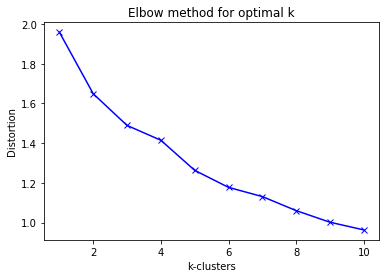

In [42]:
# Plot the elbow
plt.plot(ks, distortions, 'bx-')
plt.xlabel('k-clusters')
plt.ylabel('Distortion')
plt.title('Elbow method for optimal k')
plt.show()

There! We can see that after 8 clusters the distortion loss is reduced

In [43]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(X)

Let's add the cluster labels to the DataFrame

In [44]:
sp_health.insert(1, 'Cluster Labels', kmeans.labels_)
sp_health.sample(5)

,Zone,Cluster Labels,Latitude,Longitude,HDI,Healthy Markets,Traditional Markets,Gyms,Restaurants
Neighborhood,,,,,,,,,
Vila Medeiros,Northeast,0,-23.488144,-46.577413,0.836,0,2,2,0
Sé,Central,2,-23.546180,-46.631811,0.854,0,1,3,1
Cachoeirinha,Northeast,1,-23.449509,-46.663647,0.802,0,0,0,0
Raposo Tavares,West,1,-23.591765,-46.780607,0.819,0,1,0,0
Belém,Southeast,7,-23.538476,-46.595039,0.897,0,0,2,0


In [45]:
# How much neighborhoods we have on each cluster?
sp_health['Cluster Labels'].value_counts()

1    33
3    16
0    16
7    14
2     9
4     3
6     1
5     1
Name: Cluster Labels, dtype: int64

# 4. Analyzing the Clusters<a id="4"></a>

First, let's make a summary of each cluster based on the average number of venues we have for each category

In [46]:
cluster_summary = sp_health.groupby('Cluster Labels').mean().iloc[:, 2:]
cluster_summary.sort_values('HDI', ascending=False)

,HDI,Healthy Markets,Traditional Markets,Gyms,Restaurants
Cluster Labels,,,,,
5,0.960000,3.000000,2.000000,5.000000,2.0000
2,0.932222,0.444444,1.333333,3.555556,1.0000
4,0.928333,3.000000,3.333333,5.333333,0.0000
7,0.912143,0.142857,0.357143,1.857143,0.0000
3,0.886937,1.187500,0.812500,0.750000,0.0625
6,0.858000,1.000000,0.000000,0.000000,4.0000
0,0.832250,0.250000,2.437500,1.375000,0.0000
1,0.796758,0.090909,0.393939,0.484848,0.0000


Let's get visual! We'll use matplotlib's artist layer to plot a bar chart for the clusters categories

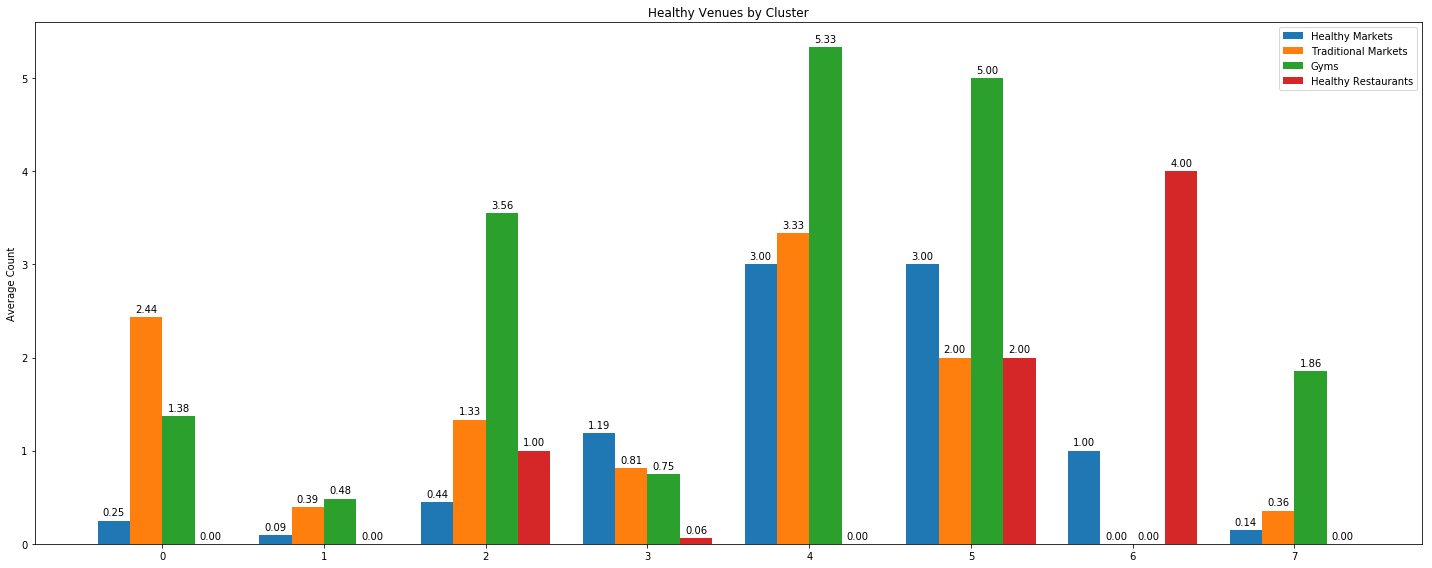

In [47]:
ind = np.arange(cluster_summary.shape[0])  # the x locations for the groups
width = 0.20  # the width of the bars

fig, ax = plt.subplots(figsize=(20,8))
rec1 = ax.bar(ind + -3*width/2, cluster_summary['Healthy Markets'], width=width, label='Healthy Markets')
rec2 = ax.bar(ind + -1*width/2, cluster_summary['Traditional Markets'], width=width, label='Traditional Markets')
rec3 = ax.bar(ind + 1*width/2, cluster_summary['Gyms'], width=width, label='Gyms')
rec4 = ax.bar(ind + 3*width/2, cluster_summary['Restaurants'], width=width, label='Healthy Restaurants')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Count')
ax.set_title('Healthy Venues by Cluster')
ax.set_xticks(ind)
ax.set_xticklabels(cluster_summary.index)
ax.legend()

def labels(rects, xpos='center'):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:0.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # use 3 points offset
                    textcoords="offset points",
                    ha=xpos, va='bottom')  # in both directions
    
for rec in [rec1, rec2, rec3, rec4]:
    labels(rec)
    
fig.tight_layout()

And boxplots for the HDI distribution

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


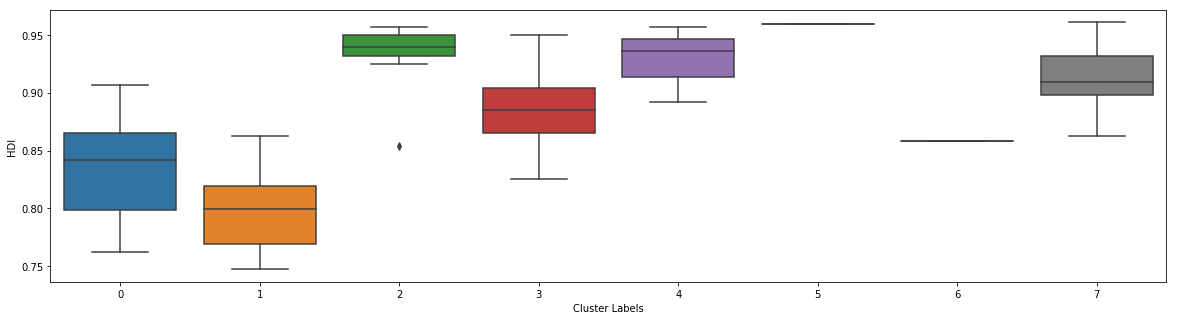

In [48]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(x='Cluster Labels', y='HDI', data=sp_health[['Cluster Labels', 'HDI']], ax=ax)

We can se a coorelation between the number of Healthy venues (Markets and Restaurants) and the Neighborhood's HDI.  
As example we can take the clusters __2, 3, 4, 5 and 7__. Thet all got medium-high HDI and a lot of Healthy Markets and Healthy Restaurants!

Let's check that

In [49]:
# Summing the Healthy venues to check correlation with HDI
sp_health['Healthy Venues'] = sp_health['Healthy Markets'] + sp_health['Gyms'] + sp_health['Restaurants']

# Let's check the correlation
sp_health[['HDI', 'Healthy Venues']].corr()

,HDI,Healthy Venues
HDI,1.00000,0.59436
Healthy Venues,0.59436,1.00000


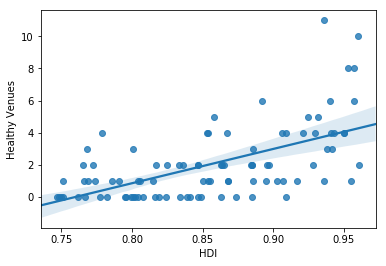

In [50]:
# Let's check how a scatterplot would look like
sns.regplot(x='HDI',y='Healthy Venues', data=sp_health[['HDI', 'Healthy Venues']])

Yep, so the higher the HDI, the higher is the Healthy Venues, in general. We can, therefore, say that the developed the neighborhood is the more Health conscious the populations is.

On a first look there is 2 clusters that might contains good neighborhoods for a new Healthy Market!  
- __2__: Concentrates a lot of high HDI neighborhoods (ranging arounf 0.95), has a lot of gyms which might means that people on those neighborhoods are very healthy conscient, however the amount of Healthy Markets there seems very low!Only 0.4 on average!  
- __7__: Althought it's got a wider HDI distribution, we might be able to check some of the neighborhoods in the 3rd or 4rth quartile, this cluster contains neighborhoods with a good amount of gyms and no Healthy venues what so ever! Neigther Markets nor Restaurants!

Let's see those 2 clusters (2 and 7) in a map

In [51]:
# First we define a DataFrame with those 2 clusters
potential = sp_health[(sp_health['Cluster Labels'] == 2) | (sp_health['Cluster Labels'] == 7)].reset_index()
potential.head(2)

,Neighborhood,Zone,Cluster Labels,Latitude,Longitude,HDI,Healthy Markets,Traditional Markets,Gyms,Restaurants,Healthy Venues
0,Alto de Pinheiros,West,7,-23.549550,-46.712155,0.955,0,0,1,0,1
1,Barra Funda,West,7,-23.522709,-46.672928,0.917,0,1,1,0,1


In [52]:
potential_map = folium.Map(location=[sp_coord[0], sp_coord[1]],zoom_start=12)

maplist = zip(potential['Latitude'],
              potential['Longitude'],
              potential['Zone'],
              potential['Neighborhood'],
              potential['Healthy Markets'],
              potential['HDI'],
              potential['Cluster Labels'])
col = {2 : 'red', 7 : 'blue'}

# add markers to map
for lat, lng, zone, name, mk, hdi, clust in maplist:
    label = '{}\n {}\n Cluster:{}\n HDI:{}\n HealthyMarkets:{}'.format(name, zone, clust, hdi, mk)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col[clust],
        fill=True,
        fill_color=col[clust],
        fill_opacity=0.7,
        parse_html=False).add_to(potential_map)  
    
potential_map

# 5. Optimal Locations<a id="5"></a>

And now let's check the potential neighborhoods with the highest possible HDI and lowest possible number of Healthy Markets.  
For that let's create an index: __HH Index__  
- _HH Index  =  (HDI * 10 + Gyms + Restaurants) / (Healthy Markets * 5 + Traditional Markets)_

Basically on the denominator we are aggregating wanted features such as Gyms and Restaurants that would indicate that the neighborhood is health consious, while allocating weights based on importance and scale. The numerator is unwanted attributes in this case competitors.

In [53]:
# Let's create the index
potential['HH Index'] = (potential['HDI']*10 + potential['Gyms'] + potential['Restaurants']) / ((potential['Healthy Markets']*5 + potential['Traditional Markets']) + 0.1) # Summing 0.1 to avoid divide by zero

# Let's apply a threshold for HDI, we don't want any neighborhood with HDI lower than 0.900
potential = potential[potential['HDI'] >= 0.900]

# now sort form the highest to lowest
potential.sort_values('HH Index', ascending=False, inplace=True)

# And let's see the top 5 options
potential.head(5)

,Neighborhood,Zone,Cluster Labels,Latitude,Longitude,HDI,Healthy Markets,Traditional Markets,Gyms,Restaurants,Healthy Venues,HH Index
9,Itaim Bibi,West,2,-23.601512,-46.685208,0.953,0,0,6,2,8,175.3
13,Lapa,West,2,-23.524254,-46.703381,0.941,0,0,3,1,4,134.1
15,Moema,Center-South,7,-23.594585,-46.661801,0.961,0,0,2,0,2,116.1
0,Alto de Pinheiros,West,7,-23.549550,-46.712155,0.955,0,0,1,0,1,105.5
22,Tatuapé,Southeast,7,-23.539603,-46.569324,0.936,0,0,1,0,1,103.6


Finally we have our top 5 Neighborhoods for our new Healthy Market venue!

The first one (Itaim Bibi) has 6 gyms, let's try to find where would be the optimal spot for the venue so it would be near those gyms

In [54]:
# First let's see get the gyms
itaim_gyms = sp_venues[(sp_venues['Neighborhood'] == 'Itaim Bibi') & (sp_venues['Venue Category'].isin(gym))]
itaim_gyms

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1554,Itaim Bibi,-23.601512,-46.685208,Bluefit,-23.598573,-46.685184,Gym / Fitness Center
1555,Itaim Bibi,-23.601512,-46.685208,Showa,-23.602225,-46.682318,Gym Pool
1557,Itaim Bibi,-23.601512,-46.685208,CrossFit SP,-23.599196,-46.682842,Gym / Fitness Center
1564,Itaim Bibi,-23.601512,-46.685208,Companhia Athletica,-23.599996,-46.689116,Gym
1579,Itaim Bibi,-23.601512,-46.685208,Sala de Musculação,-23.599715,-46.689079,Gym
1581,Itaim Bibi,-23.601512,-46.685208,Crossfit BlackSheep,-23.598609,-46.685650,Gym


Now let's use the K-Means algorithm to find a centroid between those 6 gyms

In [55]:
# Extract the gyms coordinates
gyms_coords = itaim_gyms[['Venue Latitude', 'Venue Longitude']].values.astype('float')
# Create th k-means object
gyms_k = KMeans(n_clusters=1).fit(gyms_coords)
# Get the centroid coordinates
gyms_center = gyms_k.cluster_centers_
gyms_center

array([[-23.599719 , -46.6856982]])

Let's plot!

In [56]:
itaim_map = folium.Map(location=[gyms_center[0,0], gyms_center[0,1]],zoom_start=16)

maplist = zip(itaim_gyms['Venue Latitude'],
              itaim_gyms['Venue Longitude'],
              itaim_gyms['Venue'],
              itaim_gyms['Venue Category'])

# add gym markers to map
for lat, lng, ven, cat in maplist:
    label = '{}\n {}'.format(ven, cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color=col[clust],
        fill_opacity=0.7,
        parse_html=False).add_to(itaim_map)  
 
# add centroid markers
folium.CircleMarker(
    [gyms_center[0,0], gyms_center[0,1]],
    radius=10,
    popup='Gyms Center Point',
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(itaim_map)

    
itaim_map

There it is, a posisble spot for our new Healthy Foods Market! 

In [57]:
# This cell creates a geojson of sao paulo based on thecopied data from NYU json repos.
#f = open('sao-paulo.geojson', 'w')
#f.write('{"type":"FeatureCollection","totalFeatures":1,"features":[{"type":"Feature","id":"wy336kv1637.1","geometry":{"type":"MultiPolygon","coordinates":[[[[-46.87193478,-23.79861287],[-46.87298747,-23.79758905],[-46.8759342,-23.79465173],[-46.87631852,-23.79431546],[-46.87686906,-23.79388852],[-46.87723274,-23.79354805],[-46.88023853,-23.79052407],[-46.88041839,-23.79036463],[-46.88060314,-23.79023345],[-46.88079738,-23.79015693],[-46.8809864,-23.79015741],[-46.88118446,-23.79020229],[-46.88178247,-23.79041384],[-46.88301467,-23.79100566],[-46.88361744,-23.79124673],[-46.88443992,-23.79161997],[-46.88504241,-23.79185792],[-46.88586472,-23.79223018],[-46.88646702,-23.79246867],[-46.88769629,-23.79304467],[-46.88829861,-23.7932831],[-46.88912095,-23.79365534],[-46.88972322,-23.79389443],[-46.89095202,-23.79447361],[-46.89219953,-23.79492274],[-46.89263997,-23.79498586],[-46.89355022,-23.79503301],[-46.89424797,-23.79516598],[-46.8953829,-23.79523776],[-46.89586293,-23.79534131],[-46.89630019,-23.79539957],[-46.89675389,-23.79541648],[-46.89720801,-23.79540696],[-46.89742973,-23.79538383],[-46.89764264,-23.79533528],[-46.89783988,-23.79524887],[-46.89802328,-23.79512625],[-46.89819575,-23.79498183],[-46.89852327,-23.79466355],[-46.8988456,-23.79431005],[-46.89933815,-23.79365773],[-46.89950373,-23.79347127],[-46.90152485,-23.79143353],[-46.90169086,-23.79124805],[-46.90218605,-23.790602],[-46.90235205,-23.79041651],[-46.90457768,-23.78817726],[-46.90474368,-23.78799177],[-46.90523886,-23.78734571],[-46.90540487,-23.78716022],[-46.90743241,-23.78512052],[-46.90760182,-23.78493265],[-46.90812113,-23.78426101],[-46.9083031,-23.78405966],[-46.90883689,-23.78353447],[-46.90916296,-23.78325132],[-46.90916775,-23.78485742],[-46.90915137,-23.78562791],[-46.90909322,-23.78610849],[-46.90899176,-23.78661643],[-46.90896392,-23.78712409],[-46.90894723,-23.78867361],[-46.90892827,-23.78892594],[-46.90882671,-23.78943593],[-46.90876748,-23.78993225],[-46.908753,-23.790462],[-46.90875655,-23.79200608],[-46.90922638,-23.79174654],[-46.90955889,-23.79150742],[-46.91008583,-23.79106686],[-46.91046012,-23.7907984],[-46.91111807,-23.79024326],[-46.9114841,-23.78998121],[-46.91214075,-23.78943313],[-46.91250213,-23.78917198],[-46.91268304,-23.78900625],[-46.91276794,-23.78890552],[-46.91301178,-23.78857114],[-46.91312028,-23.78839307],[-46.91341246,-23.78783222],[-46.91415844,-23.7863155],[-46.91454329,-23.78536541],[-46.91526938,-23.78387716],[-46.91547461,-23.78353476],[-46.91559088,-23.78341101],[-46.91580509,-23.78325848],[-46.91640755,-23.78304106],[-46.91696924,-23.78291926],[-46.91783866,-23.78264344],[-46.918397,-23.78251706],[-46.9192638,-23.78223722],[-46.91982177,-23.78211025],[-46.92068844,-23.7818302],[-46.9212464,-23.78170322],[-46.92211307,-23.78142317],[-46.92267103,-23.78129618],[-46.9235377,-23.78101613],[-46.92409565,-23.78088914],[-46.9249623,-23.78060903],[-46.92552019,-23.78048189],[-46.92638674,-23.78020154],[-46.92694592,-23.78007751],[-46.92720002,-23.77999611],[-46.92775919,-23.77987207],[-46.92862574,-23.77959172],[-46.92918364,-23.77946459],[-46.93005028,-23.77918448],[-46.93060823,-23.77905749],[-46.93147491,-23.77877743],[-46.93203286,-23.77865045],[-46.93289953,-23.7783704],[-46.93345749,-23.77824341],[-46.93432417,-23.77796335],[-46.93488219,-23.77783639],[-46.93574939,-23.77755605],[-46.93630958,-23.77742892],[-46.93719592,-23.77714014],[-46.93779903,-23.77698645],[-46.93826588,-23.77677782],[-46.93847721,-23.77664396],[-46.93860956,-23.77704877],[-46.93880574,-23.77774611],[-46.93892157,-23.77837375],[-46.93943639,-23.78045561],[-46.93953942,-23.78104208],[-46.93984266,-23.78228785],[-46.93994559,-23.78287429],[-46.94044555,-23.78494442],[-46.94054208,-23.78553694],[-46.94072797,-23.78615943],[-46.94083258,-23.78632062],[-46.94100081,-23.78640807],[-46.94121405,-23.7864473],[-46.94145047,-23.78646193],[-46.94724775,-23.78643072],[-46.94773273,-23.78644814],[-46.94794904,-23.78648665],[-46.94812448,-23.7865724],[-46.94820159,-23.78665966],[-46.94834973,-23.78695168],[-46.94882236,-23.78838303],[-46.94900746,-23.78900152],[-46.94916064,-23.78960259],[-46.94967998,-23.7912382],[-46.94984138,-23.79162247],[-46.94990426,-23.79173059],[-46.94998137,-23.79181785],[-46.95015661,-23.79190355],[-46.95037268,-23.79194207],[-46.95060984,-23.79195648],[-46.95639104,-23.79194735],[-46.95663493,-23.79192563],[-46.95686846,-23.79187501],[-46.95706492,-23.79178902],[-46.95721722,-23.79168857],[-46.95749593,-23.79144294],[-46.9576641,-23.79126087],[-46.95815685,-23.79060846],[-46.95948993,-23.78921308],[-46.95998547,-23.78856691],[-46.96015189,-23.78838168],[-46.96115507,-23.78736288],[-46.96132152,-23.78717767],[-46.96181733,-23.78653177],[-46.9619839,-23.78634661],[-46.96315898,-23.78514492],[-46.96366027,-23.78450192],[-46.96400635,-23.7841064],[-46.96414699,-23.78391165],[-46.96424938,-23.78367701],[-46.96429539,-23.78345624],[-46.96435739,-23.7825297],[-46.96448982,-23.78182184],[-46.96455425,-23.78089883],[-46.9646903,-23.78019735],[-46.96475725,-23.77906203],[-46.96489306,-23.77836011],[-46.9649562,-23.77743475],[-46.96508593,-23.77672146],[-46.96512618,-23.77602213],[-46.96515358,-23.77579947],[-46.96521254,-23.77559791],[-46.96531836,-23.77544108],[-46.96547502,-23.77533498],[-46.96567646,-23.7752756],[-46.96659847,-23.77520369],[-46.96682406,-23.7751686],[-46.96708814,-23.77510386],[-46.96754408,-23.7750494],[-46.96801331,-23.77504648],[-46.96824622,-23.77506392],[-46.96847393,-23.77510383],[-46.96868415,-23.77517238],[-46.96888709,-23.77526392],[-46.96920214,-23.775449],[-46.9703066,-23.7761875],[-46.97090989,-23.77660593],[-46.97154455,-23.77708169],[-46.97355514,-23.7784388],[-46.97419009,-23.77891374],[-46.97662696,-23.78054932],[-46.97726191,-23.78102426],[-46.97927297,-23.78238101],[-46.98009449,-23.78298339],[-46.98163619,-23.78399688],[-46.98192367,-23.78420304],[-46.9820997,-23.78436545],[-46.98219543,-23.7845474],[-46.98221151,-23.78473374],[-46.98219111,-23.78491275],[-46.98213881,-23.78511856],[-46.98117235,-23.7879653],[-46.9808372,-23.78879697],[-46.98020279,-23.79063064],[-46.98002598,-23.7912359],[-46.98000517,-23.79141719],[-46.98001924,-23.79160974],[-46.98010744,-23.79181004],[-46.98024769,-23.79199932],[-46.9805927,-23.79236424],[-46.98150351,-23.7932665],[-46.981671,-23.79345162],[-46.9821676,-23.79409772],[-46.98233387,-23.7942831],[-46.98561442,-23.7975688],[-46.98594854,-23.79792862],[-46.98644426,-23.79857742],[-46.98661143,-23.79876455],[-46.98847654,-23.80062776],[-46.98912376,-23.8011192],[-46.98968177,-23.80161997],[-46.99041318,-23.8021963],[-46.99109865,-23.80281366],[-46.99161386,-23.80317299],[-46.99176467,-23.80326254],[-46.99192039,-23.80332373],[-46.99211719,-23.80334581],[-46.99230275,-23.80334248],[-46.99267792,-23.8032886],[-46.99375217,-23.8030041],[-46.99451173,-23.80286786],[-46.99476839,-23.80279207],[-46.99532854,-23.80267001],[-46.99558405,-23.80259207],[-46.99614488,-23.80247163],[-46.99696116,-23.80225795],[-46.99715593,-23.80216674],[-46.99732653,-23.80204956],[-46.9974879,-23.80191373],[-46.99826634,-23.80117172],[-46.99879155,-23.80076645],[-46.99914089,-23.80046118],[-47.00113147,-23.79848528],[-47.00148132,-23.7981811],[-47.00184338,-23.79791519],[-47.00218799,-23.79761589],[-47.00398599,-23.7958347],[-47.0043306,-23.7955354],[-47.00469266,-23.79526949],[-47.00504251,-23.79496531],[-47.00703307,-23.79298863],[-47.00738237,-23.79268242],[-47.00790747,-23.7922745],[-47.0086856,-23.79154455],[-47.00884709,-23.79142875],[-47.00901812,-23.79135067],[-47.009214,-23.79132293],[-47.00959333,-23.79132857],[-47.00997543,-23.79138419],[-47.01042484,-23.79149462],[-47.01101006,-23.79156551],[-47.01164834,-23.79171002],[-47.01223332,-23.79178108],[-47.0128734,-23.79192337],[-47.01326533,-23.79193909],[-47.01345989,-23.79192208],[-47.01364796,-23.79188058],[-47.01384451,-23.79179425],[-47.01402192,-23.79167318],[-47.01418902,-23.7915307],[-47.01515176,-23.79059321],[-47.01568327,-23.79018304],[-47.01603156,-23.78987923],[-47.01883898,-23.78708714],[-47.01918796,-23.78678435],[-47.01972204,-23.786378],[-47.02005002,-23.7860756],[-47.02084329,-23.78528845],[-47.02114266,-23.78493468],[-47.02126476,-23.78470413],[-47.02141059,-23.78431429],[-47.02215202,-23.78208062],[-47.02248725,-23.7812495],[-47.02438364,-23.77556624],[-47.02459384,-23.77495722],[-47.0249289,-23.77412584],[-47.02559506,-23.7720967],[-47.02575137,-23.77168823],[-47.02583173,-23.77151961],[-47.0259524,-23.77135722],[-47.02611366,-23.77123448],[-47.02668451,-23.7709703],[-47.02812733,-23.77040475],[-47.02913844,-23.77005318],[-47.0303759,-23.76956129],[-47.03075702,-23.76935481],[-47.03086922,-23.76927038],[-47.03095676,-23.76917174],[-47.03101994,-23.76901826],[-47.03104133,-23.76884299],[-47.03103054,-23.76865728],[-47.03082798,-23.76763898],[-47.0305121,-23.76638966],[-47.03041,-23.76580264],[-47.03010377,-23.7645575],[-47.03000255,-23.76397082],[-47.0296967,-23.76272582],[-47.02959548,-23.76213914],[-47.02928924,-23.76089394],[-47.02918709,-23.76030676],[-47.02887073,-23.75905536],[-47.02866714,-23.7580327],[-47.02865667,-23.75784835],[-47.02867919,-23.75767786],[-47.02874504,-23.7575357],[-47.02883656,-23.75745394],[-47.0289554,-23.75739757],[-47.02915925,-23.75735274],[-47.02961655,-23.75732919],[-47.03268946,-23.75735966],[-47.03315503,-23.7573511],[-47.03337687,-23.75732719],[-47.03358025,-23.7572715],[-47.03374588,-23.7571674],[-47.03386835,-23.75701282],[-47.03403095,-23.75664591],[-47.0345685,-23.75501472],[-47.03490399,-23.75418195],[-47.03532626,-23.75296193],[-47.03551515,-23.75235116],[-47.03555094,-23.7521617],[-47.03556874,-23.75195132],[-47.03554809,-23.75174124],[-47.03550829,-23.75155263],[-47.0354395,-23.75134401],[-47.0351862,-23.75072152],[-47.03490387,-23.74992468],[-47.03456762,-23.74909342],[-47.03421108,-23.74808782],[-47.03354873,-23.74644785],[-47.03327236,-23.74565088],[-47.03293611,-23.74481962],[-47.03265378,-23.74402278],[-47.03240051,-23.7434003],[-47.03233174,-23.74319167],[-47.03229196,-23.74300307],[-47.03227134,-23.742793],[-47.03228919,-23.74258264],[-47.03232503,-23.74239318],[-47.03251416,-23.74178249],[-47.03314111,-23.73995216],[-47.03347693,-23.73912104],[-47.03388913,-23.73789952],[-47.03434502,-23.73647575],[-47.03450135,-23.7360668],[-47.03458239,-23.73590074],[-47.03470508,-23.73574657],[-47.03487096,-23.73564297],[-47.03506991,-23.73558861],[-47.03528671,-23.73556494],[-47.03642094,-23.73553038],[-47.03711214,-23.73539532],[-47.03846015,-23.73533194],[-47.0391456,-23.73519315],[-47.04070193,-23.73512895],[-47.04138731,-23.73499007],[-47.04273424,-23.73492531],[-47.04342245,-23.7347864],[-47.0447703,-23.73472318],[-47.04546081,-23.73458797],[-47.04659362,-23.73455292],[-47.04681199,-23.73452954],[-47.04701531,-23.7344761],[-47.04719098,-23.73437466],[-47.04733337,-23.73422495],[-47.0474537,-23.73404525],[-47.0480711,-23.73283751],[-47.04817147,-23.73266224],[-47.04836876,-23.73237447],[-47.0485807,-23.73199021],[-47.04999117,-23.72917453],[-47.05020393,-23.72879146],[-47.05040247,-23.72850551],[-47.05061442,-23.72812401],[-47.05223067,-23.72489906],[-47.05244263,-23.72451757],[-47.05274258,-23.72405788],[-47.05426499,-23.72103367],[-47.05447766,-23.72065043],[-47.05477734,-23.72019026],[-47.05559611,-23.71858416],[-47.05610419,-23.71779593],[-47.05630509,-23.71751904],[-47.05651232,-23.71718575],[-47.05671135,-23.71690426],[-47.05712344,-23.7161735],[-47.05895029,-23.7134449],[-47.05936219,-23.71271379],[-47.06119235,-23.70998633],[-47.06161333,-23.70925701],[-47.06192054,-23.70880316],[-47.06208468,-23.70849213],[-47.06213353,-23.70836823],[-47.06217232,-23.70818408],[-47.06218077,-23.70799342],[-47.06216232,-23.70780124],[-47.0621116,-23.70758851],[-47.06198889,-23.70718609],[-47.05999043,-23.70126837],[-47.05980197,-23.70065793],[-47.05974714,-23.70025787],[-47.05979903,-23.6998572],[-47.06000745,-23.69904741],[-47.06047094,-23.69761023],[-47.06062579,-23.69701207],[-47.06081478,-23.69639805],[-47.06128641,-23.69496463],[-47.06144068,-23.69436647],[-47.06189665,-23.69292936],[-47.06211506,-23.69211872],[-47.06257596,-23.69068222],[-47.06281842,-23.68968253],[-47.06284331,-23.6894701],[-47.06282318,-23.6883145],[-47.06280406,-23.68304852],[-47.06283559,-23.68258636],[-47.06289278,-23.68238169],[-47.06299877,-23.68222367],[-47.06315739,-23.68211811],[-47.06333053,-23.6820664],[-47.06411539,-23.68199491],[-47.06479055,-23.68186585],[-47.06593116,-23.68180658],[-47.06662684,-23.68166761],[-47.06776342,-23.68160378],[-47.06845864,-23.68146427],[-47.06959511,-23.68140034],[-47.07029037,-23.68126101],[-47.07142736,-23.68119888],[-47.07212835,-23.68106256],[-47.07305708,-23.68100409],[-47.07328057,-23.68095948],[-47.07348264,-23.68088054],[-47.07372342,-23.68074214],[-47.07409719,-23.68049677],[-47.07535765,-23.67952889],[-47.07717708,-23.67818268],[-47.07743149,-23.67796324],[-47.07756745,-23.67776306],[-47.07761405,-23.67764557],[-47.07765641,-23.67745905],[-47.07772084,-23.6766692],[-47.0778517,-23.67599377],[-47.07790831,-23.67506724],[-47.07804046,-23.67439315],[-47.07811374,-23.67360808],[-47.0781616,-23.67342316],[-47.07821494,-23.67329999],[-47.07842385,-23.6729628],[-47.07875077,-23.6726059],[-47.07926742,-23.67210585],[-47.07962914,-23.67179501],[-47.0799929,-23.67152985],[-47.08034359,-23.67122603],[-47.08233625,-23.66925152],[-47.08268749,-23.6689477],[-47.08322505,-23.66854188],[-47.08355659,-23.66823989],[-47.083878,-23.66792664],[-47.0841744,-23.66760553],[-47.08429465,-23.66743831],[-47.08437337,-23.66726129],[-47.08439469,-23.66706609],[-47.08435952,-23.6666906],[-47.08382621,-23.66463221],[-47.08292252,-23.6609894],[-47.08260616,-23.6599504],[-47.08157972,-23.65584643],[-47.08138061,-23.65493787],[-47.08135444,-23.65472283],[-47.08135164,-23.6544206],[-47.08098877,-23.65435039],[-47.08075205,-23.65427702],[-47.07962909,-23.65385721],[-47.07881429,-23.65350971],[-47.07862107,-23.65340303],[-47.07842521,-23.65325854],[-47.07788309,-23.65274957],[-47.0759524,-23.65080293],[-47.07578639,-23.65061748],[-47.0752925,-23.64997051],[-47.07495551,-23.64960738],[-47.07301908,-23.64766327],[-47.07265469,-23.6473308],[-47.07245939,-23.64718736],[-47.07226723,-23.64708173],[-47.07146934,-23.64674066],[-47.06984456,-23.64610737],[-47.06739523,-23.64511907],[-47.0661811,-23.64468246],[-47.06373095,-23.64369455],[-47.06209695,-23.64306523],[-47.06148888,-23.64279625],[-47.06132562,-23.64270976],[-47.06117326,-23.64258424],[-47.06106874,-23.64241867],[-47.06101475,-23.64224501],[-47.06093969,-23.64166941],[-47.06081082,-23.64102536],[-47.06074835,-23.64043924],[-47.0606134,-23.63979962],[-47.06054727,-23.63921627],[-47.06041062,-23.63857795],[-47.06034399,-23.63799497],[-47.06020716,-23.63735679],[-47.06014049,-23.63677385],[-47.06000365,-23.63613568],[-47.05993697,-23.63555274],[-47.05980013,-23.63491457],[-47.05973345,-23.63433163],[-47.05959661,-23.63369346],[-47.05952994,-23.63311051],[-47.05939307,-23.63247231],[-47.05932644,-23.63188921],[-47.05918932,-23.6312505],[-47.05912274,-23.6306654],[-47.05898381,-23.63001931],[-47.05891491,-23.62941272],[-47.05876834,-23.62870622],[-47.05868638,-23.62791262],[-47.05787395,-23.62823281],[-47.05684539,-23.62857011],[-47.05659327,-23.62866533],[-47.0562294,-23.62877557],[-47.05597984,-23.62886983],[-47.05561782,-23.62897975],[-47.05536885,-23.6290739],[-47.05500725,-23.62918382],[-47.05475822,-23.62927753],[-47.05414386,-23.62947191],[-47.05358568,-23.62959838],[-47.05297135,-23.62979278],[-47.05028078,-23.63070214],[-47.04966645,-23.63089653],[-47.04910828,-23.63102301],[-47.04849394,-23.63121739],[-47.04641309,-23.63192107],[-47.04543861,-23.63222918],[-47.04483167,-23.63244878],[-47.04459504,-23.63258332],[-47.04426902,-23.63282849],[-47.04390974,-23.63318037],[-47.04326092,-23.63402309],[-47.04187719,-23.63542496],[-47.04130772,-23.63616966],[-47.04099878,-23.63649976],[-47.04004584,-23.63746031],[-47.03939497,-23.63829861],[-47.0380104,-23.63969888],[-47.03735976,-23.64053732],[-47.0359761,-23.6419394],[-47.03532901,-23.64278541],[-47.03509454,-23.64302993],[-47.0347799,-23.64331474],[-47.03460888,-23.64343165],[-47.0345123,-23.64348003],[-47.03441122,-23.64351759],[-47.03422099,-23.64355834],[-47.03322299,-23.64361514],[-47.03258435,-23.64375079],[-47.03159287,-23.64381367],[-47.0309557,-23.6439529],[-47.02996467,-23.64401701],[-47.02932754,-23.64415638],[-47.02833652,-23.64422053],[-47.02769939,-23.64435989],[-47.02670835,-23.64442399],[-47.02607109,-23.64456314],[-47.02507896,-23.64462545],[-47.02443883,-23.64475996],[-47.02363969,-23.64480052],[-47.02344693,-23.64482511],[-47.02326745,-23.64487728],[-47.02315312,-23.6449394],[-47.02304898,-23.64501904],[-47.02293179,-23.64514037],[-47.02282264,-23.64530495],[-47.02262226,-23.64568844],[-47.02027487,-23.65041707],[-47.02009204,-23.6508133],[-47.01986576,-23.6514033],[-47.01968246,-23.65180043],[-47.01722872,-23.65673616],[-47.01700855,-23.65710119],[-47.01687145,-23.65724769],[-47.01678747,-23.65730528],[-47.01669509,-23.65734937],[-47.01651417,-23.65739787],[-47.01592849,-23.65745874],[-47.01528821,-23.65759465],[-47.0147008,-23.65765203],[-47.0140647,-23.65779439],[-47.01347893,-23.65785433],[-47.01284341,-23.65799762],[-47.01225777,-23.65805777],[-47.01162229,-23.65820112],[-47.01103666,-23.65826129],[-47.01040118,-23.65840464],[-47.00981555,-23.65846481],[-47.00918007,-23.65860816],[-47.00859444,-23.65866832],[-47.00795896,-23.65881167],[-47.00737333,-23.65887184],[-47.00673786,-23.65901519],[-47.00615222,-23.65907536],[-47.00551675,-23.65921871],[-47.00493111,-23.65927888],[-47.00429564,-23.65942223],[-47.00371001,-23.6594824],[-47.00307453,-23.65962575],[-47.0024889,-23.65968591],[-47.00185342,-23.65982926],[-47.00126779,-23.65988943],[-47.00107881,-23.65992455],[-47.00082128,-23.65999766],[-47.00063231,-23.66003278],[-47.00004666,-23.66009293],[-46.99941112,-23.66023621],[-46.99882524,-23.66029613],[-46.99818873,-23.6604384],[-46.99760015,-23.66049552],[-46.99695676,-23.66063076],[-46.99637138,-23.66069188],[-46.99619603,-23.66074177],[-46.99610989,-23.66078739],[-46.99603565,-23.66084734],[-46.99597586,-23.66092169],[-46.99593052,-23.66100793],[-46.99588168,-23.66118365],[-46.99582051,-23.66197379],[-46.99568692,-23.66261692],[-46.99562583,-23.66340702],[-46.99548659,-23.66404445],[-46.99542339,-23.66503594],[-46.9952837,-23.66567298],[-46.99522031,-23.66646104],[-46.99508073,-23.66709903],[-46.99502084,-23.66789288],[-46.99488578,-23.66854194],[-46.99482383,-23.6691234],[-46.99477663,-23.66928719],[-46.99469391,-23.66940386],[-46.994618,-23.6694397],[-46.99452786,-23.6694481],[-46.99440992,-23.66942681],[-46.99416098,-23.66931584],[-46.99367208,-23.66899333],[-46.99309598,-23.66854465],[-46.99211788,-23.66787028],[-46.99166971,-23.66751964],[-46.99007989,-23.66644691],[-46.9896285,-23.66609873],[-46.98890119,-23.66559766],[-46.98867648,-23.6654139],[-46.9885396,-23.66525034],[-46.98846617,-23.6651385],[-46.98840696,-23.66501988],[-46.98835401,-23.66483853],[-46.98825879,-23.66426645],[-46.98818578,-23.66400845],[-46.98814978,-23.66381962],[-46.98806276,-23.66324475],[-46.98798787,-23.66298788],[-46.98795051,-23.66279981],[-46.98789834,-23.66241435],[-46.98774758,-23.66178192],[-46.98769508,-23.66139663],[-46.98754412,-23.6607643],[-46.98749158,-23.66037903],[-46.9873406,-23.65974671],[-46.98728807,-23.65936143],[-46.98713708,-23.65872912],[-46.98708454,-23.65834384],[-46.98704685,-23.65815594],[-46.98697123,-23.65789944],[-46.98688093,-23.65732627],[-46.9867296,-23.656694],[-46.98663835,-23.65612093],[-46.98656173,-23.65586452],[-46.98646768,-23.65529139],[-46.98642848,-23.65510323],[-46.98635197,-23.65484558],[-46.98629817,-23.65445922],[-46.98629399,-23.65405918],[-46.98630874,-23.65386082],[-46.9863731,-23.65356353],[-46.98649846,-23.65328485],[-46.98679541,-23.65282551],[-46.98731423,-23.65186029],[-46.98751577,-23.6515765],[-46.98761695,-23.65140264],[-46.98812999,-23.6504364],[-46.98833096,-23.65015256],[-46.98843198,-23.64997859],[-46.98904595,-23.64877774],[-46.98944894,-23.64814609],[-46.98986092,-23.64735362],[-46.99026515,-23.64672199],[-46.99078551,-23.64575648],[-46.99098479,-23.64547291],[-46.99113244,-23.64516736],[-46.99120154,-23.64489663],[-46.99120278,-23.64468718],[-46.99116738,-23.64430246],[-46.99101107,-23.64366939],[-46.99091633,-23.64309579],[-46.99083969,-23.64283918],[-46.99074859,-23.64226583],[-46.99071085,-23.64207787],[-46.99063528,-23.64182129],[-46.99050628,-23.64106059],[-46.99042756,-23.64080537],[-46.99030667,-23.64024489],[-46.99022796,-23.63998967],[-46.99009909,-23.63922897],[-46.99002365,-23.6389724],[-46.98998607,-23.63878445],[-46.9899337,-23.63839911],[-46.98978292,-23.63776671],[-46.98969297,-23.63719341],[-46.98961753,-23.63693684],[-46.98957993,-23.6367489],[-46.98948867,-23.63617615],[-46.98940996,-23.63592093],[-46.98928908,-23.63536045],[-46.98921038,-23.63510523],[-46.98911913,-23.63453247],[-46.98908155,-23.63434452],[-46.98900615,-23.63408793],[-46.98891635,-23.63351457],[-46.98887881,-23.6333266],[-46.98880341,-23.63307002],[-46.98867458,-23.63230931],[-46.98859588,-23.63205409],[-46.98847499,-23.63149361],[-46.98839627,-23.6312384],[-46.98826732,-23.63047773],[-46.98819178,-23.6302212],[-46.98815409,-23.63003329],[-46.98810133,-23.62964808],[-46.98794889,-23.62901623],[-46.98785657,-23.62844352],[-46.98778154,-23.6281864],[-46.98774692,-23.62799685],[-46.98771951,-23.62760022],[-46.98771999,-23.6267895],[-46.98774771,-23.62639292],[-46.98789211,-23.62575689],[-46.98795441,-23.62517186],[-46.9880969,-23.62453593],[-46.98815961,-23.62374785],[-46.98830138,-23.62311182],[-46.98836198,-23.62252659],[-46.98850496,-23.6218909],[-46.98855854,-23.62129817],[-46.98858708,-23.6211015],[-46.98868743,-23.62066995],[-46.98876959,-23.61988082],[-46.98891162,-23.6192448],[-46.98899374,-23.61845592],[-46.98909516,-23.61802465],[-46.98919679,-23.61723395],[-46.98929816,-23.61680262],[-46.98932673,-23.61660603],[-46.98938013,-23.61601345],[-46.98952286,-23.61537788],[-46.98958328,-23.61479281],[-46.98961844,-23.61460399],[-46.98969142,-23.61434647],[-46.98972612,-23.61415718],[-46.98980815,-23.61336771],[-46.98990854,-23.61293601],[-46.9899371,-23.61273925],[-46.98999047,-23.61214568],[-46.99013445,-23.61150691],[-46.99019472,-23.61090943],[-46.99022963,-23.61071193],[-46.99030327,-23.61043621],[-46.99033671,-23.610228],[-46.99035069,-23.60978116],[-46.99033758,-23.60956002],[-46.99029714,-23.60927138],[-46.99072998,-23.60939075],[-46.99166113,-23.60974555],[-46.99310465,-23.61023753],[-46.99393929,-23.61057653],[-46.99474085,-23.61086584],[-46.99536259,-23.61111694],[-46.99556278,-23.61117505],[-46.995734,-23.61119385],[-46.99590481,-23.61116724],[-46.99605672,-23.61105331],[-46.99618557,-23.61087943],[-46.99630279,-23.61067532],[-46.99806004,-23.60711229],[-46.99840255,-23.60645635],[-46.99861681,-23.60613819],[-46.99885517,-23.60586988],[-46.99902375,-23.60572923],[-46.99943372,-23.60543442],[-47.00084499,-23.60449821],[-47.00166476,-23.60389524],[-47.00410208,-23.60226024],[-47.00492124,-23.60165676],[-47.00632799,-23.60071611],[-47.00693239,-23.60030055],[-47.00756697,-23.59982507],[-47.00957811,-23.59846886],[-47.01021263,-23.59799331],[-47.01264988,-23.59635786],[-47.01328455,-23.59588107],[-47.01388949,-23.59546137],[-47.01511362,-23.59463197],[-47.01529951,-23.59452278],[-47.01559037,-23.59440141],[-47.01569491,-23.59439159],[-47.01578348,-23.59441273],[-47.01586718,-23.5944588],[-47.01603163,-23.59461694],[-47.01668296,-23.59541402],[-47.01717195,-23.59607007],[-47.01749509,-23.59644441],[-47.01798488,-23.59709252],[-47.01830744,-23.59746621],[-47.01879454,-23.5981186],[-47.01937188,-23.59880494],[-47.0196235,-23.59904081],[-47.01980623,-23.59913693],[-47.02002175,-23.59919087],[-47.02048717,-23.59922315],[-47.02312641,-23.59920908],[-47.02359367,-23.59918054],[-47.02381767,-23.59914314],[-47.02407749,-23.59907546],[-47.02453298,-23.59901894],[-47.0276361,-23.59899594],[-47.0278676,-23.59897678],[-47.02809158,-23.59893948],[-47.02835138,-23.59887186],[-47.02880686,-23.59881539],[-47.03191004,-23.59879248],[-47.0323656,-23.59873606],[-47.03262546,-23.59866833],[-47.03285686,-23.59863002],[-47.03309624,-23.59861072],[-47.03591142,-23.59859564],[-47.03671867,-23.59857316],[-47.03584132,-23.59749739],[-47.03488241,-23.59648397],[-47.03438367,-23.59583637],[-47.03345019,-23.59485517],[-47.03294998,-23.59421262],[-47.03263379,-23.59383799],[-47.03249257,-23.59361974],[-47.0323757,-23.59337779],[-47.03232351,-23.59316941],[-47.03229809,-23.59295044],[-47.0322523,-23.59182425],[-47.0321184,-23.5911086],[-47.03205675,-23.58960779],[-47.03191967,-23.58889339],[-47.03184995,-23.58754852],[-47.03171289,-23.58683409],[-47.03166963,-23.58557973],[-47.03161532,-23.58509297],[-47.03151933,-23.58461498],[-47.03147895,-23.58348364],[-47.03145327,-23.58326674],[-47.03139787,-23.58306551],[-47.03129609,-23.58289243],[-47.03114735,-23.58275369],[-47.03096793,-23.58264113],[-47.03077074,-23.5825482],[-47.03037725,-23.58239297],[-47.02954549,-23.58202686],[-47.02893964,-23.58179139],[-47.02811566,-23.58141981],[-47.02648629,-23.58077999],[-47.02526663,-23.58025274],[-47.02511494,-23.580172],[-47.02498608,-23.58007527],[-47.02489346,-23.57995839],[-47.02484723,-23.57976542],[-47.02486875,-23.57957262],[-47.0249791,-23.57918295],[-47.02506121,-23.57897426],[-47.02565541,-23.57773721],[-47.02589682,-23.57713382],[-47.02627031,-23.57631112],[-47.02650867,-23.57570868],[-47.02708501,-23.57447945],[-47.02732326,-23.57387708],[-47.02769576,-23.5730548],[-47.02793356,-23.57245218],[-47.02830743,-23.5716293],[-47.02854923,-23.57102531],[-47.02914422,-23.56978472],[-47.0292254,-23.56957641],[-47.02932906,-23.56919446],[-47.02934142,-23.56901449],[-47.02929703,-23.56887908],[-47.02921734,-23.568799],[-47.02910753,-23.56874133],[-47.02894067,-23.56869439],[-47.02837385,-23.56860157],[-47.02810859,-23.56853747],[-47.0278758,-23.56850193],[-47.02716034,-23.56844514],[-47.02643918,-23.56830646],[-47.02573145,-23.56824473],[-47.02501339,-23.56810382],[-47.02430652,-23.56804147],[-47.02358867,-23.56790043],[-47.02288177,-23.56783825],[-47.02216362,-23.56769805],[-47.02145579,-23.56763832],[-47.02073563,-23.56750309],[-47.02003046,-23.56743377],[-47.01980838,-23.56737633],[-47.01956686,-23.56725489],[-47.01938466,-23.56713373],[-47.01900713,-23.56680558],[-47.01667151,-23.56446783],[-47.01629241,-23.56413634],[-47.01573753,-23.56370605],[-47.01536614,-23.56335753],[-47.00993854,-23.55793099],[-47.00956713,-23.55758247],[-47.00881774,-23.55698993],[-47.00844607,-23.5566414],[-47.00625149,-23.55446845],[-47.00609077,-23.55428811],[-47.00596665,-23.55410967],[-47.00591547,-23.5539353],[-47.00597578,-23.55377151],[-47.00613291,-23.55361404],[-47.00695962,-23.55294144],[-47.00815042,-23.5520648],[-47.00982695,-23.55070387],[-47.01118019,-23.54969733],[-47.0119314,-23.54907565],[-47.01201335,-23.5489893],[-47.01211668,-23.54880402],[-47.01215052,-23.54861331],[-47.01216316,-23.54816606],[-47.01213251,-23.54626871],[-47.01207573,-23.54581633],[-47.01197314,-23.54533307],[-47.01194471,-23.54486979],[-47.01192642,-23.54321518],[-47.01187105,-23.54276323],[-47.01176918,-23.54228017],[-47.01175014,-23.54205062],[-47.01172326,-23.54016217],[-47.0116684,-23.53970991],[-47.01156746,-23.53922308],[-47.01154943,-23.53898977],[-47.01153731,-23.53730662],[-47.01151207,-23.5370778],[-47.01145462,-23.5368659],[-47.01135257,-23.53669286],[-47.01120356,-23.53655421],[-47.01102389,-23.53644186],[-47.01082641,-23.53634944],[-47.00940392,-23.53579515],[-47.00857878,-23.53542446],[-47.00695782,-23.53478067],[-47.00613568,-23.53440773],[-47.0055333,-23.53416958],[-47.00471118,-23.53379662],[-47.00309102,-23.53315224],[-47.00226889,-23.53277932],[-47.0006488,-23.53213467],[-46.99982667,-23.53176175],[-46.99820651,-23.53111736],[-46.99738439,-23.53074441],[-46.99678201,-23.53050625],[-46.99595983,-23.53013332],[-46.99433788,-23.52948947],[-46.99350931,-23.52911859],[-46.99209088,-23.52856382],[-46.99185856,-23.52842326],[-46.99178819,-23.52834074],[-46.9917478,-23.52824642],[-46.99175319,-23.52807879],[-46.99182036,-23.52790038],[-46.99195881,-23.52767249],[-46.99265481,-23.5267458],[-46.99306751,-23.52626717],[-46.99356306,-23.52562239],[-46.99388716,-23.52524992],[-46.99490776,-23.52389567],[-46.99531656,-23.52341893],[-46.99596264,-23.52257871],[-46.99625409,-23.52217022],[-46.9963615,-23.52198598],[-46.99645657,-23.52174793],[-46.99647855,-23.52154795],[-46.99646316,-23.52116691],[-46.99643393,-23.52097323],[-46.99612214,-23.51972585],[-46.99601564,-23.51913914],[-46.99571047,-23.51789327],[-46.99560671,-23.51730716],[-46.9953029,-23.51606166],[-46.99499667,-23.51445776],[-46.9946929,-23.51321227],[-46.99458927,-23.51262618],[-46.99428568,-23.51138055],[-46.99418216,-23.51079416],[-46.9938773,-23.50954388],[-46.99377254,-23.50894613],[-46.99345971,-23.50758654],[-46.99342981,-23.50736862],[-46.99341146,-23.50699936],[-46.99371441,-23.50684058],[-46.99413568,-23.50672975],[-46.9945385,-23.50669314],[-46.99474893,-23.50663151],[-46.99485048,-23.50664203],[-46.99493781,-23.50654986],[-46.9950804,-23.50643498],[-46.99529009,-23.50630865],[-46.99615067,-23.50591989],[-46.99739554,-23.50542452],[-46.99840281,-23.50507041],[-46.99983424,-23.50448701],[-47.00146242,-23.50385676],[-47.00224894,-23.50350882],[-47.00242055,-23.50338924],[-47.00256025,-23.50323102],[-47.00267906,-23.50304874],[-47.00299372,-23.50248639],[-47.00319163,-23.50219932],[-47.00329169,-23.50202416],[-47.00410689,-23.5004138],[-47.00450944,-23.49978157],[-47.00532789,-23.49817497],[-47.00573053,-23.49754285],[-47.006549,-23.49593627],[-47.00695164,-23.49530415],[-47.00777011,-23.49369757],[-47.00817274,-23.49306545],[-47.00899122,-23.49145887],[-47.00939385,-23.49082675],[-47.0102123,-23.48922015],[-47.01061486,-23.4885879],[-47.01143003,-23.48697693],[-47.01153004,-23.4868016],[-47.01172763,-23.48651432],[-47.01203986,-23.48595518],[-47.01214955,-23.48579194],[-47.01236794,-23.48558548],[-47.0124789,-23.48551597],[-47.01264968,-23.48544367],[-47.01307544,-23.48528657],[-47.01405278,-23.48497997],[-47.01663793,-23.48412669],[-47.01691926,-23.48399793],[-47.0170314,-23.48392686],[-47.01711698,-23.48383688],[-47.0171725,-23.4836896],[-47.01717906,-23.48351862],[-47.01699984,-23.48271526],[-47.01652714,-23.48127122],[-47.01630935,-23.48045976],[-47.01585113,-23.47902304],[-47.01576175,-23.4786371],[-47.01544496,-23.4775982],[-47.01535559,-23.47721227],[-47.01489761,-23.47577564],[-47.014681,-23.47496466],[-47.01428702,-23.47374047],[-47.01407044,-23.47292948],[-47.01361284,-23.47149277],[-47.01345985,-23.47089431],[-47.01300187,-23.46945769],[-47.01291249,-23.46907175],[-47.01259571,-23.46803285],[-47.01250633,-23.46764691],[-47.01204821,-23.4662103],[-47.01183093,-23.46539936],[-47.01136475,-23.46396267],[-47.01116781,-23.46314669],[-47.01114694,-23.46295134],[-47.01114904,-23.46275496],[-47.01117581,-23.46256075],[-47.01123892,-23.46234919],[-47.0113243,-23.46214174],[-47.01204225,-23.46072692],[-47.01244967,-23.46009577],[-47.01297397,-23.45908879],[-47.0131704,-23.45867889],[-47.01324964,-23.45847271],[-47.0132971,-23.45826512],[-47.01329468,-23.45807899],[-47.0132397,-23.45787612],[-47.01307132,-23.45756445],[-47.01283058,-23.45723531],[-47.0122934,-23.45666369],[-47.01179478,-23.4560182],[-47.01126058,-23.45544792],[-47.01101047,-23.45512412],[-47.01079928,-23.45482743],[-47.01065405,-23.4545902],[-47.01057224,-23.45438905],[-47.01053192,-23.45419796],[-47.01050631,-23.45379978],[-47.01053733,-23.45320178],[-47.01068145,-23.45256281],[-47.01075092,-23.4517758],[-47.01088924,-23.45113786],[-47.0109551,-23.45014741],[-47.01109201,-23.4495091],[-47.01115507,-23.44872042],[-47.01128657,-23.44807815],[-47.01132719,-23.4474825],[-47.01135123,-23.4472897],[-47.0113998,-23.44710954],[-47.01150154,-23.44693508],[-47.01165347,-23.44679761],[-47.01183673,-23.44668747],[-47.01264182,-23.44635592],[-47.01367224,-23.4458746],[-47.01427644,-23.44564068],[-47.01550525,-23.4450615],[-47.01610847,-23.44482688],[-47.01733693,-23.44424744],[-47.01814579,-23.44392008],[-47.0191686,-23.44343337],[-47.0197718,-23.44319873],[-47.02100025,-23.44261917],[-47.02180906,-23.4422912],[-47.02283149,-23.44180022],[-47.02405057,-23.44131068],[-47.02425819,-23.44126493],[-47.02447013,-23.44125883],[-47.02486305,-23.44127132],[-47.02525657,-23.44130428],[-47.02589444,-23.44144802],[-47.02668159,-23.44151667],[-47.02731952,-23.44165671],[-47.02810772,-23.44172757],[-47.0282979,-23.44176369],[-47.02855777,-23.44183786],[-47.02894518,-23.44189244],[-47.02934281,-23.44189468],[-47.02953654,-23.44187416],[-47.02971992,-23.44182796],[-47.02990341,-23.44173095],[-47.03006092,-23.44159006],[-47.03024432,-23.44138151],[-47.03101063,-23.44034947],[-47.03133586,-23.4399776],[-47.03182417,-23.43932959],[-47.03215045,-23.43895972],[-47.03316636,-23.4376013],[-47.0335763,-23.43712492],[-47.03437993,-23.4360723],[-47.03473558,-23.43567125],[-47.03520752,-23.43517848],[-47.03453054,-23.43531367],[-47.0340877,-23.43534867],[-47.03387499,-23.43533949],[-47.03367256,-23.4353105],[-47.03340078,-23.43524428],[-47.0331656,-23.43520685],[-47.03244887,-23.43514704],[-47.0317305,-23.43500182],[-47.0310221,-23.43494213],[-47.03030539,-23.43479811],[-47.0295974,-23.43473849],[-47.02888074,-23.43459458],[-47.02817277,-23.43453496],[-47.02745611,-23.43439106],[-47.02674815,-23.43433144],[-47.02603149,-23.43418755],[-47.02532352,-23.43412793],[-47.02460685,-23.43398405],[-47.02389885,-23.4339245],[-47.02318211,-23.43378081],[-47.02247405,-23.43372142],[-47.02179709,-23.43357995],[-47.02121368,-23.43351441],[-47.02053672,-23.43337294],[-47.01982865,-23.43331355],[-47.01911191,-23.43316986],[-47.01840391,-23.43311031],[-47.01768725,-23.43296643],[-47.01697928,-23.43290681],[-47.01626262,-23.43276292],[-47.01555465,-23.4327033],[-47.01483799,-23.4325594],[-47.01413002,-23.43249978],[-47.01341336,-23.43235588],[-47.01270539,-23.43229627],[-47.01198873,-23.43215239],[-47.01128073,-23.43209283],[-47.01056399,-23.43194915],[-47.00985592,-23.43188975],[-47.00917896,-23.43174828],[-47.00859555,-23.43168275],[-47.00791859,-23.43154128],[-47.00721053,-23.43148189],[-47.00649378,-23.4313382],[-47.00578579,-23.43127865],[-47.00506912,-23.43113477],[-47.00436115,-23.43107515],[-47.00364449,-23.43093126],[-47.00293652,-23.43087163],[-47.00221987,-23.43072774],[-47.0015119,-23.43066811],[-47.00079524,-23.43052422],[-47.00008727,-23.43046458],[-46.99937061,-23.43032062],[-46.99866263,-23.43026075],[-46.99794592,-23.43011581],[-46.9972378,-23.43005299],[-46.99655948,-23.42990777],[-46.99596919,-23.42986629],[-46.99556247,-23.42987043],[-46.99533966,-23.42992103],[-46.99490045,-23.43010247],[-46.98747451,-23.43383982],[-46.98703756,-23.43404396],[-46.98681994,-23.43411815],[-46.98660391,-23.43414706],[-46.98640549,-23.43411166],[-46.98621216,-23.43403025],[-46.98559836,-23.4336436],[-46.98475468,-23.43306373],[-46.98170275,-23.4310238],[-46.98108863,-23.4306217],[-46.98031136,-23.4301636],[-46.97620609,-23.42744862],[-46.97602182,-23.427323],[-46.97580981,-23.42714952],[-46.97569979,-23.42704042],[-46.97561236,-23.42692048],[-46.9755476,-23.42674405],[-46.97552141,-23.42654892],[-46.97552217,-23.42634479],[-46.975547,-23.42613833],[-46.97586094,-23.42488725],[-46.97596613,-23.42429964],[-46.97627343,-23.42305402],[-46.9763753,-23.42246737],[-46.97668283,-23.42122134],[-46.97678844,-23.4206329],[-46.97710235,-23.41937892],[-46.97712424,-23.41918659],[-46.97712245,-23.41899928],[-46.9770934,-23.41882509],[-46.97702588,-23.41867599],[-46.97693668,-23.41858408],[-46.97682389,-23.41851079],[-46.97642107,-23.41832946],[-46.9757994,-23.41813701],[-46.97523668,-23.41801052],[-46.9737534,-23.41753469],[-46.97319708,-23.41740354],[-46.97171817,-23.41692393],[-46.97116198,-23.4167927],[-46.97029321,-23.41651769],[-46.96973697,-23.41638652],[-46.9682566,-23.41590924],[-46.96769792,-23.41578173],[-46.96707945,-23.41559301],[-46.96648501,-23.41536053],[-46.96627261,-23.41520698],[-46.96615636,-23.41508404],[-46.96604563,-23.41492079],[-46.96522925,-23.41330886],[-46.964833,-23.4126676],[-46.96442813,-23.41185911],[-46.96421119,-23.41148142],[-46.9640917,-23.41133946],[-46.9639616,-23.41125],[-46.96375716,-23.4111844],[-46.96329387,-23.41114623],[-46.95965117,-23.4111619],[-46.95917814,-23.41118983],[-46.95895153,-23.41122771],[-46.95869206,-23.41129617],[-46.95823452,-23.41135294],[-46.95438572,-23.41137567],[-46.95390653,-23.4113678],[-46.95367266,-23.41134695],[-46.95344837,-23.41129858],[-46.95325126,-23.41121236],[-46.95306115,-23.41108291],[-46.95288247,-23.41093021],[-46.95237311,-23.41042509],[-46.95204414,-23.41006484],[-46.95147254,-23.40931881],[-46.94915997,-23.40698851],[-46.94899378,-23.40680328],[-46.94850153,-23.40615525],[-46.94833535,-23.40597002],[-46.94581631,-23.40343709],[-46.94523344,-23.40269414],[-46.94439274,-23.40182117],[-46.94425961,-23.40164832],[-46.94417841,-23.40147565],[-46.94417093,-23.401368],[-46.94420241,-23.40126995],[-46.9443082,-23.40116096],[-46.94446047,-23.40106977],[-46.94485641,-23.40088844],[-46.94588172,-23.40053805],[-46.94671943,-23.40020617],[-46.94751762,-23.39993012],[-46.94834923,-23.39959636],[-46.94935481,-23.39923999],[-46.95099521,-23.39857788],[-46.95179413,-23.39830115],[-46.95263755,-23.39796158],[-46.95348503,-23.39765857],[-46.95394611,-23.39744953],[-46.95439791,-23.39719205],[-46.95245004,-23.39623755],[-46.95177866,-23.3959689],[-46.95060484,-23.39541832],[-46.94994357,-23.39515327],[-46.94877289,-23.39460423],[-46.94811185,-23.39433916],[-46.94694123,-23.39379013],[-46.94628021,-23.393525],[-46.94510967,-23.39297565],[-46.94447797,-23.39272401],[-46.9436555,-23.39235254],[-46.9430238,-23.3921009],[-46.94185325,-23.39155155],[-46.94119223,-23.39128642],[-46.94002157,-23.39073741],[-46.93936044,-23.3904724],[-46.93818862,-23.38992416],[-46.93752465,-23.38966097],[-46.93593081,-23.38894565],[-46.93574968,-23.38884492],[-46.93557492,-23.38868724],[-46.93550856,-23.38857344],[-46.93546355,-23.38844468],[-46.93542333,-23.3882075],[-46.93540903,-23.38795488],[-46.93542902,-23.38663867],[-46.93541522,-23.38614167],[-46.93537669,-23.38593169],[-46.93528848,-23.38578188],[-46.93519539,-23.38573422],[-46.93507777,-23.38571121],[-46.93465135,-23.38569634],[-46.93395155,-23.38573883],[-46.93323667,-23.3858836],[-46.932311,-23.38595645],[-46.9316019,-23.3860938],[-46.93066617,-23.38616233],[-46.92990998,-23.38630465],[-46.92862828,-23.38638958],[-46.92843841,-23.38667584],[-46.92816231,-23.38700907],[-46.92791276,-23.38737053],[-46.92750008,-23.38788447],[-46.92727304,-23.38822217],[-46.92668468,-23.38892491],[-46.92646288,-23.38925856],[-46.92616835,-23.38960064],[-46.92591029,-23.3898271],[-46.92572312,-23.38992045],[-46.92550416,-23.38997328],[-46.92503473,-23.39000452],[-46.92359191,-23.39000967],[-46.92313336,-23.39006444],[-46.92287288,-23.39013074],[-46.92263807,-23.3901689],[-46.92239541,-23.39018827],[-46.92164897,-23.39020338],[-46.92014596,-23.39019746],[-46.91989951,-23.39017985],[-46.91965812,-23.39014101],[-46.9194453,-23.39007844],[-46.9184261,-23.38967783],[-46.91719804,-23.38909657],[-46.91659573,-23.38885785],[-46.91536586,-23.38828001],[-46.91476185,-23.38803854],[-46.91352027,-23.3874429],[-46.91331126,-23.38736119],[-46.91292734,-23.3872559],[-46.91274636,-23.38724247],[-46.91261067,-23.38728668],[-46.9125314,-23.38736708],[-46.91247588,-23.38747832],[-46.91242828,-23.38769185],[-46.91240934,-23.38793153],[-46.91242536,-23.39224257],[-46.91240093,-23.39248354],[-46.91234312,-23.39270843],[-46.91224378,-23.39288697],[-46.91210042,-23.39303724],[-46.91170612,-23.3933388],[-46.90925041,-23.39495989],[-46.90863594,-23.39536163],[-46.90785922,-23.39582053],[-46.90517606,-23.39760028],[-46.9043994,-23.39805926],[-46.90153433,-23.39997521],[-46.9011023,-23.40022812],[-46.90090019,-23.4003069],[-46.90066511,-23.40035408],[-46.90042166,-23.40037488],[-46.89992443,-23.40038368],[-46.8906735,-23.40037386],[-46.88766736,-23.40038741],[-46.88717053,-23.4003786],[-46.88693075,-23.40035468],[-46.88670542,-23.40029879],[-46.88652233,-23.40020264],[-46.88626919,-23.3999664],[-46.88595603,-23.3995725],[-46.88540974,-23.39883427],[-46.88508757,-23.3984591],[-46.88459757,-23.39781066],[-46.8842749,-23.39743502],[-46.88351168,-23.39639839],[-46.88333841,-23.39618692],[-46.88316639,-23.39601705],[-46.88307686,-23.39596059],[-46.88298012,-23.39592398],[-46.88279188,-23.39590945],[-46.88261211,-23.39593097],[-46.88240616,-23.39598483],[-46.88200821,-23.39611724],[-46.88117299,-23.39646319],[-46.87915311,-23.39715381],[-46.87832164,-23.39748743],[-46.87691448,-23.39796852],[-46.87608305,-23.39830201],[-46.87406515,-23.39898576],[-46.87323379,-23.39931957],[-46.87121664,-23.40000654],[-46.87038581,-23.40034258],[-46.8697704,-23.40052554],[-46.8695275,-23.40056045],[-46.86903032,-23.40058216],[-46.86099131,-23.40057604],[-46.85896671,-23.40055968],[-46.85847601,-23.40057584],[-46.85825529,-23.40061372],[-46.85807489,-23.4006996],[-46.85799284,-23.40079347],[-46.85793581,-23.40091242],[-46.8578888,-23.40111771],[-46.85783291,-23.40204455],[-46.85770307,-23.40275326],[-46.85763917,-23.40389178],[-46.85750325,-23.40458872],[-46.85743615,-23.40572395],[-46.85729985,-23.4064205],[-46.85723264,-23.40755562],[-46.85709633,-23.40825217],[-46.85702912,-23.40938729],[-46.85689283,-23.41008384],[-46.85682574,-23.41121904],[-46.85668986,-23.41191585],[-46.85662617,-23.41305329],[-46.85649608,-23.4137593],[-46.85642993,-23.41468277],[-46.85637322,-23.41489216],[-46.85627142,-23.41506555],[-46.85612231,-23.41520422],[-46.85594244,-23.41531645],[-46.8557448,-23.41540864],[-46.85330206,-23.41636684],[-46.85247968,-23.41674017],[-46.8508594,-23.41738432],[-46.85003744,-23.41775796],[-46.84739953,-23.41880868],[-46.84657757,-23.41918232],[-46.84495735,-23.4198265],[-46.84413528,-23.42019997],[-46.84170239,-23.42116185],[-46.84129958,-23.42135298],[-46.8411105,-23.42147169],[-46.84091647,-23.42162359],[-46.84055238,-23.42196314],[-46.83736867,-23.42515278],[-46.83693731,-23.42559969],[-46.83636223,-23.42634048],[-46.83602347,-23.42670516],[-46.83264076,-23.43011246],[-46.83228485,-23.43044464],[-46.83210696,-23.4305671],[-46.8319291,-23.43061931],[-46.83175486,-23.43056844],[-46.8315805,-23.43044956],[-46.8308717,-23.42978494],[-46.83032317,-23.42935008],[-46.82995465,-23.42902453],[-46.82820261,-23.42728519],[-46.82783272,-23.42696137],[-46.82746743,-23.42669064],[-46.8271191,-23.4263892],[-46.82580004,-23.42507853],[-46.8233657,-23.42270854],[-46.82317364,-23.42252974],[-46.82294569,-23.42228019],[-46.82269305,-23.42192057],[-46.82207022,-23.42120276],[-46.82184869,-23.42086816],[-46.82145395,-23.4203829],[-46.82123654,-23.42005143],[-46.82084211,-23.41956789],[-46.82062049,-23.41923758],[-46.82001446,-23.41855287],[-46.81956868,-23.41792967],[-46.81949698,-23.4177479],[-46.81948843,-23.41757349],[-46.81953764,-23.41737673],[-46.81962953,-23.4171847],[-46.8198609,-23.416844],[-46.82027601,-23.41636711],[-46.82077248,-23.4157203],[-46.82109945,-23.41535028],[-46.82159052,-23.41470289],[-46.82211745,-23.41413002],[-46.82260773,-23.4134825],[-46.82293309,-23.41311225],[-46.82342192,-23.41246479],[-46.82374842,-23.41209497],[-46.82424204,-23.41144893],[-46.82457295,-23.41108039],[-46.82489521,-23.41064306],[-46.82500512,-23.41045967],[-46.82510349,-23.41022253],[-46.82512707,-23.40983151],[-46.82508999,-23.40924279],[-46.82494525,-23.40860369],[-46.82487678,-23.407816],[-46.82473908,-23.40717796],[-46.82465283,-23.40638999],[-46.8244687,-23.40577469],[-46.82380153,-23.40413521],[-46.82344596,-23.40312614],[-46.8231858,-23.40249303],[-46.82280785,-23.40150269],[-46.82269306,-23.40114531],[-46.82264148,-23.4007833],[-46.82127546,-23.40078424],[-46.82080386,-23.4007701],[-46.82036361,-23.40071339],[-46.82010082,-23.40064438],[-46.81988987,-23.40060921],[-46.81945148,-23.40058251],[-46.81833922,-23.40056318],[-46.81791371,-23.40050955],[-46.81765402,-23.40044179],[-46.81744263,-23.40040638],[-46.81700181,-23.40037914],[-46.81587933,-23.40034803],[-46.8150077,-23.40019566],[-46.81343673,-23.40014469],[-46.81256537,-23.39999223],[-46.81099422,-23.39994179],[-46.81012187,-23.39979159],[-46.80877458,-23.39975793],[-46.80855785,-23.39973365],[-46.80835137,-23.39968213],[-46.80810761,-23.39956344],[-46.80792065,-23.39944815],[-46.80732227,-23.39902784],[-46.80666831,-23.39847454],[-46.80630651,-23.39820751],[-46.80565196,-23.3976574],[-46.80528954,-23.39739177],[-46.80463441,-23.39684205],[-46.80427174,-23.39657535],[-46.80361538,-23.39601883],[-46.80325091,-23.3957451],[-46.80275516,-23.39532553],[-46.80258623,-23.39520365],[-46.80240144,-23.39510845],[-46.80221778,-23.39506101],[-46.80210169,-23.39506645],[-46.80199919,-23.39510656],[-46.80188963,-23.39521998],[-46.80180418,-23.39537741],[-46.80172622,-23.39557391],[-46.80153975,-23.39619362],[-46.80139041,-23.39680283],[-46.80051537,-23.39946587],[-46.8003284,-23.40008215],[-46.80017748,-23.40068583],[-46.79998591,-23.40130862],[-46.79976772,-23.40191039],[-46.7996691,-23.40209047],[-46.79958901,-23.40219698],[-46.79949442,-23.40227439],[-46.79934736,-23.40231537],[-46.79916019,-23.40229871],[-46.79877321,-23.40219158],[-46.79386028,-23.40018747],[-46.79326686,-23.40000599],[-46.79307259,-23.39999628],[-46.79283641,-23.40007186],[-46.79246637,-23.40028916],[-46.7918114,-23.40084127],[-46.79063619,-23.4017266],[-46.7899811,-23.402276],[-46.78945326,-23.40267659],[-46.78896375,-23.40309127],[-46.78778825,-23.40397734],[-46.7871326,-23.4045311],[-46.78694907,-23.40465067],[-46.78664524,-23.40479536],[-46.78652712,-23.40482144],[-46.78633492,-23.40480587],[-46.78613877,-23.40474201],[-46.78594229,-23.40464996],[-46.78511532,-23.40415462],[-46.78369032,-23.40342313],[-46.78337365,-23.40323286],[-46.78289345,-23.40291266],[-46.78272039,-23.4027424],[-46.78265515,-23.40262424],[-46.78261154,-23.40249228],[-46.78257606,-23.40227737],[-46.78256227,-23.40205139],[-46.78256534,-23.40158816],[-46.78260041,-23.40112994],[-46.78275466,-23.40042999],[-46.78279042,-23.39997738],[-46.78279397,-23.39952204],[-46.78277958,-23.39930427],[-46.78274218,-23.3991049],[-46.78266198,-23.39894114],[-46.7825674,-23.39885889],[-46.7824473,-23.39880209],[-46.78223415,-23.39875473],[-46.78152258,-23.39870273],[-46.78080291,-23.39856903],[-46.77987562,-23.39850927],[-46.77917494,-23.39837027],[-46.77803826,-23.39830656],[-46.77733828,-23.39816684],[-46.77641488,-23.39810321],[-46.77571491,-23.39796348],[-46.77457831,-23.39789971],[-46.77387793,-23.39776049],[-46.77295216,-23.39769979],[-46.77224174,-23.39756623],[-46.77131784,-23.39750431],[-46.7711134,-23.39744753],[-46.77095195,-23.39734292],[-46.77083799,-23.39718705],[-46.77077136,-23.39701797],[-46.77065615,-23.39662397],[-46.77031898,-23.3951966],[-46.76991141,-23.39356669],[-46.76959546,-23.39252751],[-46.76918724,-23.39089896],[-46.76890589,-23.38969296],[-46.76873998,-23.38907701],[-46.76863055,-23.3887779],[-46.7684893,-23.38857908],[-46.76823364,-23.38835986],[-46.7664169,-23.38701114],[-46.76515496,-23.3860385],[-46.76497008,-23.38592093],[-46.76478278,-23.38582393],[-46.7645467,-23.38575052],[-46.76435334,-23.38576448],[-46.76415475,-23.3858248],[-46.76375101,-23.38600782],[-46.76334738,-23.38622051],[-46.76252124,-23.38672689],[-46.76151197,-23.38725622],[-46.76109841,-23.387437],[-46.76088614,-23.38750187],[-46.76069118,-23.38753417],[-46.76029577,-23.38754544],[-46.75991139,-23.38749542],[-46.7596538,-23.38742021],[-46.75909347,-23.38729338],[-46.75883703,-23.38721584],[-46.75807862,-23.38707846],[-46.75618837,-23.3865869],[-46.75580365,-23.38653662],[-46.75541237,-23.38655377],[-46.75522418,-23.3865955],[-46.75502739,-23.38668184],[-46.75484073,-23.38680963],[-46.75466513,-23.38696033],[-46.75200584,-23.38964553],[-46.75149366,-23.39012389],[-46.75130706,-23.39025153],[-46.75111002,-23.39033848],[-46.75089333,-23.39038632],[-46.75043771,-23.39041391],[-46.74975136,-23.39038031],[-46.74905441,-23.39023428],[-46.74791758,-23.39016646],[-46.7472176,-23.39002626],[-46.74629421,-23.38996248],[-46.74559427,-23.38982266],[-46.74445791,-23.38975843],[-46.74376241,-23.38961962],[-46.74262605,-23.38955538],[-46.74192611,-23.38941558],[-46.74100274,-23.38935191],[-46.7403028,-23.3892121],[-46.73916644,-23.38914778],[-46.73847094,-23.38900867],[-46.73733446,-23.38894183],[-46.73663372,-23.38879703],[-46.73617003,-23.38876443],[-46.73547524,-23.38875242],[-46.73526523,-23.38876447],[-46.73506235,-23.38881744],[-46.73486646,-23.38890527],[-46.73363699,-23.38959493],[-46.73300967,-23.3899811],[-46.73221291,-23.39041302],[-46.7315852,-23.3907964],[-46.73078831,-23.39122732],[-46.73016058,-23.39161052],[-46.72936369,-23.3920414],[-46.72873595,-23.3924246],[-46.72793906,-23.39285547],[-46.72731132,-23.39323867],[-46.72651443,-23.39366955],[-46.72588669,-23.39405274],[-46.72508979,-23.3944836],[-46.72446198,-23.39486671],[-46.72366467,-23.39529715],[-46.72303569,-23.39567901],[-46.72204205,-23.39622218],[-46.72144225,-23.3966356],[-46.72126167,-23.39680118],[-46.72076004,-23.39743639],[-46.72023821,-23.39801363],[-46.71974734,-23.39866093],[-46.71942384,-23.39903276],[-46.71893449,-23.39967943],[-46.71861093,-23.40005118],[-46.71811976,-23.40069807],[-46.71759768,-23.40127497],[-46.71710254,-23.40191917],[-46.71682591,-23.40219056],[-46.71611512,-23.40269692],[-46.71022875,-23.40659581],[-46.70981954,-23.40689087],[-46.70965654,-23.40703279],[-46.70944915,-23.40730863],[-46.70939094,-23.40742737],[-46.70933816,-23.40760851],[-46.70926466,-23.40818942],[-46.70913224,-23.40883042],[-46.70907049,-23.40941577],[-46.70893304,-23.41005384],[-46.70886833,-23.41063763],[-46.70872738,-23.41131481],[-46.70866863,-23.41202316],[-46.70852769,-23.41270037],[-46.70846302,-23.41328423],[-46.70832572,-23.41392259],[-46.70826443,-23.41450868],[-46.7081336,-23.41515154],[-46.70806325,-23.4157331],[-46.70801158,-23.41591233],[-46.70790949,-23.41608825],[-46.70776024,-23.41623148],[-46.70758131,-23.41635263],[-46.70718443,-23.41656282],[-46.70676995,-23.41674496],[-46.70556735,-23.41712067],[-46.70348103,-23.41781404],[-46.70249374,-23.41810226],[-46.70189256,-23.41832534],[-46.7016982,-23.41842806],[-46.7015157,-23.41855867],[-46.70117523,-23.41886253],[-46.70077075,-23.41928019],[-46.700618,-23.41948378],[-46.70048575,-23.41971511],[-46.700433,-23.41983899],[-46.7003795,-23.4200632],[-46.70032141,-23.42077553],[-46.70019385,-23.42146222],[-46.70012433,-23.42204091],[-46.70007177,-23.4222143],[-46.6999675,-23.42237664],[-46.69981409,-23.42249323],[-46.69964976,-23.42256452],[-46.69922576,-23.42271854],[-46.6986036,-23.42290538],[-46.6980431,-23.42303241],[-46.69656178,-23.42350971],[-46.69600547,-23.42364077],[-46.69513674,-23.42391589],[-46.69458051,-23.42404705],[-46.69310185,-23.42452717],[-46.69254563,-23.42465832],[-46.69167693,-23.42493348],[-46.6911207,-23.42506464],[-46.68964197,-23.42554501],[-46.68908556,-23.42567675],[-46.68821556,-23.42595583],[-46.68765678,-23.42609383],[-46.68678804,-23.42637643],[-46.68661079,-23.42640848],[-46.68643937,-23.42641406],[-46.68626821,-23.42637967],[-46.68612737,-23.42627314],[-46.68600712,-23.42611532],[-46.68569234,-23.42552713],[-46.68499382,-23.42408401],[-46.68466318,-23.42326539],[-46.68446571,-23.42283852],[-46.68245769,-23.41881615],[-46.68226002,-23.41838938],[-46.68192856,-23.41757114],[-46.68120465,-23.41611983],[-46.6809691,-23.41569206],[-46.68083664,-23.41548196],[-46.68068836,-23.41528715],[-46.68051408,-23.41512074],[-46.68038336,-23.41503898],[-46.68030508,-23.41502703],[-46.67842334,-23.41478033],[-46.66929702,-23.41893687],[-46.66794477,-23.42018854],[-46.66684011,-23.42124455],[-46.66611271,-23.42181923],[-46.66478807,-23.42309133],[-46.66407756,-23.42365122],[-46.66275297,-23.42492312],[-46.66202656,-23.42549738],[-46.66093704,-23.42653664],[-46.66021063,-23.42711091],[-46.65905531,-23.42822897],[-46.65871116,-23.42852895],[-46.65815999,-23.42895783],[-46.65707312,-23.43000362],[-46.6560284,-23.43083979],[-46.65585479,-23.43095284],[-46.65565712,-23.43103916],[-46.65544071,-23.4310883],[-46.65498637,-23.43111885],[-46.65452757,-23.4311035],[-46.65430353,-23.43107635],[-46.65408809,-23.43102524],[-46.65363254,-23.43083923],[-46.65342391,-23.43077167],[-46.65318244,-23.43072522],[-46.65269225,-23.43066884],[-46.65196498,-23.43052386],[-46.65125777,-23.4304628],[-46.65054008,-23.43032165],[-46.64983304,-23.43025988],[-46.64911543,-23.43011831],[-46.6484084,-23.43005641],[-46.6476908,-23.42991481],[-46.64698378,-23.4298529],[-46.64626617,-23.42971129],[-46.64555915,-23.42964938],[-46.64484154,-23.42950777],[-46.64413452,-23.42944586],[-46.64341692,-23.42930425],[-46.64270989,-23.42924234],[-46.64199229,-23.42910074],[-46.64128527,-23.42903883],[-46.64056766,-23.42889721],[-46.63986065,-23.42883529],[-46.63914306,-23.42869363],[-46.63843611,-23.42863154],[-46.63771876,-23.4284893],[-46.63701228,-23.42842598],[-46.63629781,-23.42828543],[-46.63558822,-23.42825616],[-46.63391887,-23.42827221],[-46.63370901,-23.42825922],[-46.63350647,-23.42820655],[-46.63319196,-23.42805072],[-46.63245954,-23.42757816],[-46.63168477,-23.42711265],[-46.63022294,-23.42614497],[-46.6294469,-23.4256851],[-46.62859457,-23.42512761],[-46.62781859,-23.42466771],[-46.62696624,-23.42411025],[-46.62619011,-23.42365052],[-46.62472542,-23.4226867],[-46.62394263,-23.42223106],[-46.6235121,-23.42195442],[-46.62320963,-23.42174919],[-46.62293153,-23.42152885],[-46.62278925,-23.42137788],[-46.62269074,-23.42119876],[-46.62263542,-23.42098694],[-46.62257255,-23.42005972],[-46.62244797,-23.41933215],[-46.62238297,-23.41862123],[-46.62232241,-23.41841306],[-46.62221732,-23.41825876],[-46.62206308,-23.41816184],[-46.62189677,-23.41812752],[-46.62171758,-23.4181364],[-46.62151366,-23.41819183],[-46.62131107,-23.41827942],[-46.62027936,-23.41889607],[-46.6196511,-23.41929213],[-46.61854052,-23.41991934],[-46.61822479,-23.42006931],[-46.61802401,-23.4201131],[-46.61781879,-23.42010679],[-46.61763235,-23.42007368],[-46.61742464,-23.42000899],[-46.6149734,-23.41901122],[-46.61313011,-23.41829463],[-46.6125652,-23.4180268],[-46.61241271,-23.41790128],[-46.61230873,-23.41773555],[-46.61224832,-23.41751607],[-46.61221498,-23.41702656],[-46.61223415,-23.40789903],[-46.61221392,-23.40765303],[-46.6121666,-23.40741714],[-46.61206535,-23.4071823],[-46.61192754,-23.4069868],[-46.61127817,-23.40615304],[-46.61034246,-23.40517353],[-46.60984514,-23.40452868],[-46.60912099,-23.4037488],[-46.60862457,-23.40310351],[-46.60769738,-23.40211968],[-46.60720268,-23.40147273],[-46.60673303,-23.40098779],[-46.60641048,-23.40070788],[-46.60604859,-23.40044138],[-46.60539088,-23.39989539],[-46.60502864,-23.39962952],[-46.60437241,-23.39908218],[-46.60384483,-23.39868146],[-46.60335472,-23.3982682],[-46.60299297,-23.39800184],[-46.60233707,-23.39745414],[-46.60197525,-23.3971878],[-46.60131884,-23.39664021],[-46.60095622,-23.39637403],[-46.60029544,-23.39582753],[-46.59975902,-23.39542954],[-46.59909838,-23.39488812],[-46.59892491,-23.39472208],[-46.59883006,-23.39453895],[-46.59881434,-23.39435235],[-46.59883494,-23.39417338],[-46.59901411,-23.39356852],[-46.59959924,-23.39191628],[-46.59977841,-23.39130987],[-46.59979952,-23.39112857],[-46.59978521,-23.39093672],[-46.59971377,-23.39076885],[-46.59959985,-23.39061204],[-46.59945978,-23.39046441],[-46.59875413,-23.38990784],[-46.59804422,-23.38926244],[-46.59731733,-23.38868999],[-46.59661649,-23.38804214],[-46.59589209,-23.38746903],[-46.59519177,-23.38682105],[-46.59446745,-23.38624793],[-46.59376714,-23.38559994],[-46.59304282,-23.38502682],[-46.59234251,-23.38437883],[-46.5916182,-23.38380571],[-46.59091788,-23.38315773],[-46.59019357,-23.3825846],[-46.58949326,-23.38193662],[-46.58876894,-23.38136349],[-46.58806863,-23.38071551],[-46.58734431,-23.38014238],[-46.586644,-23.3794944],[-46.58591969,-23.37892128],[-46.58521938,-23.37827329],[-46.58449506,-23.37770016],[-46.58379476,-23.37705217],[-46.58307047,-23.37647897],[-46.58237034,-23.37583052],[-46.58164686,-23.37525521],[-46.58094891,-23.37459991],[-46.58076709,-23.37444566],[-46.58010131,-23.37395744],[-46.57994444,-23.37386165],[-46.57974588,-23.37377889],[-46.57950945,-23.3737317],[-46.57926551,-23.37371827],[-46.57902113,-23.37372947],[-46.5787827,-23.37376663],[-46.57828386,-23.37387909],[-46.57755893,-23.37398036],[-46.57729886,-23.37404903],[-46.57706136,-23.37409081],[-46.5763375,-23.37418712],[-46.57607831,-23.37425643],[-46.57550674,-23.37435074],[-46.57506043,-23.37445949],[-46.57430211,-23.37459412],[-46.57322844,-23.37486583],[-46.57247072,-23.37500207],[-46.57139653,-23.37527449],[-46.57063792,-23.37541462],[-46.57038033,-23.37549181],[-46.56937638,-23.37573216],[-46.56900449,-23.37574983],[-46.56881007,-23.37572343],[-46.56862069,-23.37563632],[-46.56844148,-23.37550597],[-46.56773555,-23.37487679],[-46.56719149,-23.37444732],[-46.56545662,-23.37273964],[-46.56509278,-23.37242216],[-46.56454697,-23.37200003],[-46.56419308,-23.37166876],[-46.5628112,-23.37029694],[-46.56244769,-23.36997903],[-46.56190037,-23.36955367],[-46.56100707,-23.36871069],[-46.56063626,-23.36842456],[-46.55984715,-23.36788113],[-46.55858176,-23.36692497],[-46.5576071,-23.36625475],[-46.55715545,-23.36590943],[-46.55618179,-23.36523682],[-46.55583586,-23.36493945],[-46.55550894,-23.36461937],[-46.55518525,-23.36426983],[-46.55469175,-23.36362177],[-46.55452568,-23.36343618],[-46.55348816,-23.36238923],[-46.55315245,-23.3620284],[-46.55265758,-23.36138196],[-46.55249136,-23.36119659],[-46.55108179,-23.35976713],[-46.55091641,-23.35957987],[-46.55042402,-23.35892679],[-46.55025582,-23.35874442],[-46.54997695,-23.3584981],[-46.54982451,-23.35839721],[-46.54962783,-23.35831067],[-46.54941487,-23.35826253],[-46.54919285,-23.35823994],[-46.54873809,-23.35823092],[-46.54828389,-23.35824741],[-46.54784642,-23.35830505],[-46.54736643,-23.35840783],[-46.546231,-23.35847735],[-46.54601479,-23.35851995],[-46.54557752,-23.35867521],[-46.54489894,-23.35898658],[-46.53809393,-23.36239497],[-46.53705658,-23.36292059],[-46.53649291,-23.36323144],[-46.53613592,-23.36307776],[-46.53543099,-23.36273568],[-46.52870159,-23.35937381],[-46.52828084,-23.35917896],[-46.52766667,-23.35894],[-46.52703591,-23.35864217],[-46.5209763,-23.35560322],[-46.52034368,-23.35531325],[-46.52012594,-23.35524568],[-46.51989882,-23.35520851],[-46.51943228,-23.35518625],[-46.51046272,-23.35520257],[-46.50999967,-23.35517547],[-46.50977966,-23.35512844],[-46.50958236,-23.35504246],[-46.50940998,-23.35492795],[-46.50891813,-23.35452235],[-46.50855678,-23.35425364],[-46.50820648,-23.35394305],[-46.50686475,-23.35262164],[-46.50632503,-23.35220257],[-46.50563899,-23.35160414],[-46.50545647,-23.35148005],[-46.50525976,-23.35139316],[-46.50507145,-23.3513488],[-46.50448449,-23.35128456],[-46.50384564,-23.3511491],[-46.5032611,-23.35108666],[-46.50281336,-23.35098159],[-46.50236869,-23.35092692],[-46.50167251,-23.35091532],[-46.49769755,-23.35092157],[-46.49700198,-23.35090846],[-46.4967761,-23.35088965],[-46.49655791,-23.35085228],[-46.49629923,-23.35078194],[-46.49586433,-23.35072636],[-46.49312598,-23.35070421],[-46.49269105,-23.35064858],[-46.49243232,-23.35057818],[-46.49221998,-23.35054144],[-46.4917763,-23.35051337],[-46.48926513,-23.35049876],[-46.48904773,-23.35051227],[-46.48884699,-23.35054751],[-46.48867854,-23.35062474],[-46.48858912,-23.35071765],[-46.48852049,-23.35083543],[-46.48838134,-23.35120991],[-46.48831904,-23.35142216],[-46.48803828,-23.35263541],[-46.48772682,-23.35388134],[-46.48762767,-23.35446867],[-46.48711597,-23.35653015],[-46.48703372,-23.35691913],[-46.48686213,-23.35753051],[-46.48679916,-23.35770821],[-46.48669206,-23.35788522],[-46.48654371,-23.35803345],[-46.48614564,-23.35833279],[-46.48453899,-23.35938716],[-46.48289709,-23.36049393],[-46.48246586,-23.36075172],[-46.48226375,-23.36083195],[-46.48207265,-23.36087228],[-46.48167523,-23.3608989],[-46.48107819,-23.36086846],[-46.48043863,-23.36072648],[-46.47965221,-23.36065552],[-46.47901389,-23.36051806],[-46.4782276,-23.36045071],[-46.47758927,-23.36031419],[-46.47680297,-23.36024713],[-46.47616465,-23.36011066],[-46.47537835,-23.36004361],[-46.47474001,-23.35990716],[-46.47395369,-23.35984017],[-46.47331529,-23.35970388],[-46.47252887,-23.35963711],[-46.47189144,-23.35949848],[-46.47130731,-23.35943468],[-46.47066988,-23.35929604],[-46.46988346,-23.35922928],[-46.46924506,-23.35909299],[-46.46845874,-23.359026],[-46.4678204,-23.35888955],[-46.4670341,-23.3588225],[-46.46639578,-23.35868603],[-46.46560948,-23.35861897],[-46.46497116,-23.35848248],[-46.46418492,-23.35841529],[-46.46354678,-23.35827838],[-46.46276112,-23.35820978],[-46.46231284,-23.35810582],[-46.46186602,-23.35805069],[-46.4611665,-23.35803872],[-46.45411954,-23.35804013],[-46.45342785,-23.35807101],[-46.45273013,-23.35821646],[-46.45227086,-23.3582439],[-46.44732589,-23.35824755],[-46.44566708,-23.35826879],[-46.44529627,-23.35825572],[-46.44518781,-23.35820558],[-46.44515138,-23.35809379],[-46.4451684,-23.35793941],[-46.44549123,-23.35692226],[-46.44565251,-23.35631746],[-46.44633314,-23.35426985],[-46.44652182,-23.35365574],[-46.44667508,-23.35305733],[-46.44734017,-23.35101015],[-46.44743339,-23.35062434],[-46.44768917,-23.34979663],[-46.44774219,-23.34958276],[-46.44776451,-23.34938794],[-46.44776311,-23.34919194],[-46.44773675,-23.34899794],[-46.4476743,-23.34878637],[-46.44749359,-23.34837341],[-46.4472894,-23.34796543],[-46.44687213,-23.34716428],[-46.44676993,-23.34699073],[-46.44656962,-23.34670578],[-46.44636341,-23.34633599],[-46.4447356,-23.34308548],[-46.44453054,-23.34271374],[-46.44433211,-23.3424257],[-46.44423155,-23.34224953],[-46.44382563,-23.34143418],[-46.44361489,-23.34105009],[-46.44349682,-23.34089605],[-46.44335894,-23.34080143],[-46.44319185,-23.34079447],[-46.44300495,-23.34084695],[-46.44280777,-23.34093017],[-46.44178243,-23.34143645],[-46.44117584,-23.34168525],[-46.4403599,-23.34206281],[-46.44016343,-23.34212178],[-46.43997533,-23.34212987],[-46.43981593,-23.34207198],[-46.43966349,-23.3419703],[-46.43951456,-23.34184475],[-46.43891048,-23.34129526],[-46.43837671,-23.34087948],[-46.43804818,-23.34056977],[-46.43660537,-23.33913408],[-46.43626681,-23.33884025],[-46.43590409,-23.33857523],[-46.43556552,-23.33828143],[-46.43395703,-23.33669282],[-46.4336156,-23.33640014],[-46.43308121,-23.33600216],[-46.43276744,-23.3357101],[-46.43254491,-23.33546219],[-46.43241636,-23.33524934],[-46.43237206,-23.33512819],[-46.43233302,-23.33493838],[-46.43231261,-23.33454199],[-46.43233916,-23.33414583],[-46.43248479,-23.33350571],[-46.43255311,-23.33292068],[-46.43269711,-23.3322836],[-46.43276451,-23.33169857],[-46.4329105,-23.33105927],[-46.43295271,-23.33046867],[-46.43294511,-23.33007196],[-46.43289259,-23.32989572],[-46.43281031,-23.3297545],[-46.43254362,-23.32940515],[-46.43232107,-23.32907647],[-46.43172163,-23.32839081],[-46.43150017,-23.32806118],[-46.43110692,-23.32757747],[-46.4308866,-23.32724754],[-46.4302945,-23.32655977],[-46.43007437,-23.3262298],[-46.42968196,-23.32574588],[-46.42946183,-23.32541591],[-46.42886986,-23.32472812],[-46.42864973,-23.32439814],[-46.42825733,-23.32391422],[-46.42803721,-23.32358425],[-46.42744523,-23.32289645],[-46.4272251,-23.32256648],[-46.4268327,-23.32208256],[-46.42661258,-23.32175258],[-46.4260206,-23.32106479],[-46.42580048,-23.32073481],[-46.42540808,-23.32025089],[-46.42518796,-23.31992091],[-46.42459604,-23.31923305],[-46.42437601,-23.31890296],[-46.42398403,-23.31841854],[-46.42376457,-23.31808775],[-46.4231763,-23.31739461],[-46.42295742,-23.31706105],[-46.42284857,-23.31692381],[-46.42254087,-23.31659314],[-46.42240917,-23.31648285],[-46.42222605,-23.31637878],[-46.42161852,-23.31616286],[-46.42100062,-23.31597406],[-46.42044213,-23.31584726],[-46.41895903,-23.31536609],[-46.41839123,-23.31523376],[-46.41774075,-23.31502334],[-46.41727209,-23.31484191],[-46.41707878,-23.31476052],[-46.41687947,-23.31463676],[-46.41656221,-23.31385986],[-46.41597449,-23.31259614],[-46.41509188,-23.31049557],[-46.4145439,-23.30932448],[-46.4136671,-23.30723901],[-46.41311886,-23.30606751],[-46.41284697,-23.30539282],[-46.41250791,-23.30464353],[-46.41217253,-23.30382602],[-46.41154506,-23.30255141],[-46.40525614,-23.29724928],[-46.3963489,-23.29117616],[-46.38460753,-23.29117616],[-46.37246129,-23.29077129],[-46.36152968,-23.29441516],[-46.35586792,-23.3024815],[-46.35583472,-23.30266067],[-46.35581686,-23.30309408],[-46.35583078,-23.30331539],[-46.35586506,-23.30352502],[-46.35594075,-23.30380201],[-46.35599132,-23.30420395],[-46.35601238,-23.30603824],[-46.35606513,-23.30642352],[-46.35614032,-23.30668022],[-46.35617501,-23.30686938],[-46.35620113,-23.30726561],[-46.35621638,-23.30868392],[-46.35623421,-23.30888005],[-46.3562689,-23.3090692],[-46.35634404,-23.3093259],[-46.35639665,-23.30971114],[-46.35641957,-23.31153331],[-46.35647218,-23.31191855],[-46.35654732,-23.31217525],[-46.35658201,-23.3123644],[-46.35659984,-23.31256053],[-46.3566151,-23.31397884],[-46.35664124,-23.31437504],[-46.35667593,-23.31456419],[-46.35675107,-23.31482089],[-46.35680369,-23.31520613],[-46.35682674,-23.31702829],[-46.35684471,-23.3172244],[-46.35687955,-23.31741354],[-46.35695497,-23.31767023],[-46.35700824,-23.31805552],[-46.35703861,-23.32028662],[-46.35696836,-23.32055771],[-46.3568204,-23.32086263],[-46.35661998,-23.32114432],[-46.35651769,-23.32131771],[-46.35589865,-23.3225184],[-46.35549367,-23.32314832],[-46.35488055,-23.32435011],[-46.35447645,-23.32498065],[-46.35376895,-23.32636592],[-46.35329699,-23.32704845],[-46.35319969,-23.32714449],[-46.35311561,-23.32720153],[-46.35302294,-23.32724486],[-46.35284106,-23.3272911],[-46.35205009,-23.32734903],[-46.35141083,-23.32748622],[-46.35062093,-23.32754559],[-46.34998477,-23.32768748],[-46.34899228,-23.32774812],[-46.34835633,-23.32789034],[-46.34756765,-23.32795163],[-46.34693194,-23.32809442],[-46.34614325,-23.32815571],[-46.34550731,-23.32829794],[-46.34451489,-23.3283587],[-46.34387899,-23.32850102],[-46.34309043,-23.32856262],[-46.34245452,-23.32870494],[-46.34146204,-23.32876559],[-46.34082586,-23.32890744],[-46.34003589,-23.3289666],[-46.33939658,-23.32910361],[-46.33880052,-23.32914214],[-46.33860752,-23.32916655],[-46.3384276,-23.32921825],[-46.33831309,-23.32928051],[-46.33820887,-23.3293605],[-46.33809177,-23.32948234],[-46.33788732,-23.32982601],[-46.33633007,-23.33298212],[-46.33611992,-23.33344169],[-46.33602775,-23.33368058],[-46.33587475,-23.33364516],[-46.33566677,-23.33355862],[-46.33521146,-23.33333979],[-46.33412722,-23.33271082],[-46.33229912,-23.33177726],[-46.33147416,-23.33128346],[-46.32985198,-23.33046109],[-46.32882842,-23.32985882],[-46.32720634,-23.32903577],[-46.326183,-23.3284308],[-46.3257784,-23.32822494],[-46.32536795,-23.32803946],[-46.32417297,-23.32766063],[-46.32270319,-23.32716172],[-46.32208871,-23.32696783],[-46.32153134,-23.32683946],[-46.31883242,-23.3259503],[-46.31827504,-23.32582191],[-46.31766052,-23.32562796],[-46.31619064,-23.32512667],[-46.31496559,-23.32472915],[-46.31440821,-23.32460077],[-46.31170929,-23.32371156],[-46.31115194,-23.3235831],[-46.30992737,-23.32318404],[-46.30906886,-23.32288221],[-46.30845198,-23.32269009],[-46.30826329,-23.3226533],[-46.30786836,-23.32262671],[-46.30746852,-23.32263507],[-46.30708248,-23.32268809],[-46.30682424,-23.32276197],[-46.30625156,-23.32285696],[-46.30561887,-23.32300858],[-46.30523427,-23.32306306],[-46.30478917,-23.32317485],[-46.30402926,-23.32330569],[-46.30377347,-23.32338302],[-46.30321329,-23.32350465],[-46.30295748,-23.32358195],[-46.30276992,-23.32362051],[-46.30238536,-23.32367486],[-46.30193997,-23.32378604],[-46.30136644,-23.32387637],[-46.3007305,-23.32402191],[-46.30015316,-23.32410833],[-46.29952517,-23.32426693],[-46.29935221,-23.32432534],[-46.29918763,-23.32443355],[-46.29906637,-23.3245906],[-46.29898684,-23.32475832],[-46.29883155,-23.32516826],[-46.29837445,-23.32658982],[-46.2968082,-23.33128739],[-46.29635052,-23.33270493],[-46.29611788,-23.3332907],[-46.29599998,-23.33346283],[-46.29584219,-23.33360297],[-46.29546289,-23.33383],[-46.29055075,-23.33625788],[-46.29031718,-23.33641597],[-46.29024759,-23.33650143],[-46.29021131,-23.33659637],[-46.29023427,-23.33675918],[-46.29033145,-23.33692647],[-46.29046908,-23.33709275],[-46.29294305,-23.33953862],[-46.29309244,-23.33970431],[-46.2932193,-23.33987523],[-46.29330198,-23.34005654],[-46.29332212,-23.34025171],[-46.2932848,-23.34062785],[-46.29296461,-23.34187273],[-46.29286269,-23.34246076],[-46.29266522,-23.3432769],[-46.2925463,-23.34370399],[-46.29214493,-23.34533354],[-46.29204472,-23.34592048],[-46.29173729,-23.34716565],[-46.29169174,-23.34760322],[-46.29168219,-23.34827337],[-46.29168799,-23.34871961],[-46.29171612,-23.34915655],[-46.2918573,-23.34981394],[-46.29192617,-23.35080322],[-46.29206267,-23.35144157],[-46.29213,-23.35243128],[-46.29226626,-23.35306969],[-46.29233353,-23.35405942],[-46.29246978,-23.35469783],[-46.29253704,-23.35568756],[-46.2926733,-23.35632598],[-46.29274056,-23.35731571],[-46.29287682,-23.35795412],[-46.29294409,-23.35894385],[-46.29308036,-23.35958228],[-46.29314779,-23.36057207],[-46.29328465,-23.36121073],[-46.29335621,-23.36220244],[-46.29350447,-23.36287384],[-46.29353557,-23.36333228],[-46.29352457,-23.363785],[-46.29348988,-23.36399088],[-46.29341127,-23.36416207],[-46.29331779,-23.36424868],[-46.29319942,-23.36431243],[-46.29259322,-23.3645013],[-46.29182362,-23.36462483],[-46.29156431,-23.36469685],[-46.29098938,-23.36478627],[-46.29035554,-23.3649348],[-46.28978272,-23.36502624],[-46.28933745,-23.36513766],[-46.28895248,-23.36519121],[-46.28850656,-23.36530158],[-46.28793156,-23.36538953],[-46.28748348,-23.36549687],[-46.28691522,-23.36559771],[-46.28673838,-23.36565487],[-46.28662487,-23.36571776],[-46.28652088,-23.36579644],[-46.28640281,-23.36591432],[-46.28598429,-23.36651775],[-46.28588466,-23.36669331],[-46.28527518,-23.36790019],[-46.28487393,-23.36853422],[-46.28425853,-23.36973328],[-46.28385695,-23.37036649],[-46.28334271,-23.37133104],[-46.28314327,-23.37161631],[-46.28304221,-23.37179038],[-46.28242666,-23.37298921],[-46.28202482,-23.37362237],[-46.28140909,-23.37482091],[-46.28100724,-23.37545407],[-46.2803917,-23.37665291],[-46.28029063,-23.37682698],[-46.28009119,-23.37711225],[-46.27957695,-23.37807679],[-46.27917536,-23.37870999],[-46.27855982,-23.37990884],[-46.27815799,-23.38054202],[-46.27754244,-23.38174086],[-46.27744138,-23.38191493],[-46.27724194,-23.3822002],[-46.2767277,-23.38316474],[-46.27632612,-23.38379795],[-46.27571069,-23.38499689],[-46.27530931,-23.38563042],[-46.27469722,-23.38683202],[-46.2745963,-23.38700623],[-46.27416215,-23.38763862],[-46.27384006,-23.38801681],[-46.27367288,-23.38815921],[-46.27284454,-23.38884638],[-46.27247964,-23.38910916],[-46.27182357,-23.38965726],[-46.27128951,-23.3900626],[-46.27080488,-23.39052401],[-46.26890491,-23.39242352],[-46.26842777,-23.39292565],[-46.26793822,-23.39357552],[-46.26777182,-23.39376048],[-46.26309918,-23.3984392],[-46.26293278,-23.39862417],[-46.26244323,-23.39927403],[-46.26227683,-23.39945899],[-46.25841832,-23.40332374],[-46.25825195,-23.40350878],[-46.25768164,-23.40425342],[-46.25629965,-23.40565152],[-46.2561285,-23.40579891],[-46.25594648,-23.40592422],[-46.25574948,-23.40601084],[-46.25553854,-23.40605616],[-46.25509453,-23.40608276],[-46.25237727,-23.40607054],[-46.25193631,-23.40604297],[-46.25172535,-23.40600623],[-46.25146701,-23.4059349],[-46.25102873,-23.40587877],[-46.2484296,-23.40586359],[-46.24791026,-23.40584687],[-46.2474167,-23.40580401],[-46.24784652,-23.40632839],[-46.24811216,-23.40671625],[-46.24853251,-23.40722097],[-46.24875051,-23.40755872],[-46.24914975,-23.40804194],[-46.24936616,-23.40837453],[-46.24976866,-23.4088531],[-46.24998763,-23.40918011],[-46.25022452,-23.40947556],[-46.25031619,-23.40966146],[-46.25035767,-23.40984584],[-46.25037164,-23.4100395],[-46.2503652,-23.41023653],[-46.25033754,-23.41043247],[-46.25030083,-23.41057587],[-46.25001637,-23.41147541],[-46.24992652,-23.41186217],[-46.2496437,-23.41275918],[-46.24951058,-23.4132892],[-46.24918842,-23.41433476],[-46.24916934,-23.41449031],[-46.24917037,-23.41464276],[-46.24919377,-23.41478671],[-46.24924719,-23.41491459],[-46.24935447,-23.41503304],[-46.24949587,-23.41512776],[-46.24965703,-23.41520421],[-46.25051356,-23.41554463],[-46.25105195,-23.41574206],[-46.25193415,-23.41614473],[-46.25247916,-23.41635167],[-46.25335964,-23.41675494],[-46.2538943,-23.41695357],[-46.25439252,-23.41716327],[-46.25490194,-23.41735622],[-46.25519493,-23.41751351],[-46.25532844,-23.41761023],[-46.25557899,-23.4178625],[-46.25587128,-23.41821104],[-46.25608339,-23.41854741],[-46.25647658,-23.41903171],[-46.25669032,-23.419365],[-46.25708591,-23.4198468],[-46.25730035,-23.42017949],[-46.25769637,-23.42066096],[-46.25791095,-23.42099357],[-46.25830724,-23.42147492],[-46.25852203,-23.42180743],[-46.25891738,-23.42228886],[-46.25912638,-23.42262278],[-46.25933002,-23.42289866],[-46.25953901,-23.42323258],[-46.25993436,-23.42371401],[-46.26014914,-23.42404653],[-46.26054537,-23.42452794],[-46.26075984,-23.42486066],[-46.26115533,-23.42534268],[-46.26136892,-23.42567631],[-46.26176222,-23.42616135],[-46.26197644,-23.42649684],[-46.26208725,-23.42663298],[-46.26232067,-23.42687448],[-46.26257545,-23.42708746],[-46.26271375,-23.42717052],[-46.26331996,-23.42738766],[-46.26388177,-23.42750691],[-46.26413625,-23.42758774],[-46.26469766,-23.42770667],[-46.26495151,-23.42778873],[-46.26551213,-23.42790933],[-46.26576581,-23.42799176],[-46.26632626,-23.42811272],[-46.26657991,-23.42819521],[-46.26714035,-23.42831622],[-46.267394,-23.42839873],[-46.2679545,-23.42851975],[-46.2682082,-23.42860232],[-46.26876916,-23.42872342],[-46.26902336,-23.42880629],[-46.26958767,-23.42892813],[-46.26984535,-23.42901236],[-46.27042646,-23.42913762],[-46.27069507,-23.42922323],[-46.27109719,-23.42931522],[-46.27120106,-23.42935923],[-46.27138833,-23.42948729],[-46.27135023,-23.430088],[-46.27133856,-23.43054443],[-46.27133505,-23.43160855],[-46.27134812,-23.43201396],[-46.27140184,-23.43240025],[-46.27147694,-23.43265743],[-46.27151338,-23.43286059],[-46.27153135,-23.43307131],[-46.2715509,-23.43524393],[-46.27156897,-23.4354545],[-46.27160544,-23.43565745],[-46.27168017,-23.43591431],[-46.27171665,-23.43611726],[-46.2717428,-23.43654254],[-46.27175441,-23.43850022],[-46.27177247,-23.43871079],[-46.27180893,-23.43891373],[-46.27188364,-23.43917059],[-46.27192008,-23.43937353],[-46.2719381,-23.43958409],[-46.27194787,-23.44176058],[-46.27196284,-23.44197513],[-46.2719971,-23.44218511],[-46.27205948,-23.44238626],[-46.27223186,-23.44277732],[-46.27542249,-23.44914788],[-46.27560204,-23.44953723],[-46.27582392,-23.45011914],[-46.27609691,-23.4506994],[-46.27878108,-23.45609038],[-46.27898026,-23.45646684],[-46.2790924,-23.45664014],[-46.27922461,-23.45678945],[-46.27930718,-23.45685322],[-46.27957253,-23.45698239],[-46.27984634,-23.45708724],[-46.28154482,-23.45763928],[-46.2821812,-23.45786349],[-46.2828448,-23.45813842],[-46.28501686,-23.458858],[-46.28527346,-23.45898449],[-46.28539104,-23.45906435],[-46.28548377,-23.45916097],[-46.28555279,-23.45931679],[-46.28558497,-23.45949795],[-46.28559675,-23.45969213],[-46.28558719,-23.46009262],[-46.28556706,-23.46029049],[-46.2854166,-23.4609312],[-46.28535058,-23.46172129],[-46.28520772,-23.46235763],[-46.2851455,-23.46314609],[-46.28500403,-23.46378237],[-46.28494247,-23.46477447],[-46.28480103,-23.46541073],[-46.284739,-23.46619911],[-46.28459695,-23.46683513],[-46.284535,-23.46762354],[-46.28439384,-23.46825992],[-46.28433332,-23.46925245],[-46.28429939,-23.46944191],[-46.28422446,-23.46969869],[-46.2841868,-23.46988661],[-46.28409636,-23.47045971],[-46.28401931,-23.47071561],[-46.28398133,-23.4709034],[-46.28389183,-23.47147688],[-46.2838165,-23.47173349],[-46.28378121,-23.47192239],[-46.28372287,-23.47250878],[-46.28357455,-23.4731422],[-46.28348508,-23.47371569],[-46.28340966,-23.47397227],[-46.28337432,-23.47416115],[-46.28331588,-23.4747475],[-46.28316752,-23.4753809],[-46.28307805,-23.4759544],[-46.28300263,-23.47621097],[-46.28296728,-23.47639985],[-46.28290884,-23.4769862],[-46.28276045,-23.47761962],[-46.28267087,-23.47819315],[-46.28259532,-23.47844978],[-46.28255982,-23.47863872],[-46.28250027,-23.47922553],[-46.28246415,-23.47941474],[-46.28238704,-23.47967205],[-46.28229064,-23.48024886],[-46.28224993,-23.48043856],[-46.28217142,-23.48069776],[-46.28213794,-23.4808877],[-46.28212777,-23.48108121],[-46.28214064,-23.4812709],[-46.28218499,-23.48144704],[-46.28222916,-23.48153461],[-46.28228819,-23.48161121],[-46.28244661,-23.48172529],[-46.28305127,-23.48193389],[-46.28361898,-23.48205116],[-46.28387527,-23.48213103],[-46.28443813,-23.48224997],[-46.28469249,-23.48233147],[-46.28525319,-23.48245246],[-46.28550711,-23.48253441],[-46.2860674,-23.48265583],[-46.28632125,-23.48273787],[-46.28688146,-23.48285941],[-46.28713528,-23.48294151],[-46.28769541,-23.48306323],[-46.28794921,-23.48314536],[-46.28850993,-23.48326567],[-46.28876509,-23.48334452],[-46.28952528,-23.4834746],[-46.29039302,-23.48375207],[-46.290951,-23.48387899],[-46.2918173,-23.48415995],[-46.2923755,-23.48428635],[-46.29324203,-23.48456685],[-46.29380058,-23.48469271],[-46.29466968,-23.48496937],[-46.29523225,-23.48508951],[-46.29583987,-23.48529574],[-46.29601308,-23.485406],[-46.29613859,-23.48554298],[-46.29624571,-23.48570353],[-46.29661171,-23.48642067],[-46.29677639,-23.48678915],[-46.29691346,-23.48716438],[-46.29707541,-23.48755187],[-46.29820101,-23.48983817],[-46.29842101,-23.49039619],[-46.29865138,-23.49091249],[-46.29871196,-23.49108288],[-46.29874559,-23.49125133],[-46.29873244,-23.4914262],[-46.29869953,-23.49151738],[-46.29864939,-23.4916015],[-46.29855913,-23.49170124],[-46.2984513,-23.49179188],[-46.29810349,-23.49204437],[-46.29644472,-23.49313185],[-46.29560988,-23.49372924],[-46.29559783,-23.49370665],[-46.2955247,-23.49366851],[-46.29451235,-23.49329598],[-46.29382506,-23.49301042],[-46.29179894,-23.49233046],[-46.29113514,-23.49205667],[-46.29017011,-23.49172149],[-46.28986252,-23.4915895],[-46.28956876,-23.49142596],[-46.28856699,-23.49076845],[-46.28809533,-23.49050054],[-46.28754972,-23.49015661],[-46.28692485,-23.48979318],[-46.28607652,-23.48922849],[-46.28578169,-23.48906884],[-46.28547012,-23.4889544],[-46.28488492,-23.48887037],[-46.28424927,-23.48872706],[-46.28366269,-23.48867021],[-46.2830277,-23.48852616],[-46.28244143,-23.48846766],[-46.28180656,-23.48832289],[-46.28122031,-23.48826421],[-46.28058545,-23.48811939],[-46.2799992,-23.4880607],[-46.27936432,-23.4879159],[-46.27877805,-23.48785729],[-46.27814307,-23.48771273],[-46.27755674,-23.48765425],[-46.27692353,-23.48750544],[-46.27635008,-23.48741586],[-46.2760936,-23.48734019],[-46.27590477,-23.48730473],[-46.27531845,-23.48724624],[-46.27468347,-23.48710168],[-46.27409719,-23.48704307],[-46.27346232,-23.48689827],[-46.27287607,-23.48683958],[-46.2722412,-23.48669475],[-46.27165494,-23.48663603],[-46.27102001,-23.48649108],[-46.27043354,-23.48643192],[-46.26979771,-23.4862851],[-46.26920895,-23.4862211],[-46.26856991,-23.48606633],[-46.26818474,-23.48603852],[-46.26800411,-23.4860439],[-46.26782826,-23.48608231],[-46.26771446,-23.48616749],[-46.26761843,-23.48629051],[-46.26753418,-23.48643563],[-46.26745912,-23.48659346],[-46.26717679,-23.48732229],[-46.26674188,-23.48823728],[-46.26645073,-23.4889726],[-46.26604829,-23.48985296],[-46.2658383,-23.49040421],[-46.26523644,-23.49167796],[-46.26494126,-23.49241865],[-46.2644147,-23.49350878],[-46.26415477,-23.49419585],[-46.2640562,-23.49451294],[-46.26403084,-23.49470764],[-46.26403015,-23.49490429],[-46.26405349,-23.49509941],[-46.26408813,-23.49524219],[-46.26453437,-23.496608],[-46.264664,-23.49713641],[-46.26485381,-23.49775031],[-46.26560958,-23.50000294],[-46.26579775,-23.50061749],[-46.26592345,-23.50114734],[-46.26611521,-23.50176152],[-46.26628194,-23.50222329],[-46.26640282,-23.50245444],[-46.26655641,-23.50264482],[-46.26854916,-23.50462262],[-46.26868921,-23.50477799],[-46.26880871,-23.50493839],[-46.26888801,-23.50510878],[-46.26890556,-23.50520492],[-46.2689112,-23.50549402],[-46.26888077,-23.50588253],[-46.26872762,-23.50651902],[-46.26866468,-23.50710634],[-46.26851849,-23.50774173],[-46.26845958,-23.50832818],[-46.26831043,-23.50896153],[-46.26822001,-23.50953537],[-46.26814343,-23.50979227],[-46.26810698,-23.50998157],[-46.26804278,-23.51057081],[-46.2678928,-23.51119542],[-46.26787214,-23.5115512],[-46.26788341,-23.51172167],[-46.26791605,-23.51187657],[-46.26798334,-23.51200273],[-46.2680741,-23.51207612],[-46.2681882,-23.51213405],[-46.26858965,-23.51228735],[-46.26955359,-23.51258505],[-46.26991946,-23.51274528],[-46.26999882,-23.51281386],[-46.2700365,-23.51290569],[-46.27003464,-23.51301237],[-46.26996664,-23.51317638],[-46.26974024,-23.51346435],[-46.2695233,-23.51379547],[-46.26931244,-23.51407235],[-46.2690977,-23.51440716],[-46.26869941,-23.51488986],[-46.2684833,-23.51522228],[-46.26808684,-23.51570397],[-46.26787141,-23.51603617],[-46.26747656,-23.51651793],[-46.26685427,-23.5174613],[-46.26645945,-23.51794305],[-46.26624409,-23.51827522],[-46.26584803,-23.51875678],[-46.26563267,-23.51908896],[-46.26523785,-23.51957071],[-46.26461556,-23.52051407],[-46.26422072,-23.52099582],[-46.26400533,-23.52132799],[-46.26360905,-23.52180951],[-46.2633933,-23.52214162],[-46.26299664,-23.52262289],[-46.2627844,-23.5229555],[-46.26257704,-23.52322937],[-46.26236376,-23.52355753],[-46.26212895,-23.52385378],[-46.2620372,-23.52403979],[-46.26199434,-23.52422407],[-46.26197721,-23.52441757],[-46.2619928,-23.52480988],[-46.2620278,-23.52499952],[-46.26210583,-23.52525702],[-46.26214549,-23.5254455],[-46.26223933,-23.52601988],[-46.26231706,-23.5262761],[-46.26244611,-23.52703737],[-46.26252588,-23.52729221],[-46.26264631,-23.52785293],[-46.26272591,-23.52810778],[-46.26285313,-23.52886912],[-46.26292927,-23.52912535],[-46.26296654,-23.52931338],[-46.26305529,-23.52988685],[-46.26313408,-23.5301418],[-46.26325494,-23.53070227],[-46.26349879,-23.53149759],[-46.2638761,-23.53244815],[-46.26401346,-23.53272369],[-46.26421062,-23.5330074],[-46.26462061,-23.53374105],[-46.2648234,-23.53401972],[-46.26502889,-23.5343549],[-46.26523117,-23.53463392],[-46.26563965,-23.53536816],[-46.26584176,-23.53564731],[-46.26604683,-23.53598279],[-46.26624892,-23.53626193],[-46.26665729,-23.53699624],[-46.26685941,-23.53727533],[-46.26706455,-23.5376107],[-46.26726676,-23.53788968],[-46.26767539,-23.53862462],[-46.26787653,-23.53890749],[-46.26828516,-23.53964244],[-46.26848737,-23.53992142],[-46.26869251,-23.54025678],[-46.26889463,-23.54053588],[-46.26930299,-23.54127019],[-46.26950508,-23.54154934],[-46.26971012,-23.54188486],[-46.26991215,-23.54216406],[-46.27031999,-23.54289896],[-46.27052144,-23.54317883],[-46.27072508,-23.54351602],[-46.27092512,-23.54379789],[-46.27133611,-23.54453847],[-46.27144742,-23.54467347],[-46.27157773,-23.54480205],[-46.27171932,-23.54491452],[-46.27187426,-23.54500059],[-46.27206635,-23.54505384],[-46.27227136,-23.54507722],[-46.27269698,-23.54508682],[-46.27527332,-23.54507674],[-46.27569082,-23.54510324],[-46.27589009,-23.54513936],[-46.27614686,-23.54521434],[-46.27634735,-23.5452506],[-46.27655536,-23.54526872],[-46.27719709,-23.54528069],[-46.27936763,-23.54526849],[-46.27957574,-23.54528361],[-46.27976768,-23.54532237],[-46.27989119,-23.54537742],[-46.27998729,-23.54545993],[-46.28005831,-23.54560706],[-46.28009116,-23.5457851],[-46.28010263,-23.54617921],[-46.28007273,-23.54657959],[-46.27992164,-23.54722209],[-46.27985574,-23.5480129],[-46.27971277,-23.54864931],[-46.27965108,-23.54943801],[-46.27950899,-23.55007404],[-46.27944752,-23.55086266],[-46.27930545,-23.55149867],[-46.27924387,-23.55228729],[-46.27910132,-23.55292334],[-46.27903738,-23.55371212],[-46.27888945,-23.5543486],[-46.27885668,-23.55474333],[-46.27884046,-23.55524449],[-46.27884599,-23.55534974],[-46.27887989,-23.55551578],[-46.27900594,-23.55584182],[-46.27916526,-23.55615874],[-46.27926734,-23.55633205],[-46.27947252,-23.55661396],[-46.27957512,-23.5567874],[-46.28039511,-23.55839615],[-46.28079963,-23.55902611],[-46.28141315,-23.56022722],[-46.28181759,-23.5608572],[-46.282634,-23.56246637],[-46.28303877,-23.56309604],[-46.28386067,-23.56470553],[-46.28427473,-23.5653359],[-46.28450228,-23.56581293],[-46.28455209,-23.56597258],[-46.28457116,-23.56612979],[-46.28453678,-23.56630377],[-46.28406621,-23.56714831],[-46.28396276,-23.56732136],[-46.28375784,-23.56760392],[-46.28334548,-23.5683385],[-46.28314279,-23.56861738],[-46.28293735,-23.56895258],[-46.282735,-23.56923145],[-46.2823261,-23.56996598],[-46.28212471,-23.57024846],[-46.28171494,-23.57098272],[-46.281513,-23.57126504],[-46.28141201,-23.57143882],[-46.27875542,-23.57675133],[-46.2784569,-23.57729471],[-46.27806173,-23.57777927],[-46.2778511,-23.57811192],[-46.27764687,-23.57838724],[-46.27743684,-23.57872036],[-46.2770426,-23.57920186],[-46.2764196,-23.58014488],[-46.27602448,-23.58062652],[-46.2758089,-23.58095859],[-46.27541377,-23.58144023],[-46.27479084,-23.58238333],[-46.2743968,-23.5828651],[-46.27377387,-23.5838082],[-46.27337875,-23.58428985],[-46.27316318,-23.58462192],[-46.27276812,-23.58510358],[-46.27214563,-23.58604688],[-46.27175057,-23.58652854],[-46.27153501,-23.58686061],[-46.27113989,-23.58734225],[-46.27051696,-23.58828536],[-46.27012292,-23.58876713],[-46.26949998,-23.58971023],[-46.26910486,-23.59019187],[-46.26888927,-23.59052394],[-46.26849414,-23.59100558],[-46.26787091,-23.59194867],[-46.26747596,-23.59243021],[-46.26726479,-23.59276302],[-46.2670589,-23.59303709],[-46.26684622,-23.59336466],[-46.26660225,-23.59365606],[-46.2664918,-23.59383408],[-46.26631282,-23.59425025],[-46.26626955,-23.59443592],[-46.26618073,-23.59501004],[-46.26610697,-23.59526741],[-46.26607263,-23.59545675],[-46.2660161,-23.59604397],[-46.26586818,-23.59667758],[-46.26577884,-23.59725114],[-46.26570322,-23.59750763],[-46.26566779,-23.59769647],[-46.2656094,-23.59828284],[-46.26546511,-23.59891793],[-46.26540671,-23.59950429],[-46.26525793,-23.60013752],[-46.26516837,-23.60071098],[-46.26509271,-23.60096746],[-46.26505726,-23.60115629],[-46.26499886,-23.60174266],[-46.26485457,-23.60237774],[-46.26479618,-23.60296411],[-46.26476074,-23.60315295],[-46.26468512,-23.60340944],[-46.26459575,-23.60398295],[-46.2644478,-23.60461645],[-46.26439139,-23.60520353],[-46.26435727,-23.60539293],[-46.2642843,-23.60565074],[-46.26420292,-23.60623116],[-46.26413484,-23.60652722],[-46.26400582,-23.60680415],[-46.26361737,-23.60729092],[-46.26339775,-23.60762168],[-46.26279752,-23.60830526],[-46.26258061,-23.60863716],[-46.26218525,-23.60911915],[-46.26196874,-23.60945125],[-46.26137204,-23.61013653],[-46.26115544,-23.61046864],[-46.26075965,-23.61095064],[-46.26054197,-23.61128251],[-46.25993681,-23.6119644],[-46.25971549,-23.61229094],[-46.2594802,-23.61258692],[-46.25939086,-23.61277249],[-46.25935336,-23.61295583],[-46.25934732,-23.61314743],[-46.25936876,-23.61334077],[-46.25955108,-23.61395721],[-46.2601141,-23.61560105],[-46.26160268,-23.62006352],[-46.26187816,-23.62072662],[-46.26215076,-23.6215029],[-46.26343025,-23.62535612],[-46.26399322,-23.62699996],[-46.26417542,-23.62761635],[-46.26419677,-23.62780966],[-46.26419063,-23.62800123],[-46.26415301,-23.62818451],[-46.26406351,-23.62837001],[-46.26382817,-23.62866589],[-46.26360852,-23.6289927],[-46.2632061,-23.62947151],[-46.26298901,-23.6298033],[-46.26259202,-23.63028473],[-46.26237648,-23.6306169],[-46.26198158,-23.63109864],[-46.26135928,-23.63204201],[-46.26096447,-23.63252375],[-46.26074913,-23.63285591],[-46.26035305,-23.63333738],[-46.26013745,-23.63366935],[-46.25973997,-23.63414986],[-46.25952297,-23.63448101],[-46.25913198,-23.63496673],[-46.25899125,-23.63524086],[-46.2587439,-23.63594992],[-46.25855749,-23.63656558],[-46.25843062,-23.63709485],[-46.2577864,-23.63907053],[-46.25761722,-23.63974102],[-46.25697234,-23.64171627],[-46.25680315,-23.64238675],[-46.25615826,-23.64436201],[-46.25598907,-23.64503249],[-46.25534419,-23.64700774],[-46.25517498,-23.64767822],[-46.25452838,-23.64965349],[-46.25439743,-23.65018199],[-46.25406998,-23.65121696],[-46.2540176,-23.65151201],[-46.25401742,-23.65172199],[-46.25406937,-23.65201704],[-46.25426309,-23.65262755],[-46.25747397,-23.66220555],[-46.25765549,-23.6628213],[-46.25770012,-23.66324587],[-46.25770682,-23.66367939],[-46.25769956,-23.66781553],[-46.2576771,-23.66921583],[-46.25770894,-23.66945726],[-46.25775259,-23.6695915],[-46.25790011,-23.6698966],[-46.25809982,-23.67017879],[-46.25820195,-23.67035223],[-46.25871874,-23.67131911],[-46.25892096,-23.67160167],[-46.25933134,-23.67233578],[-46.25953304,-23.67261842],[-46.25963379,-23.67279238],[-46.2600441,-23.67358657],[-46.26044747,-23.67421764],[-46.26095851,-23.67518578],[-46.26116017,-23.67546844],[-46.26157011,-23.67620261],[-46.26177177,-23.67648526],[-46.26187251,-23.67665922],[-46.26228282,-23.67745338],[-46.26268624,-23.67808435],[-46.26309681,-23.67887817],[-46.26350023,-23.67950913],[-46.26401128,-23.68047726],[-46.26421294,-23.68075991],[-46.26462289,-23.68149408],[-46.26482454,-23.68177673],[-46.26492528,-23.6819507],[-46.26533558,-23.68274488],[-46.26573894,-23.68337595],[-46.26624996,-23.68434412],[-46.26645159,-23.6846268],[-46.26686124,-23.68536126],[-46.26706251,-23.68564428],[-46.26766916,-23.68679128],[-46.26787156,-23.68707362],[-46.26805493,-23.68736499],[-46.26823322,-23.68759023],[-46.26839349,-23.68772102],[-46.26876184,-23.6879363],[-46.27207605,-23.68958674],[-46.27245839,-23.68979112],[-46.27306553,-23.69016873],[-46.27364047,-23.69047104],[-46.28082853,-23.69406474],[-46.28121006,-23.69426873],[-46.28163222,-23.69453558],[-46.28200705,-23.69475036],[-46.28531602,-23.69640563],[-46.28589005,-23.69671148],[-46.28607028,-23.69682885],[-46.28655975,-23.69724299],[-46.28684699,-23.69746496],[-46.2885519,-23.69860584],[-46.28917753,-23.69896702],[-46.29018065,-23.69962259],[-46.29095969,-23.70007824],[-46.292419,-23.70104771],[-46.29319807,-23.70150334],[-46.29404787,-23.70206459],[-46.29482894,-23.70251908],[-46.29606149,-23.70332562],[-46.29639121,-23.70360477],[-46.29648171,-23.70372364],[-46.29654644,-23.70389721],[-46.29657586,-23.70409087],[-46.29658556,-23.7045024],[-46.29655632,-23.704915],[-46.29640576,-23.70556088],[-46.29634053,-23.70635034],[-46.2961977,-23.70698649],[-46.29613605,-23.70777514],[-46.29599396,-23.70841115],[-46.29593249,-23.70919977],[-46.29579044,-23.70983578],[-46.29572897,-23.71062439],[-46.29558692,-23.71126041],[-46.29552546,-23.71204902],[-46.2953834,-23.71268503],[-46.29532193,-23.71347365],[-46.29517986,-23.71410966],[-46.29511828,-23.71489828],[-46.29497574,-23.71553431],[-46.29491183,-23.71632303],[-46.29476404,-23.71695927],[-46.29473146,-23.71735367],[-46.29472142,-23.71795937],[-46.29476424,-23.71815451],[-46.2949217,-23.71853949],[-46.29607133,-23.72083828],[-46.29637764,-23.72160917],[-46.29655284,-23.72199048],[-46.29721065,-23.72331524],[-46.29750498,-23.7238746],[-46.29761432,-23.72405295],[-46.29790911,-23.72446763],[-46.29854531,-23.72531255],[-46.29919848,-23.72599151],[-46.29976916,-23.72673513],[-46.30050187,-23.72750893],[-46.30099059,-23.72815918],[-46.3015188,-23.72873075],[-46.30200752,-23.72938099],[-46.30274019,-23.73015485],[-46.30322895,-23.73080546],[-46.30396135,-23.73157946],[-46.30445007,-23.73223008],[-46.30518246,-23.73300408],[-46.30567122,-23.73365469],[-46.3064039,-23.73442855],[-46.30689261,-23.73507879],[-46.30742083,-23.73565036],[-46.30790954,-23.73630061],[-46.30864217,-23.73707453],[-46.30913068,-23.73772543],[-46.30978002,-23.73840776],[-46.31034922,-23.7391522],[-46.31052139,-23.73932944],[-46.31073784,-23.73950954],[-46.31088685,-23.73960894],[-46.31135698,-23.73987849],[-46.31192288,-23.74022879],[-46.31317481,-23.74088237],[-46.31375658,-23.741244],[-46.31483035,-23.74180291],[-46.31517853,-23.74200273],[-46.31558829,-23.74226158],[-46.31666247,-23.74282063],[-46.31701138,-23.74302073],[-46.31742036,-23.74327979],[-46.31851748,-23.74385562],[-46.31888783,-23.74407122],[-46.31942424,-23.74442279],[-46.31874629,-23.74449944],[-46.31826818,-23.74451841],[-46.31500888,-23.74450826],[-46.31480731,-23.7445267],[-46.31456829,-23.744622],[-46.31419487,-23.7448469],[-46.31293701,-23.74581712],[-46.3125694,-23.7460759],[-46.31212308,-23.74642869],[-46.31175519,-23.74668658],[-46.31130891,-23.74703921],[-46.31094276,-23.74729946],[-46.3102903,-23.74785187],[-46.30992414,-23.74811211],[-46.30947786,-23.7484647],[-46.30910995,-23.7487225],[-46.30866356,-23.74907496],[-46.3082958,-23.74933304],[-46.30784966,-23.74968604],[-46.30748224,-23.74994502],[-46.30703692,-23.75030056],[-46.30667018,-23.7505626],[-46.3062207,-23.75091393],[-46.30592977,-23.75108084],[-46.30561897,-23.75119469],[-46.3054251,-23.75122495],[-46.30522854,-23.75123196],[-46.30503345,-23.75122006],[-46.3048442,-23.75118676],[-46.30458712,-23.75110961],[-46.30401295,-23.75101446],[-46.30338093,-23.75085912],[-46.30299527,-23.75080675],[-46.3023633,-23.7506545],[-46.30197759,-23.75060294],[-46.30178964,-23.75056534],[-46.30153345,-23.75048895],[-46.30077232,-23.75036114],[-46.30051744,-23.75028161],[-46.29995677,-23.75016119],[-46.29970189,-23.75008166],[-46.29894075,-23.74995385],[-46.29868456,-23.74987747],[-46.2984966,-23.74983987],[-46.29811086,-23.7497883],[-46.29747872,-23.74963605],[-46.29709279,-23.74958367],[-46.29690464,-23.74954532],[-46.296648,-23.74946728],[-46.29588359,-23.74933101],[-46.29562677,-23.74925112],[-46.29543978,-23.74921424],[-46.29525084,-23.74919657],[-46.2949718,-23.74920218],[-46.29488162,-23.7492232],[-46.29474951,-23.74929661],[-46.29453312,-23.74949724],[-46.29433342,-23.7497335],[-46.29412038,-23.75007097],[-46.29372885,-23.75056007],[-46.29352024,-23.75089576],[-46.29331722,-23.75117273],[-46.29310791,-23.7515068],[-46.29271336,-23.75198888],[-46.29249797,-23.75232105],[-46.29210226,-23.75280279],[-46.29188698,-23.75313499],[-46.29149126,-23.75361671],[-46.29127584,-23.75394883],[-46.2908812,-23.75443068],[-46.29025879,-23.75537396],[-46.28986414,-23.7558558],[-46.28964873,-23.75618793],[-46.28925301,-23.75666964],[-46.28903772,-23.75700184],[-46.288642,-23.75748356],[-46.28842659,-23.75781568],[-46.28803195,-23.75829752],[-46.28740953,-23.75924081],[-46.28701489,-23.75972265],[-46.28679947,-23.76005477],[-46.28640375,-23.76053649],[-46.28618847,-23.76086869],[-46.28579276,-23.76135041],[-46.28557736,-23.76168254],[-46.28518278,-23.76216442],[-46.28456108,-23.76310813],[-46.28416703,-23.76359007],[-46.28394969,-23.76392017],[-46.28349599,-23.76440982],[-46.28320278,-23.76479324],[-46.2830367,-23.76497762],[-46.28139914,-23.76661945],[-46.28094146,-23.76705356],[-46.28078013,-23.76718608],[-46.28041501,-23.76744793],[-46.2800912,-23.76772792],[-46.27775083,-23.7700491],[-46.28147001,-23.77378559],[-46.28184795,-23.77414048],[-46.28260116,-23.77473753],[-46.28315761,-23.77526808],[-46.29043171,-23.78254358],[-46.29080514,-23.78289387],[-46.29136064,-23.7833256],[-46.29173446,-23.78365197],[-46.29491928,-23.78684343],[-46.29528015,-23.78718737],[-46.2954699,-23.78734221],[-46.2957706,-23.78753026],[-46.29589356,-23.78758478],[-46.29612561,-23.78764286],[-46.29662101,-23.7876779],[-46.29840002,-23.7876819],[-46.29888548,-23.7877381],[-46.29914659,-23.7878025],[-46.29938984,-23.78784048],[-46.29964115,-23.78785896],[-46.30145005,-23.7878709],[-46.30170192,-23.78789281],[-46.30194386,-23.78794387],[-46.30214272,-23.78802686],[-46.30229976,-23.7881218],[-46.30296507,-23.78860663],[-46.30364857,-23.78921649],[-46.30435793,-23.78977928],[-46.3050434,-23.79038338],[-46.30557848,-23.79079802],[-46.30608879,-23.79125614],[-46.30781762,-23.79262908],[-46.30832795,-23.79308716],[-46.3090385,-23.793647],[-46.30954889,-23.79410499],[-46.31008413,-23.79451935],[-46.31076999,-23.7951226],[-46.31148066,-23.79568226],[-46.31199109,-23.7961402],[-46.31270176,-23.79669987],[-46.31321215,-23.79715785],[-46.3139227,-23.79771769],[-46.31443303,-23.79817577],[-46.31496922,-23.79858881],[-46.31562568,-23.79913567],[-46.31598638,-23.79940351],[-46.31667228,-23.8000069],[-46.31738349,-23.80056711],[-46.31789571,-23.8010271],[-46.31861991,-23.80159604],[-46.31916613,-23.8020793],[-46.31962429,-23.80241904],[-46.32018143,-23.80276738],[-46.3201813,-23.78903193],[-46.32016684,-23.78648318],[-46.3201997,-23.78599107],[-46.32025914,-23.78576994],[-46.32036105,-23.78560297],[-46.3205096,-23.78547639],[-46.32066709,-23.78538974],[-46.32090731,-23.78528482],[-46.32109032,-23.78523432],[-46.32228906,-23.78495617],[-46.32254613,-23.78488003],[-46.32310631,-23.78475637],[-46.32336218,-23.78467879],[-46.32391941,-23.78454963],[-46.32478843,-23.78427508],[-46.3277864,-23.7835322],[-46.32865529,-23.78325751],[-46.33165324,-23.78251459],[-46.33252212,-23.7822398],[-46.33389302,-23.78190538],[-46.3341486,-23.78182676],[-46.33470702,-23.78169757],[-46.33496265,-23.7816172],[-46.33578046,-23.78141628],[-46.33596919,-23.78138578],[-46.33635728,-23.78138448],[-46.33654963,-23.78141562],[-46.33675857,-23.78148186],[-46.33696121,-23.78157247],[-46.33783566,-23.7820824],[-46.33895899,-23.78266332],[-46.33983069,-23.78317828],[-46.34103337,-23.78381454],[-46.34166217,-23.78419627],[-46.34286487,-23.78483237],[-46.34351547,-23.78522652],[-46.34508209,-23.7860406],[-46.34573269,-23.78643475],[-46.34673684,-23.7869622],[-46.34756419,-23.78745256],[-46.3487669,-23.78808866],[-46.3494175,-23.78848282],[-46.35098409,-23.78929708],[-46.35163462,-23.78969178],[-46.35283651,-23.79033227],[-46.35346412,-23.7907124],[-46.35386366,-23.79090248],[-46.35429887,-23.79106083],[-46.35453368,-23.79110613],[-46.35502681,-23.79113465],[-46.35982237,-23.79113042],[-46.36031536,-23.79115874],[-46.36104682,-23.79130167],[-46.36153603,-23.79133007],[-46.36654405,-23.79133406],[-46.36703326,-23.79136246],[-46.36726792,-23.79140066],[-46.36752826,-23.79146699],[-46.36800906,-23.79152475],[-46.36901294,-23.79153821],[-46.37306421,-23.79151998],[-46.37355242,-23.79155339],[-46.37377098,-23.79161375],[-46.37393592,-23.79171792],[-46.37405941,-23.79187086],[-46.37414208,-23.79203531],[-46.37430025,-23.79244206],[-46.37495892,-23.79447862],[-46.37754344,-23.80222788],[-46.37820447,-23.8042561],[-46.3784432,-23.80483683],[-46.37856204,-23.80500837],[-46.37871709,-23.80515124],[-46.37889527,-23.80527564],[-46.37971231,-23.80577532],[-46.38051382,-23.80620308],[-46.3811439,-23.80658398],[-46.38194055,-23.8070155],[-46.38256913,-23.80739757],[-46.38336529,-23.80782949],[-46.38399379,-23.80821162],[-46.38478992,-23.80864356],[-46.38541842,-23.80902569],[-46.38621454,-23.80945763],[-46.38684304,-23.80983977],[-46.38763917,-23.8102717],[-46.38826767,-23.81065384],[-46.3890638,-23.81108578],[-46.3896923,-23.81146792],[-46.39048844,-23.81189991],[-46.39111699,-23.81228227],[-46.39191342,-23.81271543],[-46.39254282,-23.81310134],[-46.39334202,-23.81354606],[-46.39377756,-23.81381849],[-46.3941629,-23.81401325],[-46.39435012,-23.81406707],[-46.3945239,-23.81406497],[-46.39464873,-23.81400545],[-46.39476263,-23.81390747],[-46.39486704,-23.81378491],[-46.39528373,-23.81305323],[-46.3955039,-23.81277965],[-46.3956311,-23.81266251],[-46.39581053,-23.81254761],[-46.39618956,-23.81239207],[-46.39639823,-23.8123286],[-46.39680186,-23.81226517],[-46.3995507,-23.8123007],[-46.39979721,-23.81231987],[-46.40003506,-23.81235975],[-46.40129568,-23.81267662],[-46.40351161,-23.81315414],[-46.40394029,-23.81326637],[-46.40536285,-23.81358071],[-46.40616223,-23.81374477],[-46.40800629,-23.81420193],[-46.40880435,-23.81437563],[-46.41135341,-23.81501358],[-46.4117735,-23.81513694],[-46.41188625,-23.81518411],[-46.41193591,-23.81522485],[-46.41217661,-23.81543776],[-46.41250081,-23.81568684],[-46.41329033,-23.81622468],[-46.41408417,-23.81669332],[-46.41554846,-23.81766211],[-46.41632579,-23.81812023],[-46.41778727,-23.8190867],[-46.41856464,-23.81954467],[-46.42063635,-23.82091861],[-46.42141371,-23.82137658],[-46.42287519,-23.82234304],[-46.42365244,-23.82280117],[-46.42511381,-23.82376814],[-46.42589071,-23.82422823],[-46.42723117,-23.82511716],[-46.42754499,-23.82527604],[-46.42774751,-23.82532895],[-46.42795752,-23.82534018],[-46.42972973,-23.82530939],[-46.43015534,-23.82525368],[-46.43041475,-23.8251843],[-46.43062217,-23.82514867],[-46.43105496,-23.82512106],[-46.4323795,-23.82510208],[-46.43280125,-23.82504771],[-46.43306058,-23.82497825],[-46.43328563,-23.82494001],[-46.43375584,-23.82491081],[-46.43519705,-23.82491084],[-46.43543156,-23.82493096],[-46.4356582,-23.8249761],[-46.43598329,-23.82511972],[-46.436691,-23.82552542],[-46.43731446,-23.82591741],[-46.4403668,-23.8277519],[-46.44222531,-23.82885463],[-46.44282383,-23.82919359],[-46.4430108,-23.82931197],[-46.4431662,-23.82943559],[-46.44328426,-23.82956751],[-46.44333886,-23.82970552],[-46.44331954,-23.82981184],[-46.44325727,-23.82991641],[-46.44315934,-23.83002073],[-46.44260138,-23.83048113],[-46.44222501,-23.8307417],[-46.44176629,-23.83109039],[-46.44077267,-23.83175503],[-46.44005174,-23.83230813],[-46.4399695,-23.83239266],[-46.4399111,-23.83247992],[-46.43987396,-23.83257525],[-46.4398621,-23.83276227],[-46.43988857,-23.83294142],[-46.43995177,-23.83314599],[-46.44020694,-23.83376966],[-46.44069915,-23.83518139],[-46.4410349,-23.83601286],[-46.44131135,-23.83680981],[-46.44164605,-23.83764101],[-46.44192258,-23.83843802],[-46.44225878,-23.83926985],[-46.44275407,-23.84068588],[-46.44299737,-23.84130948],[-46.4430432,-23.84150828],[-46.44304002,-23.84167508],[-46.44298539,-23.84181742],[-46.4428998,-23.84190252],[-46.44278632,-23.84196625],[-46.44218552,-23.84216126],[-46.44161602,-23.84227986],[-46.44135588,-23.84235339],[-46.44059069,-23.84248227],[-46.44033259,-23.84255708],[-46.43976698,-23.84267561],[-46.43950645,-23.8427496],[-46.43873377,-23.84288299],[-46.43831809,-23.84303919],[-46.43818714,-23.84311064],[-46.43809319,-23.84320184],[-46.43805587,-23.84333465],[-46.4380751,-23.8434359],[-46.43811984,-23.84354243],[-46.43822059,-23.84371874],[-46.43846133,-23.84405164],[-46.43863007,-23.84425196],[-46.43920983,-23.84484611],[-46.43979098,-23.84558761],[-46.44051928,-23.84636553],[-46.44101329,-23.84701246],[-46.4417404,-23.84779038],[-46.4422338,-23.84843803],[-46.44295817,-23.84921984],[-46.44345218,-23.84986516],[-46.44362555,-23.85003825],[-46.44384424,-23.8502074],[-46.44403544,-23.85031245],[-46.44504509,-23.85072877],[-46.44645605,-23.85120298],[-46.44728743,-23.85153742],[-46.44869506,-23.85201657],[-46.44952618,-23.8523514],[-46.45093386,-23.85283052],[-46.45176545,-23.85316479],[-46.45338878,-23.85371553],[-46.45417369,-23.85406448],[-46.45434491,-23.85418491],[-46.45449064,-23.85435006],[-46.45461436,-23.85454115],[-46.45483418,-23.8549559],[-46.45916658,-23.863678],[-46.45927856,-23.86387123],[-46.45940043,-23.8640318],[-46.45954166,-23.86412801],[-46.45970382,-23.86412908],[-46.45988089,-23.8640648],[-46.45999542,-23.86400261],[-46.46191351,-23.86284468],[-46.4627652,-23.86228171],[-46.46335145,-23.86193574],[-46.46398044,-23.86153644],[-46.46468582,-23.861135],[-46.46480019,-23.86108175],[-46.46497593,-23.86104184],[-46.46511767,-23.86107239],[-46.46520976,-23.86114594],[-46.4652883,-23.86125084],[-46.46538582,-23.86143058],[-46.46546872,-23.86163134],[-46.46877232,-23.87161712],[-46.46899065,-23.87221677],[-46.46911281,-23.87244719],[-46.4691848,-23.87254517],[-46.46958538,-23.87297637],[-46.47510266,-23.8784834],[-46.47561403,-23.87896994],[-46.47633788,-23.87953551],[-46.47668467,-23.87986021],[-46.48107291,-23.88424971],[-46.48242343,-23.88562249],[-46.4827614,-23.88593725],[-46.4829305,-23.88605326],[-46.48309967,-23.88610289],[-46.48326286,-23.88605653],[-46.48342586,-23.88594699],[-46.48358831,-23.8858044],[-46.48390772,-23.88547856],[-46.48407417,-23.88528673],[-46.48464854,-23.88451528],[-46.4848924,-23.88425389],[-46.48521367,-23.88395443],[-46.48537134,-23.88384871],[-46.48552252,-23.88381041],[-46.48563571,-23.88385172],[-46.4857439,-23.88393943],[-46.48584661,-23.88405484],[-46.48646625,-23.88500227],[-46.48685525,-23.88549391],[-46.48911043,-23.88888045],[-46.48950047,-23.88936461],[-46.49175617,-23.89274729],[-46.49214621,-23.89323146],[-46.49440212,-23.8966151],[-46.49479431,-23.89710156],[-46.49501057,-23.89743773],[-46.49521835,-23.89772357],[-46.49543858,-23.89807746],[-46.49566131,-23.89838747],[-46.49612335,-23.89913471],[-46.49704633,-23.89984874],[-46.49778674,-23.90053145],[-46.49833653,-23.90095686],[-46.49922035,-23.90175998],[-46.49994418,-23.90233491],[-46.50082444,-23.90314188],[-46.50142214,-23.90356237],[-46.50160958,-23.90367655],[-46.50185406,-23.9037939],[-46.5020633,-23.90384607],[-46.50228268,-23.90387122],[-46.50340903,-23.9039158],[-46.50409957,-23.9040485],[-46.50544549,-23.90411545],[-46.50613231,-23.90425084],[-46.50657311,-23.90427851],[-46.50746874,-23.90429998],[-46.50789897,-23.90435317],[-46.50837401,-23.90445395],[-46.50971942,-23.90452235],[-46.5104062,-23.90465785],[-46.5119611,-23.90472549],[-46.51264789,-23.90486098],[-46.5139933,-23.90492939],[-46.51468008,-23.90506488],[-46.516235,-23.90513249],[-46.51692182,-23.90526788],[-46.51826789,-23.90533475],[-46.51895898,-23.905467],[-46.52009047,-23.90550571],[-46.52031246,-23.90552723],[-46.52052503,-23.90557414],[-46.52072053,-23.90565991],[-46.52083443,-23.90573356],[-46.52111625,-23.90598815],[-46.52161229,-23.90663312],[-46.52213128,-23.90721542],[-46.52262515,-23.90786269],[-46.52314725,-23.90843938],[-46.52364235,-23.90908448],[-46.52416474,-23.90966065],[-46.52465991,-23.91030563],[-46.52518229,-23.91088178],[-46.52567735,-23.91152681],[-46.52619949,-23.91210311],[-46.52669527,-23.91274817],[-46.52742086,-23.91352717],[-46.52791665,-23.91417223],[-46.52843878,-23.91474853],[-46.52893384,-23.91539356],[-46.52945622,-23.91596971],[-46.5299514,-23.91661469],[-46.5304738,-23.91719082],[-46.53096898,-23.9178358],[-46.53149138,-23.91841195],[-46.53198651,-23.91905697],[-46.5325087,-23.91963334],[-46.53300299,-23.92027924],[-46.53352312,-23.92085773],[-46.53401948,-23.92150109],[-46.53429583,-23.92177273],[-46.53458638,-23.92199223],[-46.5352033,-23.92239011],[-46.53600224,-23.92281912],[-46.53663178,-23.9232001],[-46.5374285,-23.92363131],[-46.53805691,-23.92401358],[-46.53885322,-23.92444527],[-46.53948157,-23.92482763],[-46.54027785,-23.92525934],[-46.54090619,-23.9256417],[-46.54170248,-23.92607341],[-46.54233082,-23.92645577],[-46.54312711,-23.92688748],[-46.54375546,-23.92726983],[-46.5445518,-23.9277015],[-46.54518033,-23.9280837],[-46.54597767,-23.92851453],[-46.54660887,-23.92889452],[-46.5474104,-23.92932196],[-46.54783211,-23.92960029],[-46.54800397,-23.92973391],[-46.54815624,-23.92988181],[-46.54827508,-23.93005582],[-46.54862516,-23.93084005],[-46.54917754,-23.9324625],[-46.54951009,-23.93329455],[-46.54999076,-23.93470188],[-46.55032399,-23.93553338],[-46.55080472,-23.93694065],[-46.5511375,-23.93777243],[-46.55161325,-23.93918265],[-46.55202557,-23.94019125],[-46.55215088,-23.94042075],[-46.55230191,-23.94061313],[-46.55264013,-23.94097025],[-46.55441088,-23.942729],[-46.55477333,-23.94306847],[-46.55532403,-23.94349385],[-46.55568266,-23.94380611],[-46.55788809,-23.94601094],[-46.55823903,-23.94632967],[-46.55842698,-23.94646735],[-46.55861912,-23.94657306],[-46.55941735,-23.94691285],[-46.56042529,-23.94726569],[-46.56125762,-23.94759742],[-46.56205443,-23.94787459],[-46.56288605,-23.94820783],[-46.56368295,-23.94848618],[-46.56451575,-23.94882351],[-46.56531579,-23.94911198],[-46.56593809,-23.94936159],[-46.56614092,-23.94942077],[-46.56631748,-23.94944288],[-46.56650045,-23.94942462],[-46.56663288,-23.94935994],[-46.56685062,-23.94917214],[-46.56705041,-23.94894057],[-46.56768713,-23.94796356],[-46.56809366,-23.94742198],[-46.56839847,-23.94686064],[-46.56850806,-23.94658371],[-46.56989706,-23.94936325],[-46.57008683,-23.94977425],[-46.57041252,-23.95058416],[-46.57131744,-23.95242204],[-46.57154356,-23.95280652],[-46.57168124,-23.95297423],[-46.57184781,-23.9531133],[-46.5728533,-23.95373256],[-46.57365451,-23.95415891],[-46.57428216,-23.95454256],[-46.57508016,-23.95497199],[-46.57570704,-23.95535639],[-46.57650483,-23.95578602],[-46.57713167,-23.95617046],[-46.57792946,-23.95660009],[-46.5785563,-23.95698453],[-46.57935408,-23.95741417],[-46.57998093,-23.9577986],[-46.58077871,-23.95822824],[-46.58140556,-23.95861267],[-46.58220334,-23.95904231],[-46.58283018,-23.95942675],[-46.58362796,-23.95985639],[-46.58425481,-23.96024085],[-46.58505257,-23.96067068],[-46.58567934,-23.96105579],[-46.58647679,-23.96148784],[-46.58690944,-23.96175742],[-46.58730236,-23.9619706],[-46.58793593,-23.96222452],[-46.58849422,-23.9623533],[-46.588749,-23.9624325],[-46.5893088,-23.96255393],[-46.58956353,-23.96263351],[-46.59012308,-23.96275631],[-46.59037773,-23.96283632],[-46.5909372,-23.96295959],[-46.59119183,-23.9630397],[-46.59175128,-23.96316307],[-46.59200591,-23.9632432],[-46.59256535,-23.96336659],[-46.59281998,-23.96344672],[-46.59337943,-23.9635701],[-46.59363405,-23.96365023],[-46.5941935,-23.96377362],[-46.59444813,-23.96385375],[-46.59500757,-23.96397714],[-46.5952622,-23.96405727],[-46.59582164,-23.96418066],[-46.59607627,-23.96426079],[-46.59663572,-23.96438418],[-46.59689034,-23.96446431],[-46.59744979,-23.96458769],[-46.59770442,-23.96466782],[-46.59826386,-23.96479121],[-46.59851849,-23.96487134],[-46.59907793,-23.96499473],[-46.59933256,-23.96507486],[-46.59989201,-23.96519825],[-46.60014663,-23.96527838],[-46.60070608,-23.96540177],[-46.60096071,-23.9654819],[-46.60152015,-23.96560528],[-46.60177478,-23.96568541],[-46.60233422,-23.9658088],[-46.60258885,-23.96588893],[-46.6031483,-23.96601232],[-46.60340292,-23.96609245],[-46.60396237,-23.96621584],[-46.604217,-23.96629597],[-46.60477644,-23.96641936],[-46.60503107,-23.96649949],[-46.60559052,-23.96662287],[-46.60584514,-23.96670301],[-46.6064046,-23.96682639],[-46.60665923,-23.96690653],[-46.60721875,-23.96702991],[-46.60747344,-23.9671101],[-46.60803342,-23.96723352],[-46.60828859,-23.96731393],[-46.60885172,-23.96743787],[-46.60911024,-23.96751938],[-46.6096912,-23.96764732],[-46.60996628,-23.96773307],[-46.61099433,-23.96798435],[-46.61115829,-23.96796923],[-46.61164083,-23.96799462],[-46.61727528,-23.96797882],[-46.61777447,-23.96800247],[-46.61801752,-23.96804213],[-46.61825082,-23.96811439],[-46.61870447,-23.96831399],[-46.61981948,-23.96888232],[-46.62070305,-23.96940804],[-46.62113953,-23.96964077],[-46.62491038,-23.9715329],[-46.62579088,-23.9720543],[-46.62622743,-23.97228671],[-46.62999863,-23.9741784],[-46.63088067,-23.97469855],[-46.6324345,-23.97548133],[-46.63284882,-23.97572848],[-46.6330206,-23.9758813],[-46.63313881,-23.97605257],[-46.63329541,-23.97642761],[-46.63336177,-23.97663751],[-46.63345236,-23.97702389],[-46.63375978,-23.97806914],[-46.63385126,-23.97845527],[-46.6345188,-23.98071009],[-46.63457178,-23.98092423],[-46.63459659,-23.98111876],[-46.63458392,-23.98150652],[-46.63454126,-23.98169256],[-46.63449193,-23.98181838],[-46.6341184,-23.98252878],[-46.63381358,-23.98298789],[-46.63339455,-23.98371755],[-46.63319708,-23.98400385],[-46.63278248,-23.9847346],[-46.63258573,-23.98502114],[-46.63217176,-23.98575212],[-46.63197507,-23.9860387],[-46.63166253,-23.98659696],[-46.6313642,-23.98705631],[-46.63094889,-23.98778747],[-46.63075065,-23.98807423],[-46.63032708,-23.98880671],[-46.63001782,-23.98926908],[-46.62980878,-23.9896593],[-46.62967473,-23.98996683],[-46.6296494,-23.99008078],[-46.62965424,-23.99020083],[-46.62969317,-23.99031358],[-46.62975513,-23.99040362],[-46.62993288,-23.99057344],[-46.63022592,-23.99077534],[-46.63267608,-23.99221498],[-46.63391255,-23.99300817],[-46.63735742,-23.9950641],[-46.63840125,-23.99574],[-46.64121299,-23.99742019],[-46.64206464,-23.99797861],[-46.64385865,-23.99904845],[-46.64490256,-23.99972426],[-46.64752597,-24.0012895],[-46.64840245,-24.00186079],[-46.64871774,-24.00204201],[-46.64909458,-24.00223015],[-46.64986188,-24.00254622],[-46.64989638,-24.00253339],[-46.64995369,-24.002468],[-46.65038439,-24.00190791],[-46.65073581,-24.00150637],[-46.65124239,-24.00083987],[-46.65177178,-24.00026284],[-46.65226327,-23.99961516],[-46.65258793,-23.9992442],[-46.65307696,-23.99859716],[-46.65340165,-23.99822639],[-46.65389068,-23.99757939],[-46.65421523,-23.99720849],[-46.65470639,-23.9965617],[-46.65523205,-23.99598796],[-46.6557232,-23.99534117],[-46.65604776,-23.99497027],[-46.65653681,-23.99432328],[-46.65686154,-23.99395254],[-46.65735078,-23.99330565],[-46.6576755,-23.9929349],[-46.65816454,-23.99228788],[-46.65848908,-23.99191693],[-46.65898009,-23.99126974],[-46.65950511,-23.99069434],[-46.65999378,-23.99004156],[-46.66031553,-23.98966537],[-46.66064546,-23.98924215],[-46.66081535,-23.98906719],[-46.66090494,-23.98900701],[-46.66100268,-23.98896556],[-46.66119541,-23.98893656],[-46.66141078,-23.98893009],[-46.66350161,-23.98894717],[-46.66838758,-23.98894647],[-46.66907243,-23.98897769],[-46.66976558,-23.98912218],[-46.67045042,-23.9891534],[-46.67696709,-23.98916063],[-46.67742458,-23.9891347],[-46.67764365,-23.98909113],[-46.67784558,-23.98901161],[-46.67796679,-23.98894496],[-46.6784568,-23.9886219],[-46.6791392,-23.98801047],[-46.67983251,-23.98746631],[-46.68058435,-23.98677226],[-46.68119176,-23.98629731],[-46.68136345,-23.98611022],[-46.68160669,-23.98577571],[-46.68214871,-23.98478297],[-46.6823514,-23.9844799],[-46.68258785,-23.9842092],[-46.68337568,-23.98357555],[-46.68374138,-23.98331073],[-46.68439776,-23.98275853],[-46.68458197,-23.98263711],[-46.68488826,-23.98248049],[-46.6850083,-23.98244432],[-46.68520605,-23.9824328],[-46.68538921,-23.98244847],[-46.68557168,-23.98248536],[-46.68766063,-23.98318419],[-46.68821766,-23.98331401],[-46.6888323,-23.98350774],[-46.68969239,-23.98380313],[-46.69128276,-23.98431934],[-46.69160051,-23.98447839],[-46.69209075,-23.98480138],[-46.69274526,-23.98535269],[-46.69310758,-23.98561898],[-46.69359592,-23.98603515],[-46.69412429,-23.98643491],[-46.69477894,-23.98698433],[-46.69595621,-23.98785923],[-46.69661091,-23.98840853],[-46.69697383,-23.98867327],[-46.69762822,-23.98922302],[-46.69799114,-23.98948781],[-46.69864505,-23.99003853],[-46.6990073,-23.99030461],[-46.69966132,-23.99085564],[-46.70015099,-23.99118157],[-46.70046895,-23.99134934],[-46.70107085,-23.99156867],[-46.70248196,-23.99203715],[-46.70331308,-23.99237266],[-46.70716325,-23.99366455],[-46.70799406,-23.99400068],[-46.71123516,-23.99508274],[-46.71184418,-23.99529304],[-46.71267506,-23.99563076],[-46.71389509,-23.99605433],[-46.71450532,-23.99624205],[-46.71469391,-23.99627433],[-46.71490213,-23.99628341],[-46.71510796,-23.99624451],[-46.71531249,-23.99617164],[-46.71571989,-23.99598188],[-46.71755248,-23.99506036],[-46.71836143,-23.99473273],[-46.71877172,-23.99454268],[-46.72060233,-23.99362405],[-46.72101146,-23.99345794],[-46.72121909,-23.99341176],[-46.72211498,-23.99341484],[-46.72280028,-23.99345161],[-46.72349145,-23.99359621],[-46.72483923,-23.99366043],[-46.72505333,-23.99369634],[-46.72531261,-23.99376527],[-46.72574816,-23.99381929],[-46.72687442,-23.99386405],[-46.72756189,-23.99400469],[-46.72890959,-23.99406759],[-46.72959706,-23.99420829],[-46.73094453,-23.99427212],[-46.73115853,-23.99430846],[-46.73141765,-23.99437819],[-46.73183647,-23.99443288],[-46.73249273,-23.99444891],[-46.73337376,-23.99444408],[-46.73380391,-23.99441655],[-46.73400975,-23.99438075],[-46.73426796,-23.99430886],[-46.7348397,-23.99421475],[-46.73547234,-23.99406443],[-46.73585651,-23.99400919],[-46.7364897,-23.99386031],[-46.73687407,-23.99380559],[-46.73750744,-23.99365715],[-46.73789158,-23.99360187],[-46.73833516,-23.99348655],[-46.73889519,-23.99336455],[-46.73915126,-23.99328787],[-46.73991082,-23.99315597],[-46.74035628,-23.99304462],[-46.74074068,-23.99298887],[-46.7413741,-23.99283604],[-46.74194706,-23.99273801],[-46.74220556,-23.99266565],[-46.7423948,-23.99263428],[-46.74258915,-23.99262336],[-46.74278476,-23.99263122],[-46.74297795,-23.99266168],[-46.74318732,-23.99272852],[-46.74338986,-23.99282049],[-46.743585,-23.99293051],[-46.7441991,-23.99333636],[-46.74480238,-23.9937571],[-46.74525084,-23.99410773],[-46.74744728,-23.99559155],[-46.74789638,-23.99594024],[-46.74948232,-23.99701638],[-46.7499315,-23.99736494],[-46.75151744,-23.99844108],[-46.75196654,-23.99878976],[-46.75416338,-24.00027248],[-46.75461247,-24.00062115],[-46.75619842,-24.0016973],[-46.7566476,-24.00204586],[-46.75823354,-24.003122],[-46.75868264,-24.00347068],[-46.76087921,-24.004954],[-46.76151242,-24.00543216],[-46.76254276,-24.00613075],[-46.76292871,-24.00635983],[-46.76324635,-24.0065263],[-46.76337177,-24.00657771],[-46.76357598,-24.00662634],[-46.76378944,-24.00664928],[-46.76511633,-24.00666092],[-46.76554951,-24.00668673],[-46.76575691,-24.00672192],[-46.766016,-24.00679118],[-46.76643777,-24.00684487],[-46.76776268,-24.00686221],[-46.76819553,-24.00688923],[-46.76840283,-24.00692477],[-46.76866185,-24.00699432],[-46.76908356,-24.00704826],[-46.7706271,-24.00707514],[-46.77084164,-24.00709394],[-46.77104914,-24.00713009],[-46.77130856,-24.00720087],[-46.77173508,-24.00725833],[-46.77285623,-24.00728067],[-46.77329654,-24.0072532],[-46.77350238,-24.00720694],[-46.77369027,-24.00711734],[-46.77378245,-24.0070481],[-46.77393603,-24.00686401],[-46.77399637,-24.00675154],[-46.77433476,-24.00594892],[-46.77473372,-24.00491868],[-46.77479297,-24.00470701],[-46.77481528,-24.00451492],[-46.77480862,-24.00432396],[-46.77477022,-24.0041395],[-46.7747208,-24.00401557],[-46.77455277,-24.00370528],[-46.77444435,-24.00353642],[-46.77404461,-24.00305162],[-46.77340893,-24.00211334],[-46.77301812,-24.00162958],[-46.77198404,-24.00007827],[-46.77159396,-23.99959423],[-46.77096571,-23.99865393],[-46.77057563,-23.99816989],[-46.76954182,-23.99661847],[-46.76915174,-23.99613442],[-46.76852349,-23.99519413],[-46.76813341,-23.99471008],[-46.7670996,-23.99315866],[-46.76670952,-23.99267461],[-46.76608127,-23.99173432],[-46.76569119,-23.99125027],[-46.76465739,-23.98969885],[-46.76426734,-23.9892148],[-46.7636393,-23.98827442],[-46.76324947,-23.98779027],[-46.76262143,-23.98684989],[-46.76223138,-23.98636584],[-46.76119757,-23.98481441],[-46.7608075,-23.98433037],[-46.76017924,-23.98339007],[-46.75978917,-23.98290603],[-46.75875536,-23.98135461],[-46.75836528,-23.98087056],[-46.75773703,-23.97993027],[-46.75734694,-23.97944622],[-46.75631271,-23.97789483],[-46.75592149,-23.97741085],[-46.75528219,-23.97647042],[-46.75487927,-23.97598298],[-46.75477191,-23.97581393],[-46.75461707,-23.97550812],[-46.75458094,-23.97538967],[-46.7545764,-23.97522014],[-46.75460548,-23.97510921],[-46.75465807,-23.97500461],[-46.75480827,-23.97483319],[-46.75582633,-23.97401886],[-46.75637008,-23.97360942],[-46.75688009,-23.9731486],[-46.75759325,-23.97259163],[-46.75827691,-23.97198486],[-46.75863959,-23.97171926],[-46.75929656,-23.97117076],[-46.76011855,-23.97058115],[-46.76046611,-23.97037914],[-46.76062551,-23.97025292],[-46.76074689,-23.97008963],[-46.76101039,-23.96951936],[-46.76117632,-23.96910278],[-46.76144745,-23.96830148],[-46.76178096,-23.96746894],[-46.76225853,-23.96606048],[-46.76259197,-23.96522796],[-46.76294114,-23.96421624],[-46.76328889,-23.96342972],[-46.76340903,-23.96325836],[-46.76356728,-23.96311876],[-46.76394707,-23.96289737],[-46.76496536,-23.96248107],[-46.76660028,-23.96168301],[-46.76761499,-23.96126332],[-46.76924617,-23.96046203],[-46.7702609,-23.96004234],[-46.77189666,-23.95924438],[-46.77291721,-23.95882818],[-46.7732942,-23.958606],[-46.77344617,-23.95846514],[-46.77355235,-23.95829127],[-46.77361064,-23.95811482],[-46.77376951,-23.95748527],[-46.77389317,-23.95672021],[-46.77396487,-23.95646173],[-46.77405563,-23.95588838],[-46.77420366,-23.95525471],[-46.77429601,-23.95468236],[-46.77440692,-23.95423694],[-46.77449929,-23.95366457],[-46.77460996,-23.9532189],[-46.77466416,-23.95283398],[-46.77477352,-23.95238704],[-46.77486141,-23.95181035],[-46.7749665,-23.95135924],[-46.775064,-23.95079128],[-46.7751189,-23.95061945],[-46.77522611,-23.95046102],[-46.77538462,-23.95035391],[-46.77555652,-23.95029912],[-46.77612476,-23.95020238],[-46.77657642,-23.95009881],[-46.77715477,-23.95001499],[-46.77741468,-23.94994554],[-46.77799111,-23.94985372],[-46.77817871,-23.94980713],[-46.77837516,-23.94971925],[-46.77855749,-23.94959464],[-46.77889553,-23.94929159],[-46.78002726,-23.94814519],[-46.78019329,-23.94795953],[-46.78068356,-23.94730963],[-46.7810081,-23.94696086],[-46.78409682,-23.94386961],[-46.78426308,-23.94368444],[-46.78475328,-23.94303444],[-46.78491927,-23.94284872],[-46.78586095,-23.94189257],[-46.78618482,-23.94158596],[-46.78635477,-23.94144707],[-46.78665514,-23.94125664],[-46.78677774,-23.94120111],[-46.78696191,-23.94115092],[-46.78754453,-23.94108049],[-46.78818349,-23.94094563],[-46.78876871,-23.9408847],[-46.78940595,-23.94074573],[-46.78999031,-23.94068252],[-46.79062719,-23.94054258],[-46.79121146,-23.94047911],[-46.79184831,-23.94033908],[-46.79243256,-23.94027559],[-46.7930694,-23.94013555],[-46.7936536,-23.94007203],[-46.79429027,-23.93993191],[-46.79487423,-23.93986835],[-46.79551151,-23.93972923],[-46.79629949,-23.93964384],[-46.79673144,-23.93954564],[-46.79752126,-23.93944142],[-46.79795295,-23.93934195],[-46.79874248,-23.9392377],[-46.79917411,-23.93913833],[-46.79996359,-23.93903415],[-46.80039522,-23.9389348],[-46.80118471,-23.93883064],[-46.80161634,-23.93873126],[-46.80240593,-23.93862712],[-46.80283774,-23.93852762],[-46.80362889,-23.93842342],[-46.80406358,-23.93832302],[-46.80487491,-23.93821828],[-46.8053407,-23.93811969],[-46.80578738,-23.93808349],[-46.80622303,-23.93809835],[-46.8064241,-23.93812635],[-46.80641003,-23.93794054],[-46.80643873,-23.93753538],[-46.80662855,-23.93661699],[-46.80697131,-23.935324],[-46.80783829,-23.9318676],[-46.80827595,-23.93022229],[-46.80877902,-23.92800467],[-46.81033982,-23.92158276],[-46.81063901,-23.92063401],[-46.81067125,-23.91826944],[-46.81072695,-23.91784818],[-46.81079814,-23.91758885],[-46.81083372,-23.91738399],[-46.81085207,-23.91717215],[-46.81087642,-23.91520926],[-46.81093055,-23.91479334],[-46.81100119,-23.91453478],[-46.8110368,-23.91433036],[-46.81105531,-23.91411885],[-46.81108005,-23.9121565],[-46.81109861,-23.911945],[-46.81113432,-23.91174058],[-46.81120514,-23.91148203],[-46.81125982,-23.91106612],[-46.81128321,-23.90846098],[-46.81123744,-23.90825357],[-46.81116275,-23.90804844],[-46.81088738,-23.90743432],[-46.81055559,-23.90662617],[-46.80954719,-23.90458851],[-46.80912804,-23.90357377],[-46.80823383,-23.90173701],[-46.80790718,-23.90092798],[-46.80699882,-23.89909455],[-46.80680904,-23.89868427],[-46.80648248,-23.89787521],[-46.80537872,-23.89563154],[-46.80513757,-23.89502828],[-46.80486218,-23.89441416],[-46.80479368,-23.8942105],[-46.80476374,-23.89400685],[-46.80479113,-23.89380294],[-46.80485561,-23.89359845],[-46.80508479,-23.89299741],[-46.8052663,-23.89258398],[-46.80575945,-23.89156104],[-46.80608963,-23.89075238],[-46.80658318,-23.88972891],[-46.80689236,-23.88890767],[-46.80695419,-23.88869133],[-46.80698453,-23.88849214],[-46.80699479,-23.88828965],[-46.80698784,-23.88808697],[-46.80696091,-23.88788802],[-46.80690301,-23.8876758],[-46.80682888,-23.88747964],[-46.80675497,-23.88732773],[-46.80666112,-23.88722381],[-46.80658556,-23.88719722],[-46.80650095,-23.88720067],[-46.80634229,-23.88727206],[-46.80601664,-23.88754387],[-46.80391751,-23.88965749],[-46.80358697,-23.88996629],[-46.80305068,-23.89037418],[-46.80271539,-23.89066485],[-46.80049726,-23.89288214],[-46.80033065,-23.89302473],[-46.80015356,-23.89314607],[-46.79995666,-23.89323268],[-46.79974023,-23.89327893],[-46.79951459,-23.89329869],[-46.79905238,-23.89330594],[-46.78930265,-23.89329647],[-46.78861938,-23.89326565],[-46.78792726,-23.89312007],[-46.78747341,-23.89309271],[-46.77979811,-23.8930917],[-46.77745701,-23.89310649],[-46.77700468,-23.89307706],[-46.7768035,-23.89302235],[-46.77664395,-23.89291673],[-46.77653833,-23.89275718],[-46.77648357,-23.89255575],[-46.77645418,-23.89210288],[-46.77646933,-23.8892932],[-46.77646678,-23.86810218],[-46.7764711,-23.86763826],[-46.77649845,-23.86718388],[-46.776644,-23.86649205],[-46.7766714,-23.86604049],[-46.77666985,-23.85608741],[-46.7766819,-23.85539805],[-46.77673672,-23.85495785],[-46.77684126,-23.85450982],[-46.77690926,-23.85372391],[-46.7770469,-23.85308607],[-46.7771138,-23.85229971],[-46.77725015,-23.85166133],[-46.77731707,-23.85067146],[-46.77745342,-23.85003308],[-46.77752022,-23.84924668],[-46.77765756,-23.84860871],[-46.77772437,-23.84782231],[-46.77786071,-23.84718393],[-46.77792764,-23.84619405],[-46.77806403,-23.84555562],[-46.77813109,-23.84476894],[-46.77826939,-23.84412998],[-46.77834061,-23.84333921],[-46.77848728,-23.84269194],[-46.77853021,-23.84209981],[-46.77851839,-23.84175489],[-46.77846647,-23.84163879],[-46.77835043,-23.84158737],[-46.77818857,-23.84157594],[-46.7778147,-23.84159199],[-46.77742746,-23.84165181],[-46.77716449,-23.84172676],[-46.77697233,-23.84176335],[-46.77617997,-23.84183589],[-46.77554046,-23.84197438],[-46.77475349,-23.84204121],[-46.77411535,-23.84217836],[-46.77332878,-23.84224481],[-46.7726907,-23.8423819],[-46.77190415,-23.84244834],[-46.77126607,-23.84258542],[-46.77047951,-23.84265187],[-46.76984142,-23.842789],[-46.76905476,-23.84285573],[-46.76841628,-23.84299386],[-46.76762783,-23.84306475],[-46.76698509,-23.84321016],[-46.76658833,-23.84324372],[-46.76619739,-23.84324813],[-46.7660171,-23.84323626],[-46.76584161,-23.84319278],[-46.76570139,-23.84308044],[-46.76558602,-23.84291815],[-46.76548691,-23.84272906],[-46.76525343,-23.84212647],[-46.76468086,-23.84088638],[-46.7644464,-23.8402822],[-46.76375582,-23.83885209],[-46.76342752,-23.83804336],[-46.76284319,-23.83681551],[-46.76245833,-23.83580104],[-46.76241442,-23.83559324],[-46.76240821,-23.83538105],[-46.76242645,-23.8330681],[-46.7624145,-23.82794411],[-46.76243881,-23.82748751],[-46.76248372,-23.82727278],[-46.76259356,-23.82704657],[-46.76275297,-23.82687221],[-46.76328044,-23.82646021],[-46.7639722,-23.82585787],[-46.76451218,-23.8254479],[-46.76519614,-23.82484126],[-46.76555904,-23.82457642],[-46.76621356,-23.82402682],[-46.76657697,-23.82376277],[-46.76723131,-23.82321296],[-46.76759464,-23.8229488],[-46.76824892,-23.8223989],[-46.76861224,-23.82213474],[-46.76926651,-23.82158483],[-46.76962982,-23.82132065],[-46.77028406,-23.82077068],[-46.77064733,-23.82050639],[-46.77130124,-23.81995568],[-46.77182946,-23.81955505],[-46.77231807,-23.81913815],[-46.77291722,-23.81871849],[-46.77334114,-23.81846764],[-46.77394664,-23.8182458],[-46.77456188,-23.81805426],[-46.77511952,-23.81792706],[-46.77659791,-23.8174466],[-46.77715491,-23.81731732],[-46.77802288,-23.8170404],[-46.77857986,-23.81691107],[-46.78005774,-23.81642907],[-46.78061472,-23.81629974],[-46.78148268,-23.81602281],[-46.78203967,-23.81589348],[-46.78351754,-23.81541148],[-46.78407453,-23.81528215],[-46.78494249,-23.81500522],[-46.78549948,-23.81487589],[-46.78697735,-23.81439389],[-46.78753434,-23.81426456],[-46.7884023,-23.81398763],[-46.78895929,-23.8138583],[-46.79043716,-23.8133763],[-46.79099415,-23.81324697],[-46.79186211,-23.81297004],[-46.79241909,-23.81284071],[-46.79389697,-23.81235871],[-46.79445395,-23.81222938],[-46.79532192,-23.81195247],[-46.79587892,-23.81182318],[-46.79735721,-23.81134259],[-46.79791486,-23.81121538],[-46.79914584,-23.8108161],[-46.79934042,-23.81072198],[-46.79949497,-23.81062082],[-46.80016098,-23.81013307],[-46.80107455,-23.80930439],[-46.80160074,-23.80891044],[-46.80176044,-23.80877356],[-46.80190196,-23.80862661],[-46.80201543,-23.80847095],[-46.80208082,-23.80830492],[-46.80207705,-23.808116],[-46.80202651,-23.80791705],[-46.8018089,-23.80731582],[-46.80142096,-23.80649163],[-46.80077496,-23.80486961],[-46.80039927,-23.80404792],[-46.80016491,-23.80344421],[-46.79979239,-23.8026206],[-46.79955606,-23.80202003],[-46.79945708,-23.80182092],[-46.79931757,-23.80159488],[-46.79880219,-23.80101456],[-46.79822592,-23.80027476],[-46.79716892,-23.79918662],[-46.79659596,-23.79844415],[-46.79562224,-23.79744861],[-46.7949682,-23.79661227],[-46.79379008,-23.79541369],[-46.79321751,-23.79467099],[-46.79216229,-23.79358183],[-46.79150751,-23.79274584],[-46.79044593,-23.7916594],[-46.78974521,-23.79076246],[-46.78959575,-23.79051781],[-46.78955206,-23.79039697],[-46.78950934,-23.79018021],[-46.78948497,-23.78972429],[-46.78950725,-23.77787676],[-46.78948315,-23.77742084],[-46.78943846,-23.77720638],[-46.78932875,-23.77697998],[-46.78916924,-23.77680576],[-46.78836388,-23.77619319],[-46.78799284,-23.77593619],[-46.78754276,-23.77558649],[-46.78717504,-23.77532762],[-46.7867273,-23.77497667],[-46.78554623,-23.77410686],[-46.78509894,-23.77375567],[-46.78473215,-23.77349631],[-46.78428487,-23.77314511],[-46.78391808,-23.77288575],[-46.7834708,-23.77253456],[-46.78310401,-23.7722752],[-46.78265672,-23.771924],[-46.78228994,-23.77166464],[-46.78184265,-23.77131345],[-46.78147586,-23.77105409],[-46.78102858,-23.77070289],[-46.78066179,-23.77044354],[-46.78021451,-23.77009234],[-46.77984772,-23.76983298],[-46.77940043,-23.76948178],[-46.77903364,-23.76922242],[-46.77858636,-23.7688712],[-46.77821953,-23.76861181],[-46.77695512,-23.76764831],[-46.77658158,-23.76738709],[-46.77492348,-23.76612774],[-46.77565112,-23.76632645],[-46.77611327,-23.76643401],[-46.77633752,-23.76646951],[-46.77675386,-23.76648584],[-46.77714731,-23.76643972],[-46.77740953,-23.76637071],[-46.77763323,-23.76633328],[-46.77855954,-23.76626943],[-46.77926365,-23.76612679],[-46.78018774,-23.76606455],[-46.7808872,-23.76592356],[-46.78202427,-23.76586104],[-46.78272373,-23.76572007],[-46.78364774,-23.76565786],[-46.78435164,-23.76551561],[-46.78527554,-23.76545141],[-46.78597161,-23.76530604],[-46.78641904,-23.76527592],[-46.78687507,-23.7652719],[-46.78732798,-23.76529546],[-46.78754852,-23.76533268],[-46.78776054,-23.76539891],[-46.78796719,-23.76548564],[-46.78836899,-23.76569177],[-46.78899525,-23.76607999],[-46.79060576,-23.76692129],[-46.79123296,-23.76730532],[-46.79264576,-23.76803407],[-46.79347165,-23.76852647],[-46.79488446,-23.76925521],[-46.79571035,-23.7697478],[-46.79712326,-23.77048063],[-46.79814815,-23.7710944],[-46.79855166,-23.77128619],[-46.798754,-23.77135352],[-46.79895531,-23.77137928],[-46.79915414,-23.77134367],[-46.79946791,-23.77119488],[-46.80036492,-23.7706582],[-46.80140766,-23.76997355],[-46.80402777,-23.76840981],[-46.80506949,-23.76772639],[-46.80589303,-23.76724519],[-46.80608861,-23.76715738],[-46.8062913,-23.76710508],[-46.80650123,-23.76709433],[-46.81025812,-23.76711523],[-46.81071794,-23.767143],[-46.81093811,-23.76718039],[-46.81119714,-23.7672499],[-46.81164513,-23.76730622],[-46.81234658,-23.76731951],[-46.81493904,-23.76731883],[-46.81539886,-23.76734654],[-46.81561904,-23.76738392],[-46.81587807,-23.7674534],[-46.81632956,-23.76750986],[-46.81703653,-23.76752273],[-46.81941715,-23.76750937],[-46.81988405,-23.76753624],[-46.82010577,-23.76758356],[-46.82030295,-23.76766974],[-46.82047426,-23.76778534],[-46.8206351,-23.76792115],[-46.82093838,-23.76822038],[-46.82110417,-23.76840714],[-46.82167387,-23.76915684],[-46.82305318,-23.77056225],[-46.82370756,-23.7713983],[-46.82529209,-23.77300441],[-46.8259465,-23.77384041],[-46.8272419,-23.77515194],[-46.82740841,-23.77533697],[-46.8279816,-23.77607923],[-46.82936026,-23.77748615],[-46.83001183,-23.77832939],[-46.83023363,-23.77854803],[-46.83052835,-23.77876856],[-46.83072515,-23.77885474],[-46.83094679,-23.77890201],[-46.8314138,-23.77892879],[-46.83878598,-23.77891155],[-46.83901289,-23.77893488],[-46.83922394,-23.77898996],[-46.83939937,-23.77909182],[-46.83954146,-23.77924168],[-46.8396618,-23.77942047],[-46.83997777,-23.77998328],[-46.84017375,-23.78027357],[-46.84027355,-23.7804497],[-46.84088658,-23.78165244],[-46.84128702,-23.78228734],[-46.84190377,-23.78348466],[-46.84230452,-23.78411912],[-46.84292136,-23.78531633],[-46.84332211,-23.78595079],[-46.84393893,-23.787148],[-46.84433965,-23.78778252],[-46.84495587,-23.78898036],[-46.84535549,-23.78961567],[-46.84566566,-23.7902102],[-46.84587691,-23.79057796],[-46.84626571,-23.79106732],[-46.84689542,-23.79200613],[-46.84728487,-23.7924903],[-46.84791306,-23.79343066],[-46.84830179,-23.79391597],[-46.84892574,-23.79486376],[-46.84931345,-23.79535458],[-46.84953966,-23.79567378],[-46.84965865,-23.79579162],[-46.84987657,-23.79593145],[-46.85005361,-23.79598401],[-46.85024277,-23.79600686],[-46.85043717,-23.79600949],[-46.85082189,-23.79596206],[-46.85127261,-23.79585243],[-46.85185865,-23.79578191],[-46.85249671,-23.79563889],[-46.85308141,-23.79557293],[-46.85372016,-23.79542973],[-46.85430772,-23.79535863],[-46.85496877,-23.7952114],[-46.85518057,-23.7951971],[-46.85538678,-23.79520326],[-46.85557619,-23.79523637],[-46.85573158,-23.79531306],[-46.85580908,-23.79540088],[-46.85587322,-23.79551033],[-46.85605589,-23.79589473],[-46.85662017,-23.79734244],[-46.85696907,-23.7983544],[-46.85730064,-23.79915521],[-46.85742715,-23.79938205],[-46.85750172,-23.79947693],[-46.85779165,-23.79975289],[-46.85832873,-23.80016232],[-46.85884105,-23.80062029],[-46.8593798,-23.80103106],[-46.86006438,-23.80163661],[-46.86060158,-23.80204849],[-46.86128555,-23.80265553],[-46.8619979,-23.80321821],[-46.86268135,-23.80383681],[-46.86319063,-23.80418697],[-46.86333464,-23.80426298],[-46.86347818,-23.80429804],[-46.86358724,-23.80428504],[-46.86388272,-23.80415889],[-46.86406905,-23.80404862],[-46.8652849,-23.80321533],[-46.86573374,-23.80288432],[-46.86772499,-23.80155574],[-46.86838037,-23.80105415],[-46.869301,-23.80043491],[-46.87104113,-23.79918215],[-46.87165378,-23.79877126],[-46.87193478,-23.79861287]]]]},"geometry_name":"geom","properties":{"fid":0,"bbox":[-47.08439469,-24.00728067,-46.2474167,-23.29077129]}}],"crs":{"type":"name","properties":{"name":"urn:ogc:def:crs:EPSG::4326"}},"bbox":[-47.08439469,-24.00728067,-46.2474167,-23.29077129]}')
#f.close

In [21]:
!ls

sao-paulo.geojson
